In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, aux_loss_jordan, prognose_dy

from torch.optim.lr_scheduler import ReduceLROnPlateau  


## Loading config files, setup execution parameters, init objects

In [2]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params_jordan.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3,
                 'use_part_of_data': 1.0},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 8,
                    'input_size': 64,
                    'num_layers': 1,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 64},
 'to_generate_data': False,
 'train_params': {'auto_loss': True,
                  'aux_loss': {'part_of_max_for_const': 0.2,
                               'scaling_order': 8,
                               'steady_state_threshold': 0.001},
                  'batch_size': 256,
                  'core_loss': {'part_of_max_for_con

# Set parameters

In [3]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']


init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-05-05_03:50:02.log]


## Init data loader and get appropriate part of data

## Creating objects from imported files

In [4]:
from src.Model import LSTM, LSTM_jordan
from src.Losses import myLoss, prognose_dy, myLoss_jordan  # imports here for faster rerun and debug procedure

model = LSTM_jordan(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
            jordan_params=2,
             output_dim=1,
             num_layers=p_net['num_layers'])

loss_fn = myLoss_jordan

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

p_optim = p_train['optimizer']
wd = p_optim['weight_decay']
lr = p_optim['learning_rate']

if p_optim['optimizer'] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")
optimizer

model has [427.0] params


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [5]:
for name, parameter in model.named_parameters():
    print(name, '\t\t', parameter.shape)

jordan 		 torch.Size([1, 2])
lstm.weight_ih_l0 		 torch.Size([32, 3])
lstm.weight_hh_l0 		 torch.Size([32, 8])
lstm.bias_ih_l0 		 torch.Size([32])
lstm.bias_hh_l0 		 torch.Size([32])
linear.weight 		 torch.Size([1, 8])
linear.bias 		 torch.Size([1])


In [6]:
sample_x= torch.rand([p_net['retrospective_steps'], p_train['batch_size'], 1])
y, pars = model(sample_x)

In [7]:
sample_x.shape


torch.Size([64, 256, 1])

In [8]:
# a = torch.cat((sample_x, sample_x, sample_x), dim=2)
# a.shape

In [9]:
# y.shape

using 1.0 of data
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


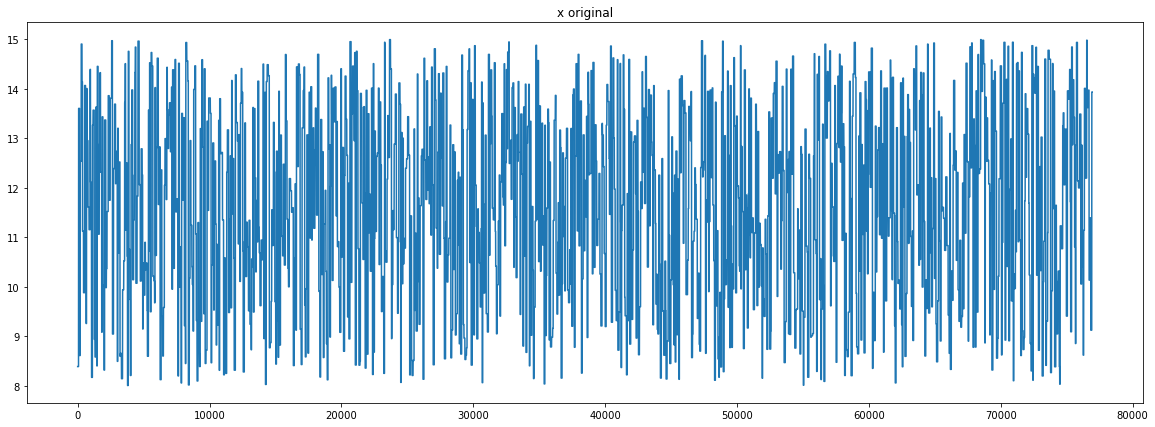

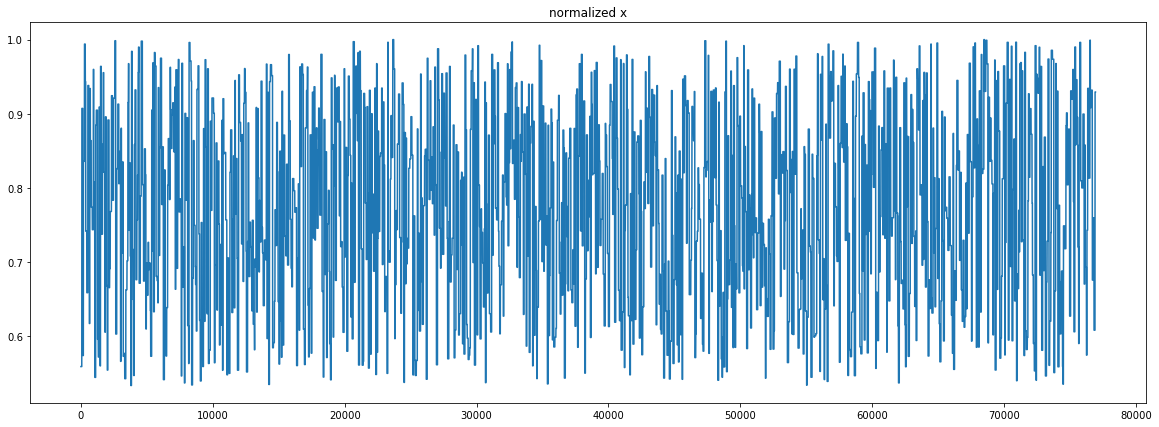

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (23015, 1)
Y_tensor torch.Size([23015, 1])
X_tensor torch.Size([64, 23013, 1])
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


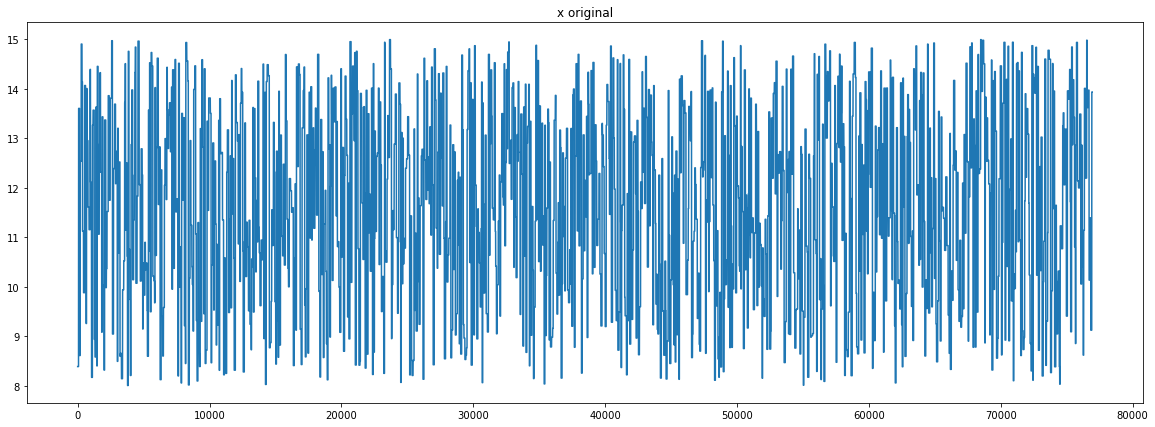

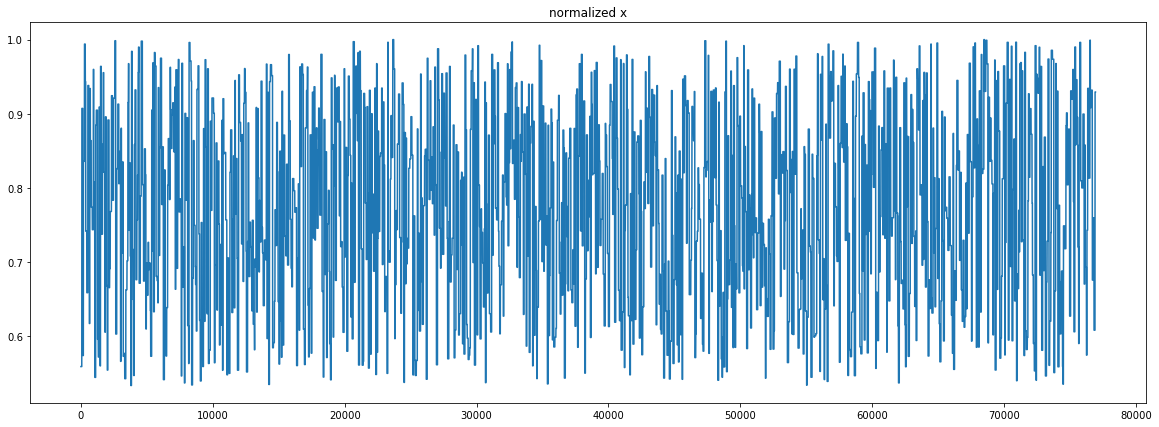

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (53846, 1)
output partition shape (53846, 1)
stacked Y shape  (53783, 1)
Y_tensor torch.Size([53783, 1])
X_tensor torch.Size([64, 53781, 1])
train set: [53783] batches
test set: [23015] batches
data_loading time 26.17047095298767 secs


In [10]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, use_part - use_part*p_data['test_size']),
                                logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x [batch_size, retrospective_steps, channels] :torch.Size([256, 64, 1])
y [batch_size, channels]: torch.Size([256, 1])
y_last [slice_size]: (150,)


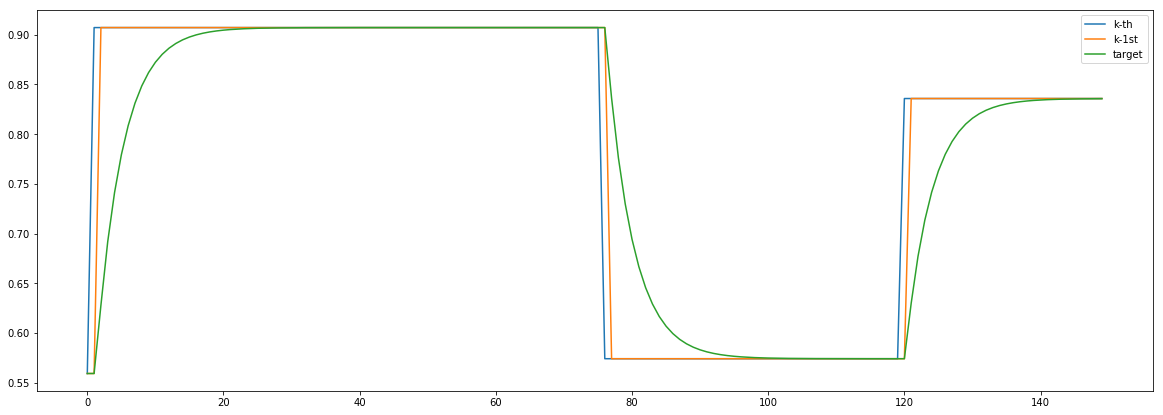

x [batch_size, retrospective_steps, channels] :torch.Size([256, 64, 1])
y [batch_size, channels]: torch.Size([256, 1])
y_last [slice_size]: (150,)


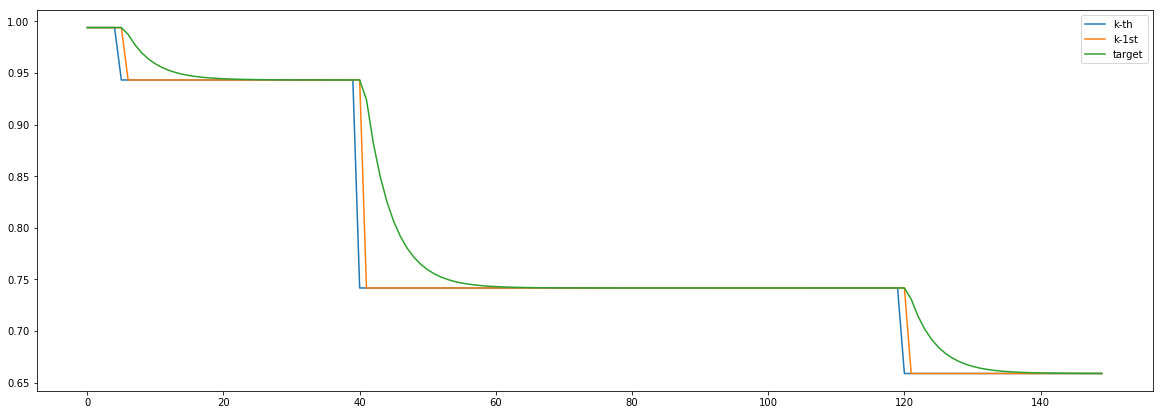

In [11]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x [batch_size, retrospective_steps, channels] :{x.shape}")
    print(f"y [batch_size, channels]: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last [slice_size]: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t], label='k-th')
    plt.plot(x.detach().numpy()[-2][f:t], label='k-1st')
    plt.plot(y_kth, label='target')
    plt.legend()
    plt.show()
    if i == 1:
        break

In [12]:
# #####################
# # 
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

In [104]:
logging.info("History INITIALIZED")

hist = {
    "train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "const":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    "eval_train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "const":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    "eval_test":{
        "batches":{
            "main":np.zeros(len(test_dl)),
            "aux":np.zeros(len(test_dl)),
            "const":np.zeros(len(test_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    'mean_params_sample':
    {
        '1':np.zeros(num_epochs),
        '2':np.zeros(num_epochs),            
    },
    'lr': np.zeros(num_epochs),
    'loss_rate': np.zeros(num_epochs),
    'weights_sum': np.zeros(num_epochs), 
    'weights_var': np.zeros(num_epochs),
    
}

In [14]:
def batch_iteration(iter_index, model, optimizer, batch_data, backprop, hist_part):
    
    x_batch, y_batch, indexes = data
    x_batch.transpose_(0, 1) # todo get rid of it
    model.hidden = model.init_hidden()

    y_pred, jordan = model(x_batch)
    losses = loss_fn(y_pred, jordan.t(), y_batch, x_batch, config)
    main_loss, aux_loss = losses
    aux_loss *= 10*p_train['aux_loss']['scaling_order']
    main_loss -= main_loss
    losses = [main_loss * 0, aux_loss]
#         print(f"losses before scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
    
    
    
    if backprop:
        combined_loss = sum(losses)

        optimizer.zero_grad()

        combined_loss.backward()
    # TODO or manually add weight decay here when grad is ready
    #         print(f"losses after scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
        
        optimizer.step()
    
    hist_part["main"][iter_index] = main_loss.item()
    hist_part["aux"][iter_index] = aux_loss.item()
    
    return y_pred, jordan

In [15]:
def update_long_term_hist(batches_hist, long_term_hist):
    mean_main = np.average(batches_hist["main"])
    mean_aux = np.average(batches_hist["aux"])
    long_term_hist["main"][t] = mean_main
    long_term_hist["aux"][t] = mean_aux
    return mean_main, mean_aux

In [16]:
def slice_loss_sum(losses_dict, index):
    return sum([val[index] for val in losses_dict.values()])

In [17]:
p_sched = p_train['lr_scheduler']
scheduler = ReduceLROnPlateau(optimizer=optimizer,
                              mode='min',
                              patience=p_sched['patience'],
                              cooldown=p_sched['cooldown'],
                              threshold=p_sched['threshold'],
                              threshold_mode='rel',
                            min_lr=10**p_sched['early_stop_order'],
                             verbose=True)
print("LR scheduler set_uped")
scheduler

LR scheduler set_uped


## Train model


aux preds: 0.19498997926712036 0.994819164276123
main loss 0.0
aux loss 24.7668357085614
combined loss 24.7668357085614 


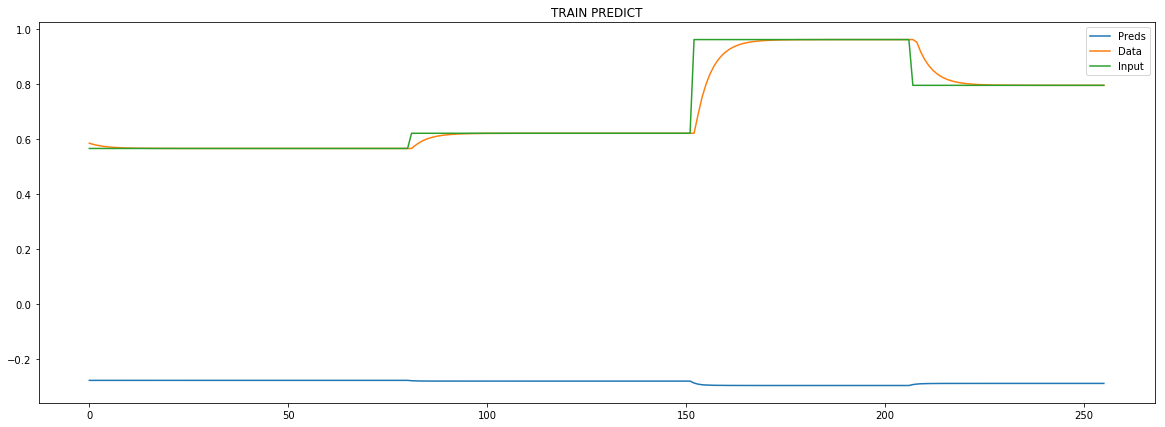

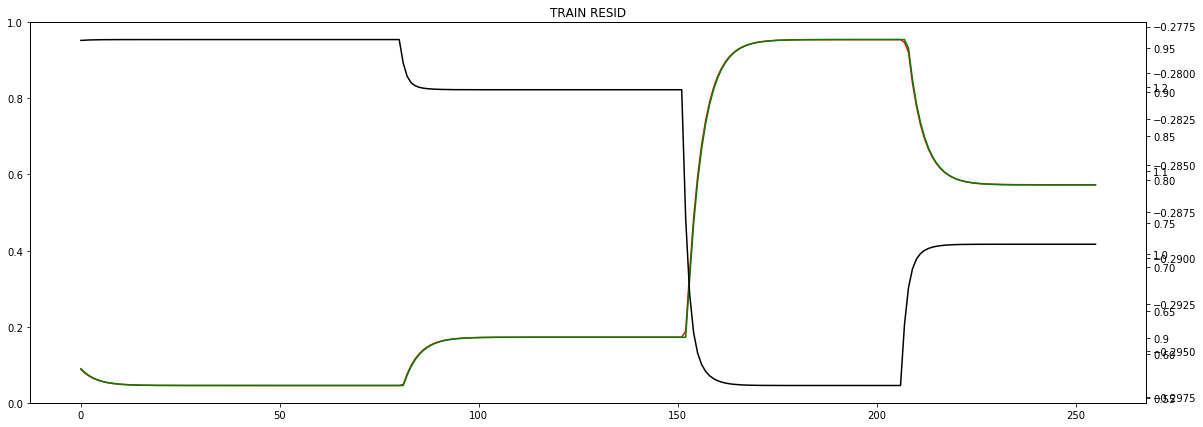


Parameter containing:
tensor([[0.1950, 0.9948]], requires_grad=True)


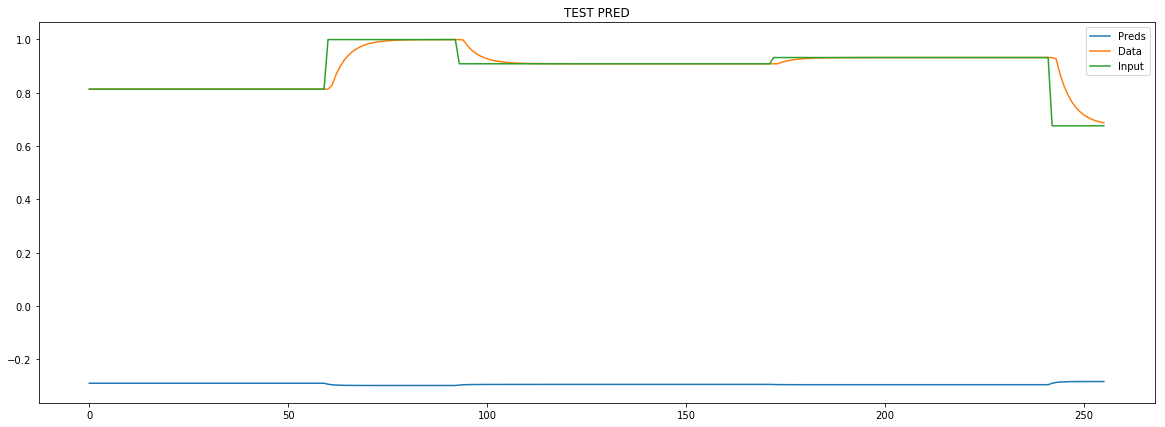

Epoch [0] 
     train_loss[24.7668357085614] 
     eval_train[1.0428030031067985] 
     eval_test[1.0486387935247314]



aux preds: 0.20474570989608765 1.000453233718872
main loss 0.0
aux loss 0.9210755172584738
combined loss 0.9210755172584738 


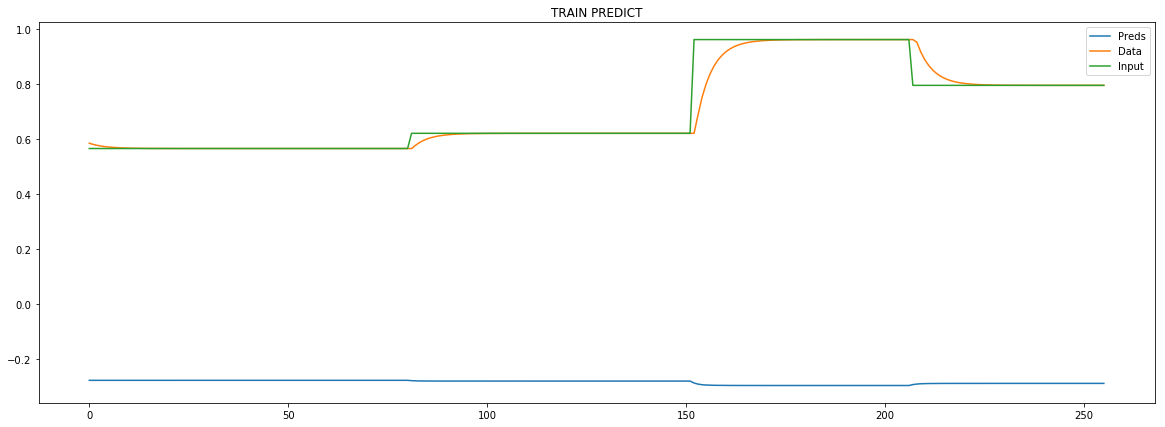

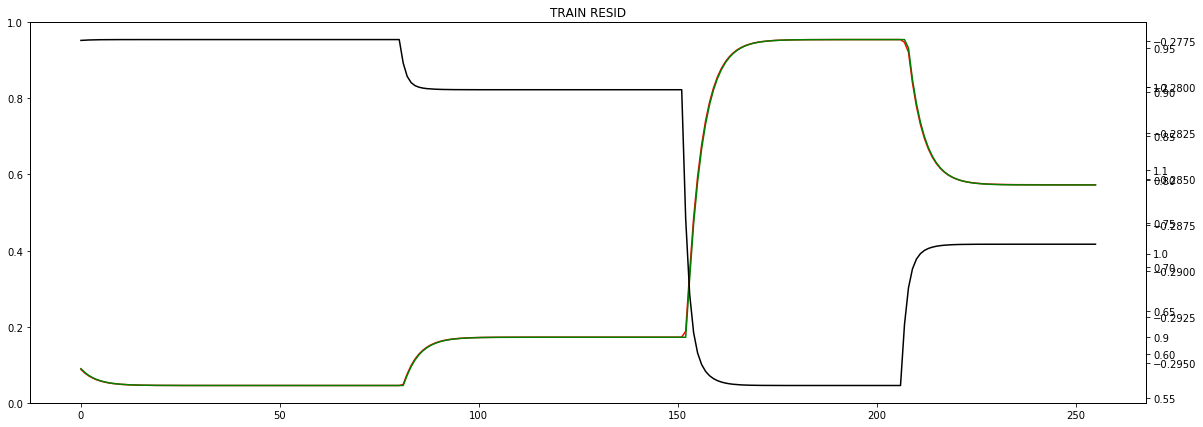


Parameter containing:
tensor([[0.2047, 1.0005]], requires_grad=True)


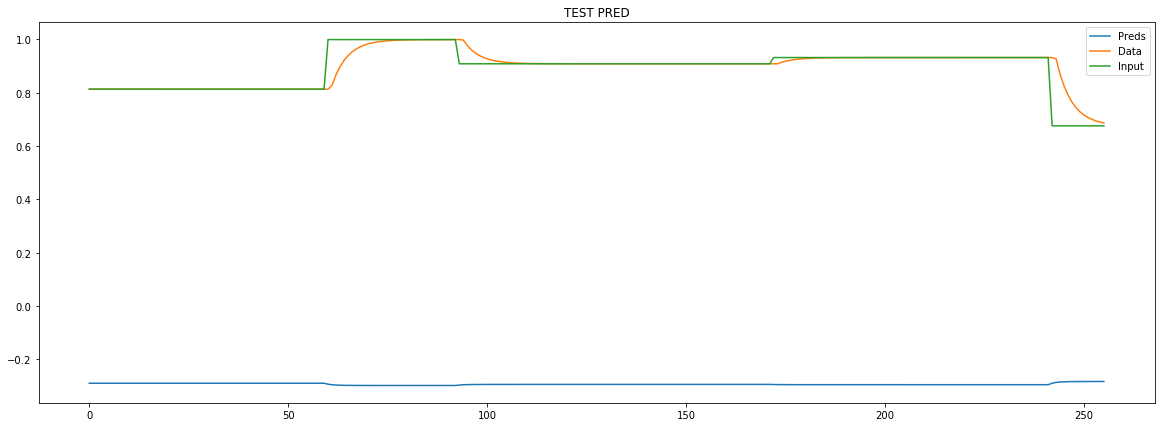

Epoch [1] 
     train_loss[0.9210755172584738] 
     eval_train[0.8792823772345271] 
     eval_test[0.8837939460625809]



aux preds: 0.216671884059906 0.9991139769554138
main loss 0.0
aux loss 0.8430725853357997
combined loss 0.8430725853357997 


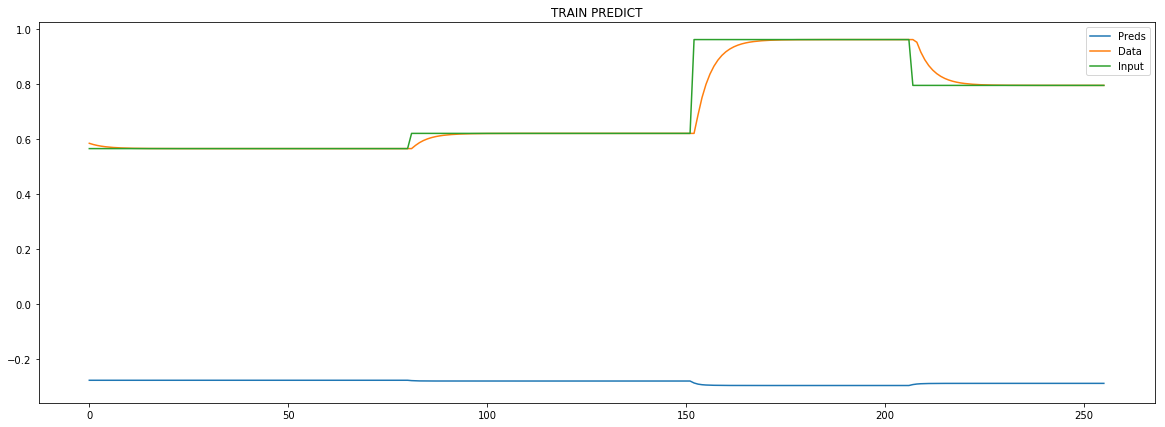

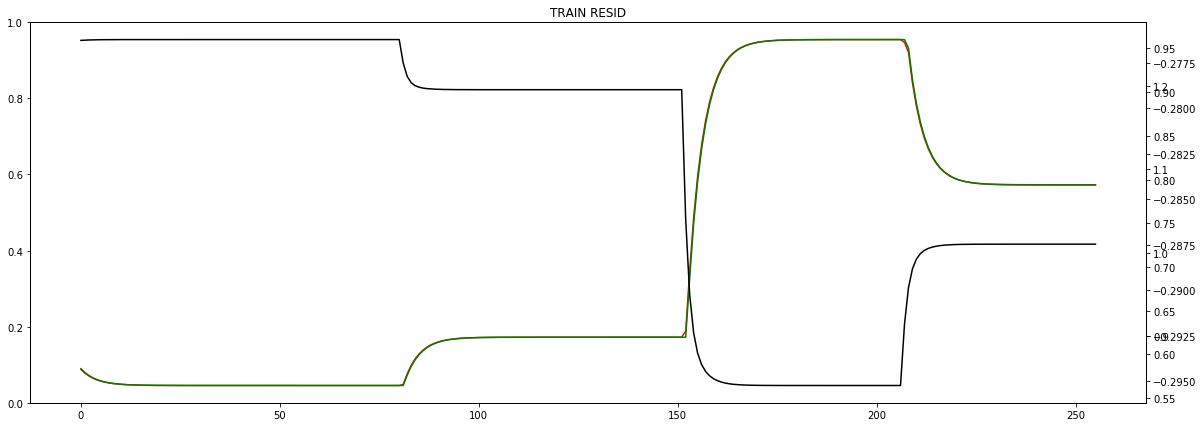


Parameter containing:
tensor([[0.2167, 0.9991]], requires_grad=True)


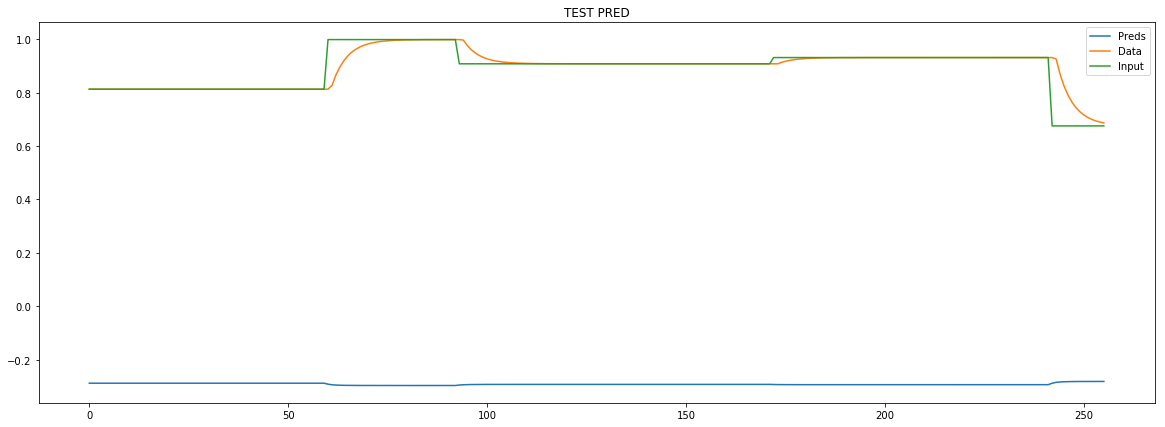

Epoch [2] 
     train_loss[0.8430725853357997] 
     eval_train[0.8103342300369626] 
     eval_test[0.814504725712069]



aux preds: 0.23001092672348022 1.0001906156539917
main loss 0.0
aux loss 0.7673958037225973
combined loss 0.7673958037225973 


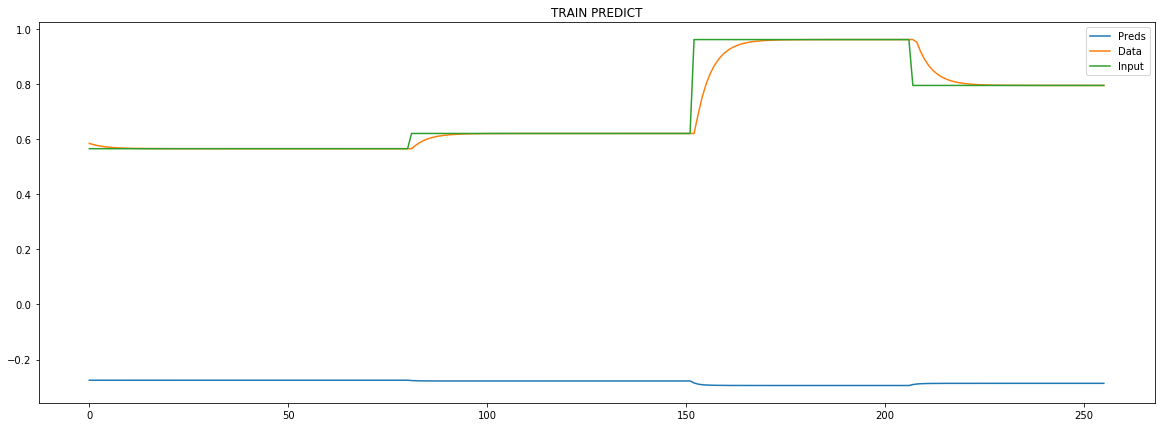

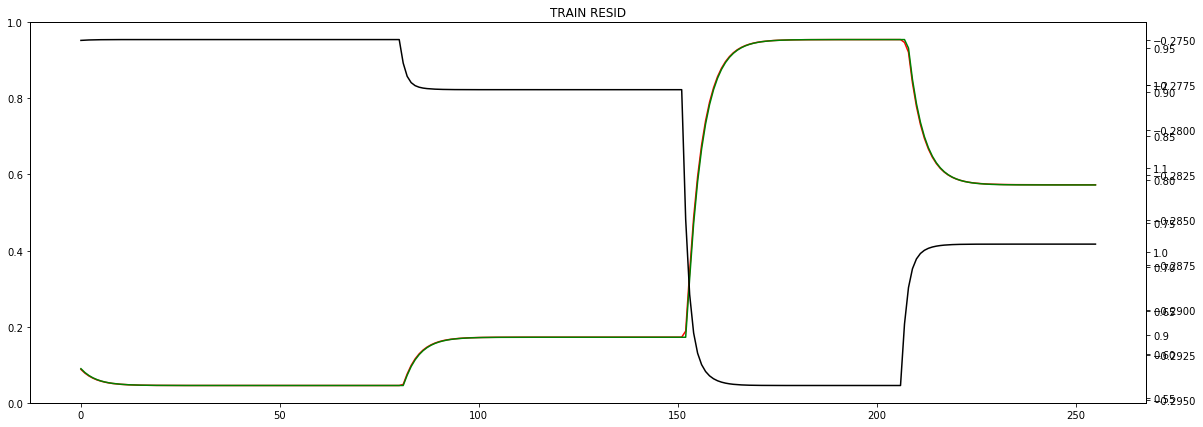


Parameter containing:
tensor([[0.2300, 1.0002]], requires_grad=True)


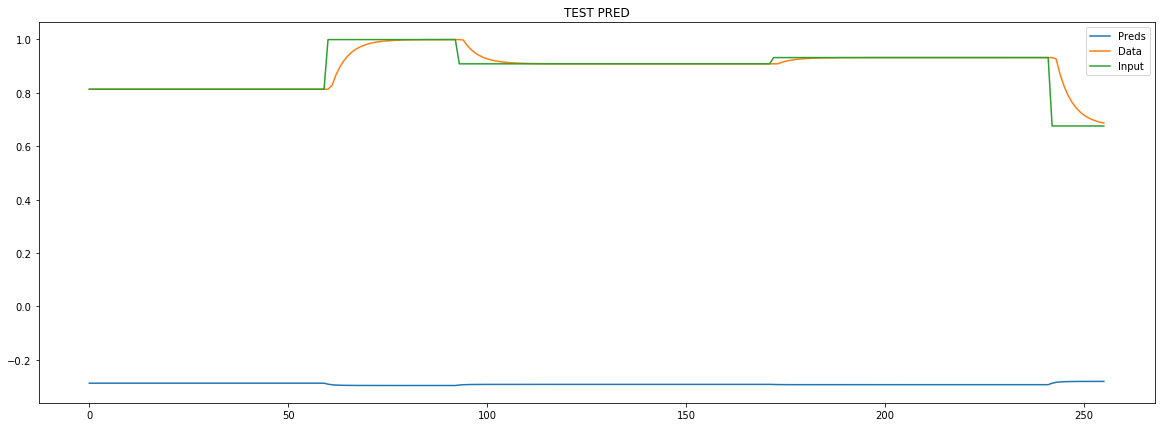

Epoch [3] 
     train_loss[0.7673958037225973] 
     eval_train[0.7233659362863927] 
     eval_test[0.7270600681894281]



aux preds: 0.24430012702941895 0.9991788864135742
main loss 0.0
aux loss 0.6976842119580223
combined loss 0.6976842119580223 


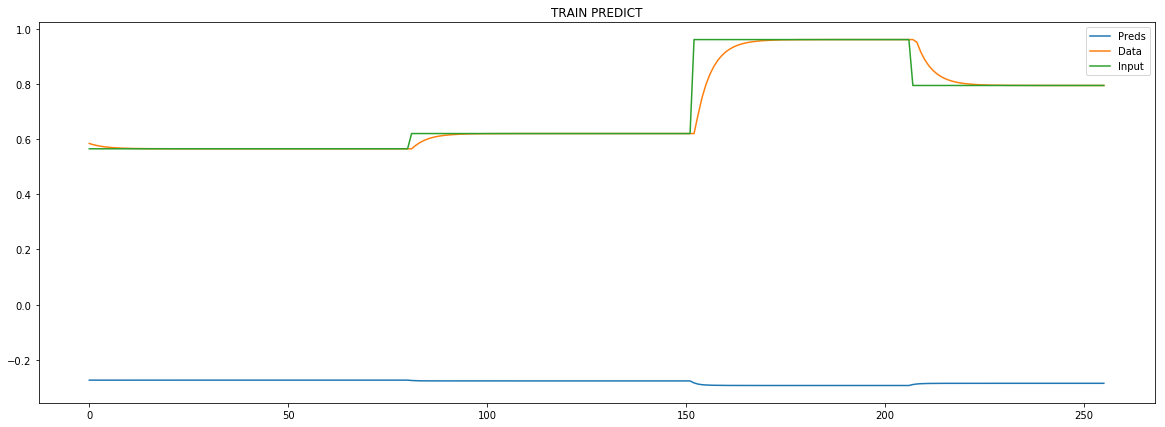

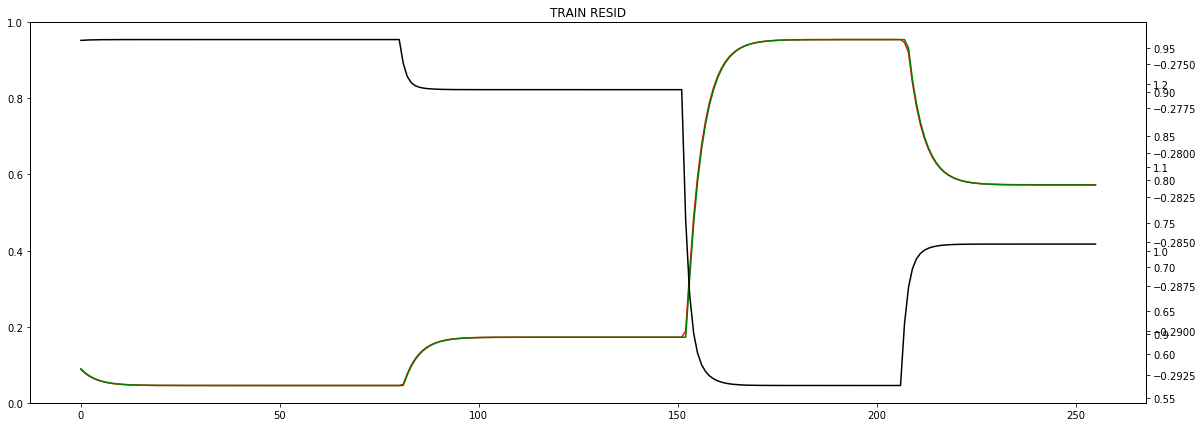


Parameter containing:
tensor([[0.2443, 0.9992]], requires_grad=True)


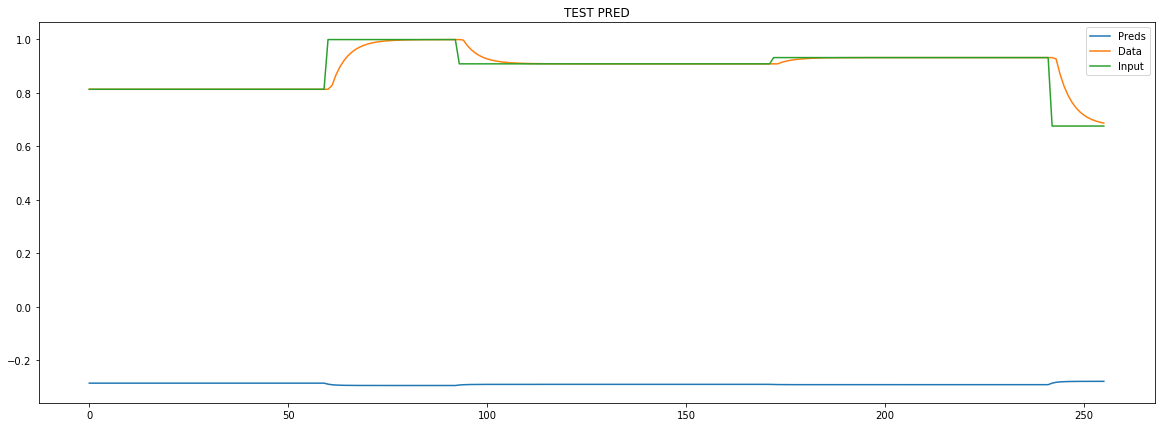

loss rate [0.17872554291704001]
Epoch [4] 
     train_loss[0.6976842119580223] 
     eval_train[0.6605160936713219] 
     eval_test[0.6639617274651367]



aux preds: 0.25917717814445496 0.9990382194519043
main loss 0.0
aux loss 0.6245692292317039
combined loss 0.6245692292317039 


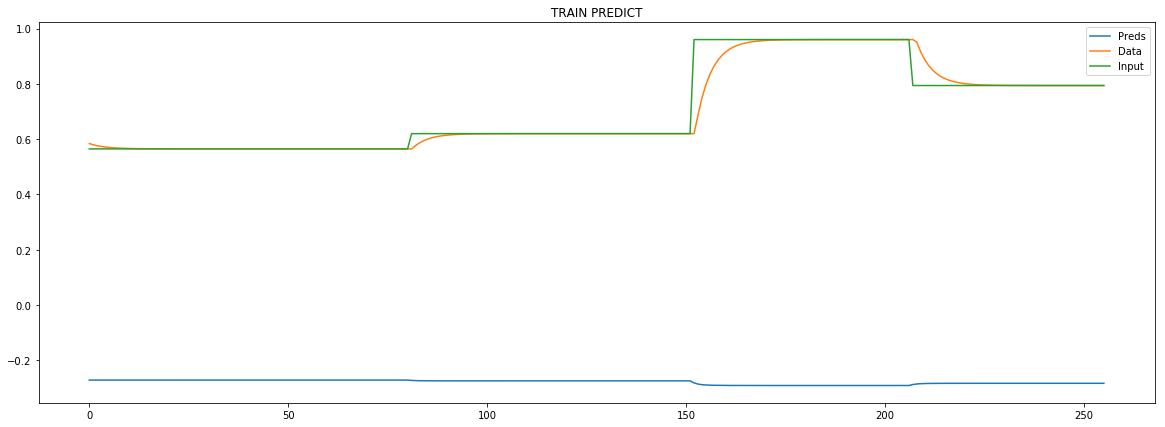

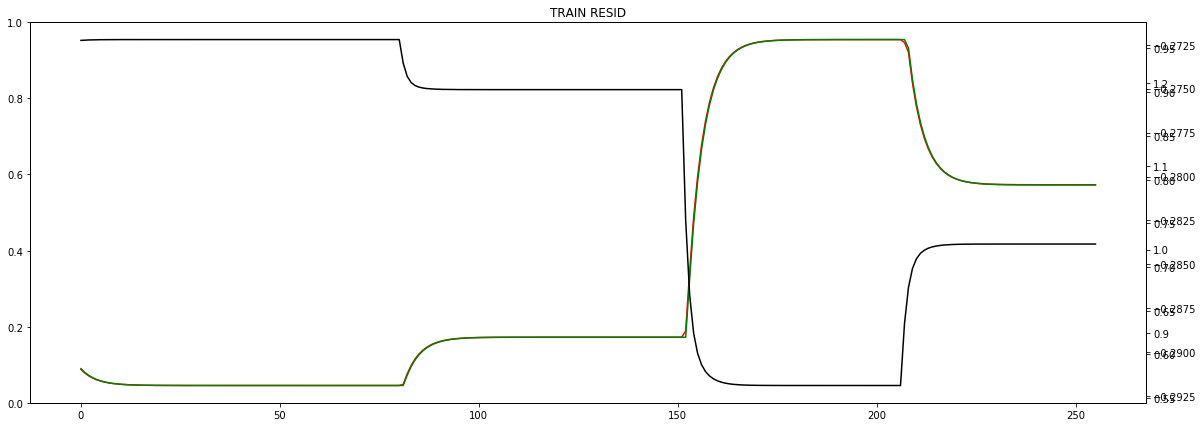


Parameter containing:
tensor([[0.2592, 0.9990]], requires_grad=True)


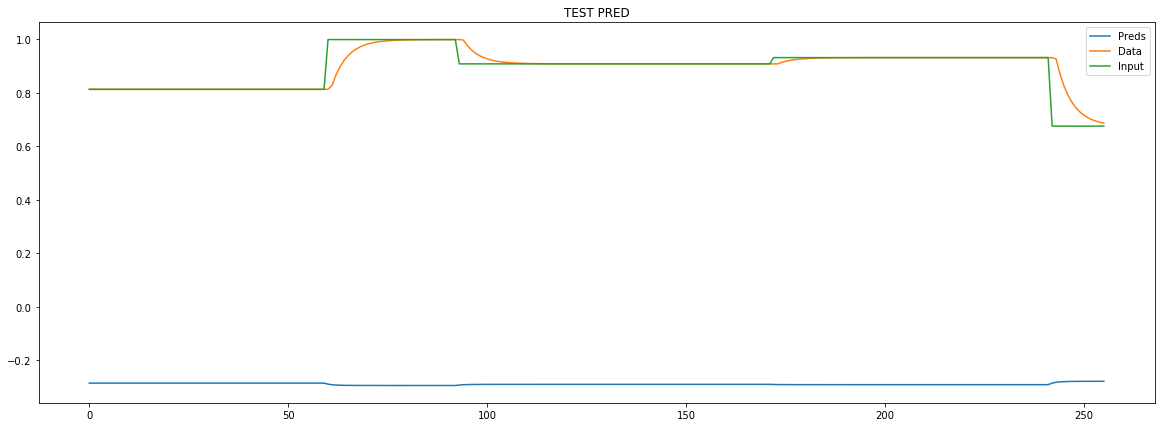

loss rate [0.1856638847849329]
Epoch [5] 
     train_loss[0.6245692292317039] 
     eval_train[0.5955294077595075] 
     eval_test[0.5986799664711684]



aux preds: 0.2745335102081299 1.0000741481781006
main loss 0.0
aux loss 0.5622028208559467
combined loss 0.5622028208559467 


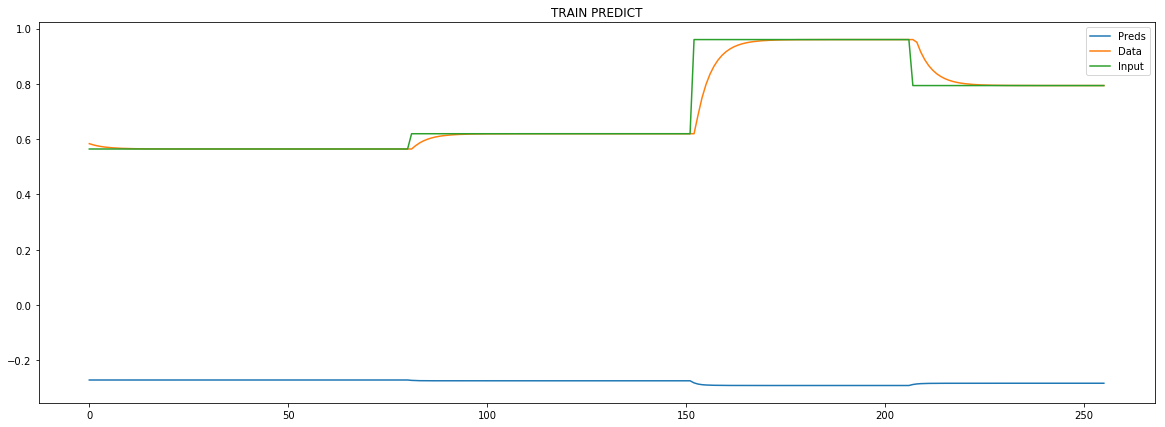

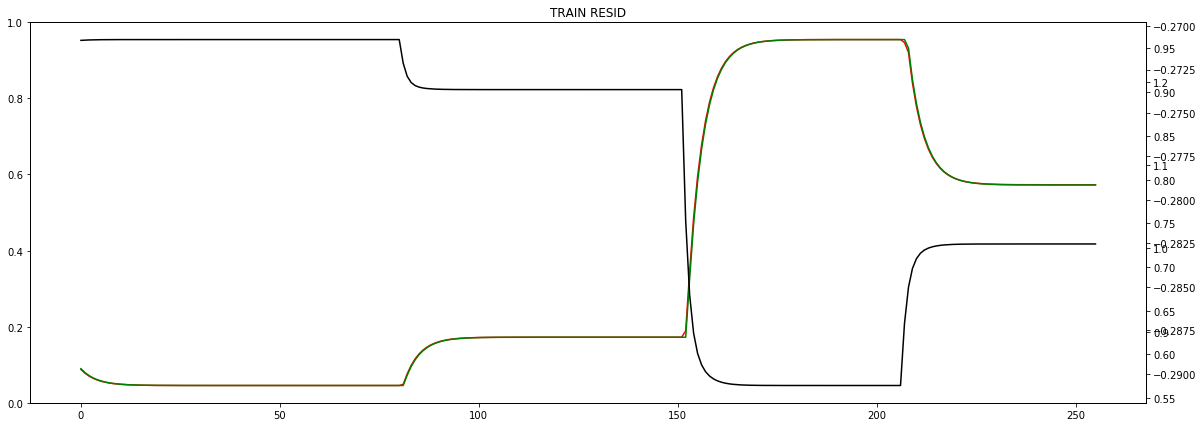


Parameter containing:
tensor([[0.2745, 1.0001]], requires_grad=True)


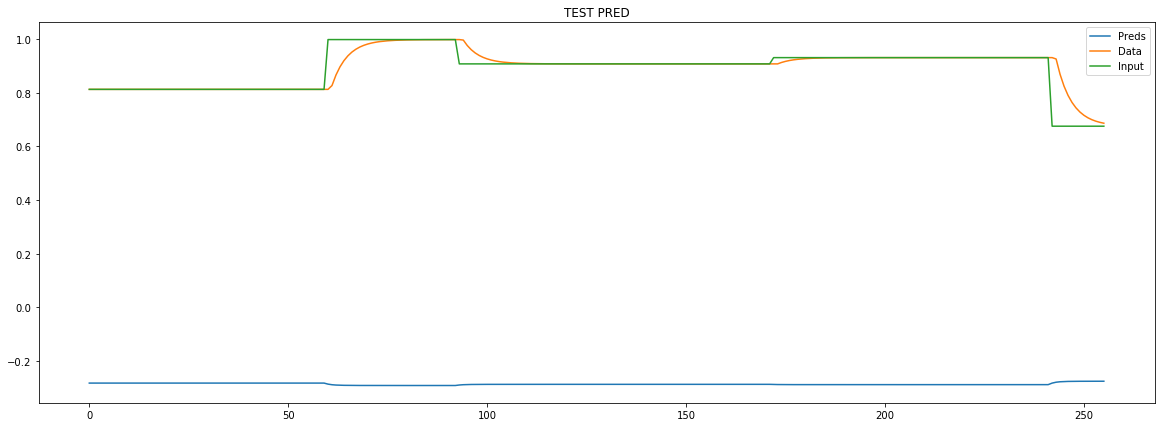

loss rate [0.20795187778171265]
Epoch [6] 
     train_loss[0.5622028208559467] 
     eval_train[0.5225987912288734] 
     eval_test[0.5253131814887014]



aux preds: 0.2902270555496216 0.9992883801460266
main loss 0.0
aux loss 0.5021888825687624
combined loss 0.5021888825687624 


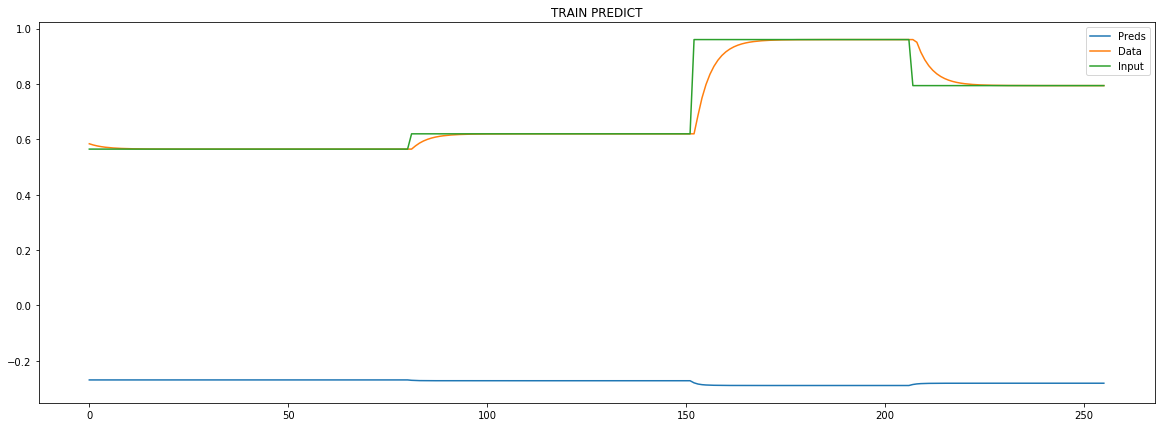

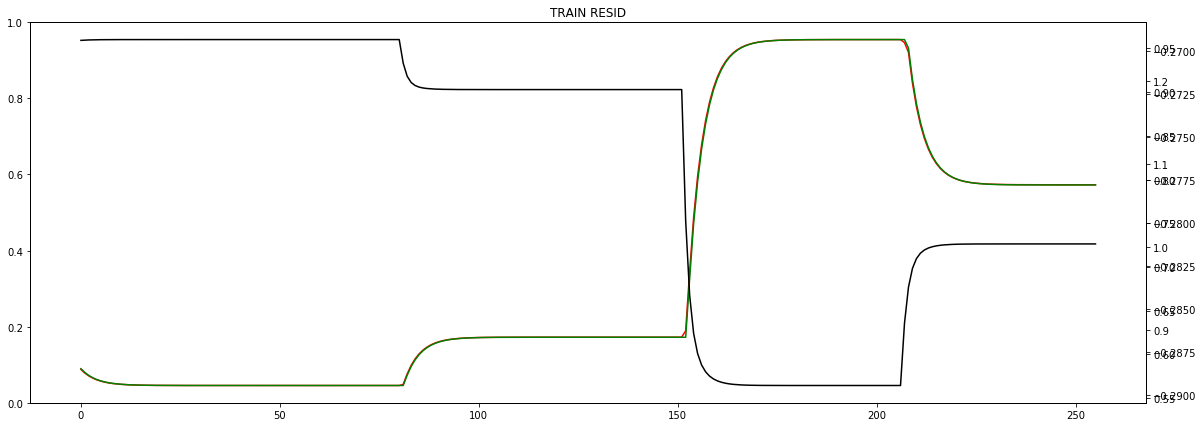


Parameter containing:
tensor([[0.2902, 0.9993]], requires_grad=True)


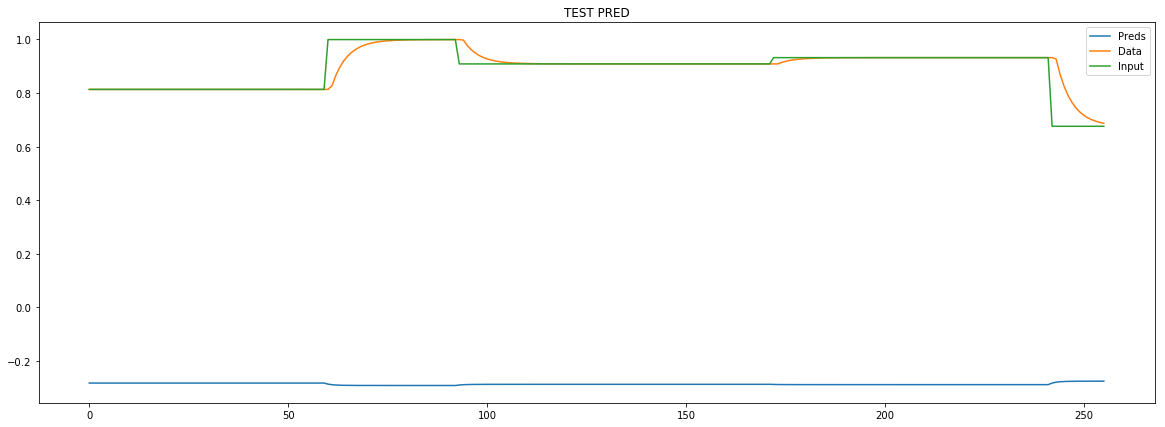

loss rate [0.19944575993965197]
Epoch [7] 
     train_loss[0.5021888825687624] 
     eval_train[0.47457246218054067] 
     eval_test[0.4771182855193535]



aux preds: 0.3062320947647095 1.0005959272384644
main loss 0.0
aux loss 0.4479844371477763
combined loss 0.4479844371477763 


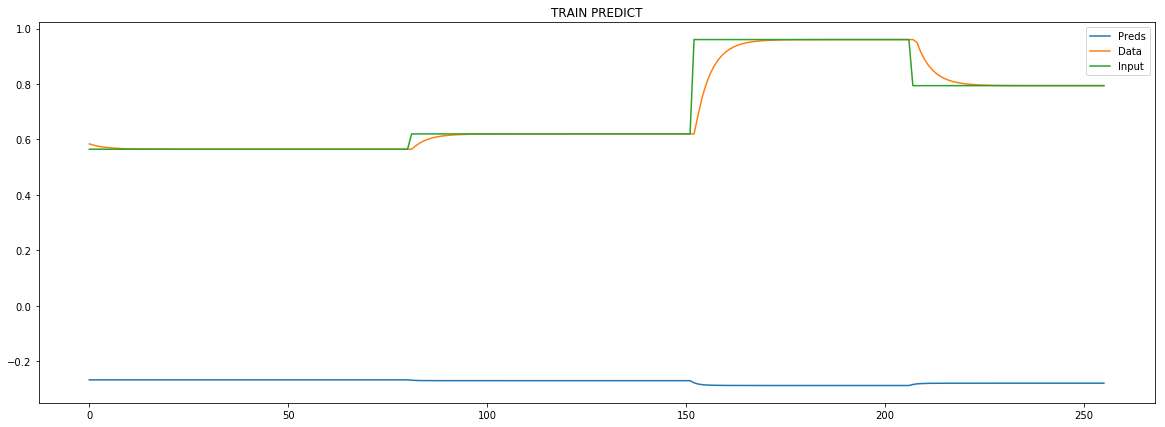

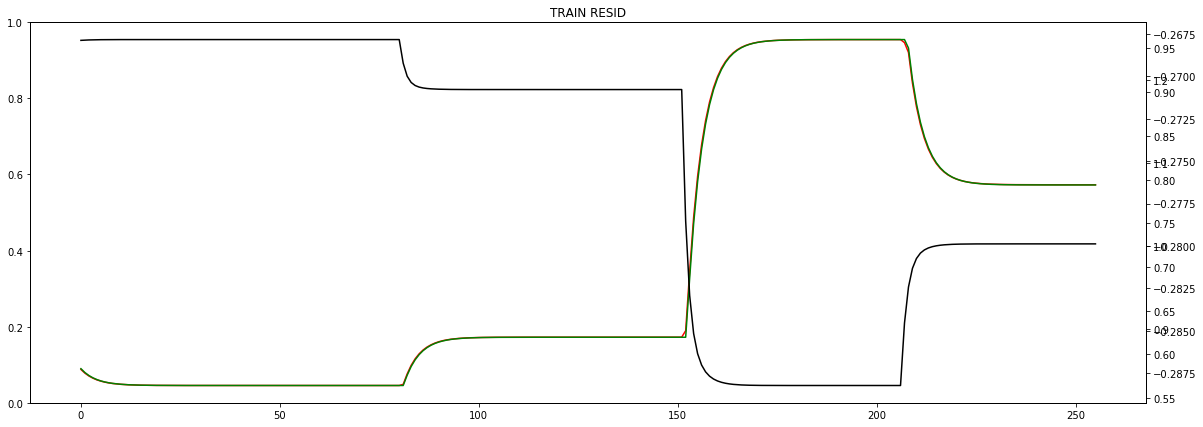


Parameter containing:
tensor([[0.3062, 1.0006]], requires_grad=True)


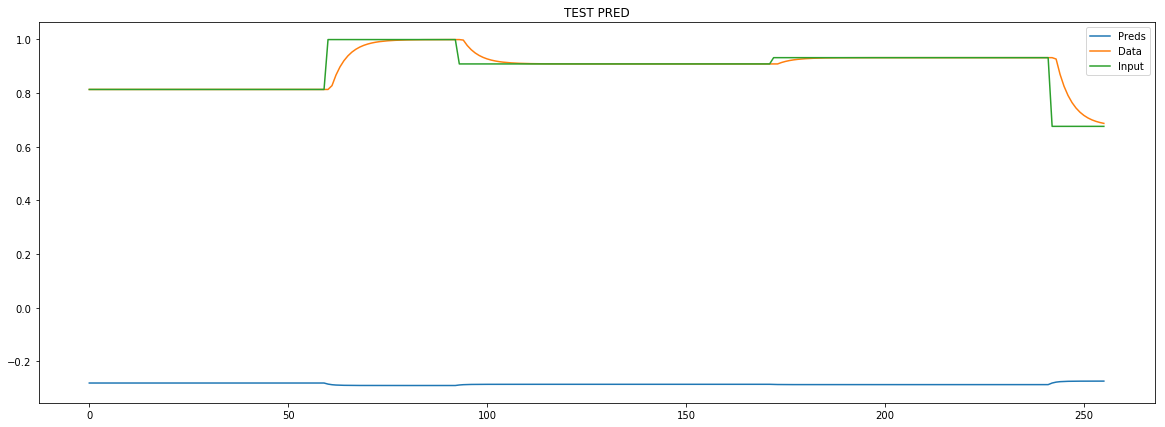

loss rate [0.20543414288823425]
Epoch [8] 
     train_loss[0.4479844371477763] 
     eval_train[0.4217249717031206] 
     eval_test[0.42406282615795565]



aux preds: 0.32255685329437256 0.9991207122802734
main loss 0.0
aux loss 0.4020178436878182
combined loss 0.4020178436878182 


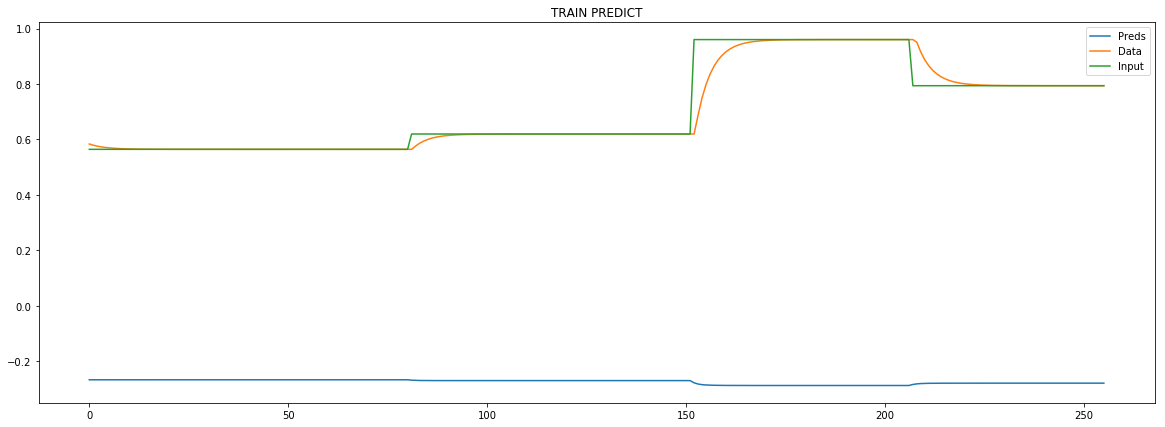

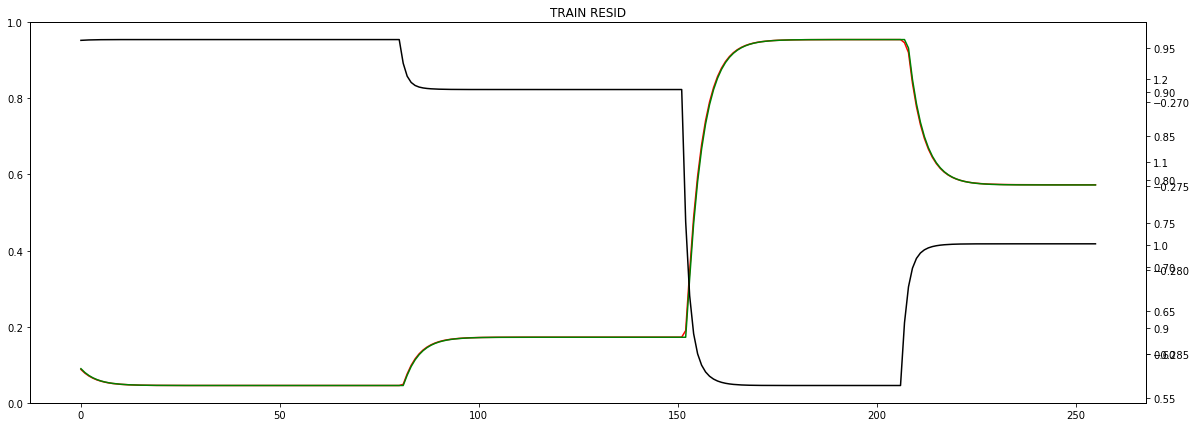


Parameter containing:
tensor([[0.3226, 0.9991]], requires_grad=True)


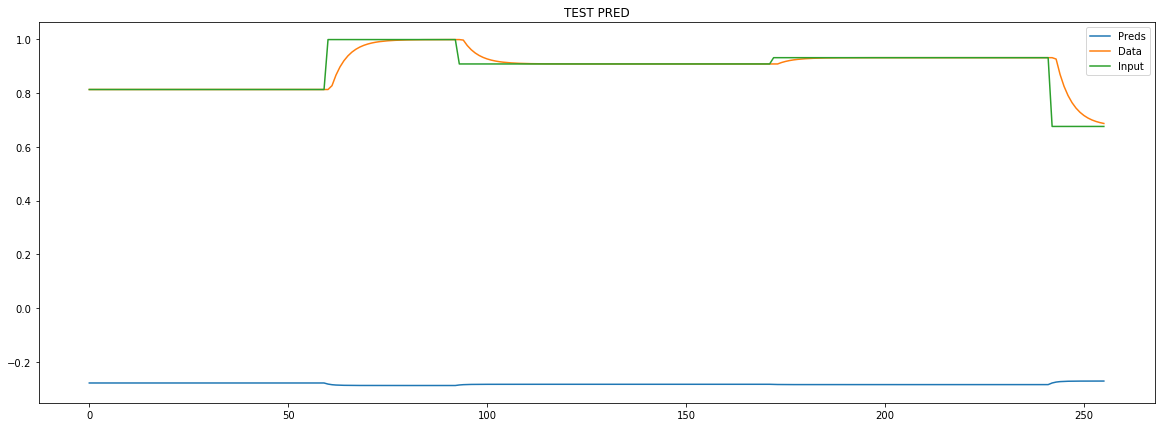

loss rate [0.20013346087040162]
Epoch [9] 
     train_loss[0.4020178436878182] 
     eval_train[0.37823347465268203] 
     eval_test[0.38033501778760653]



aux preds: 0.3391358256340027 1.0002882480621338
main loss 0.0
aux loss 0.35328518042252177
combined loss 0.35328518042252177 


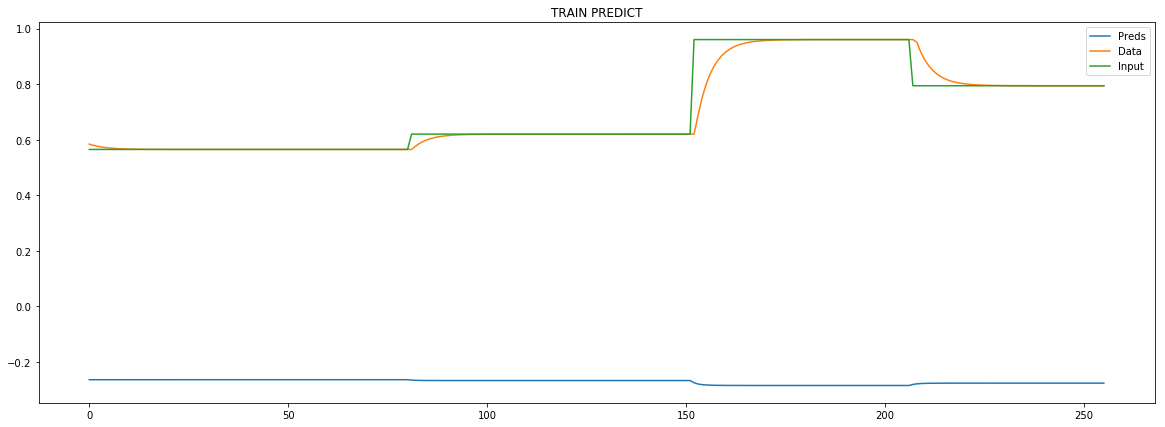

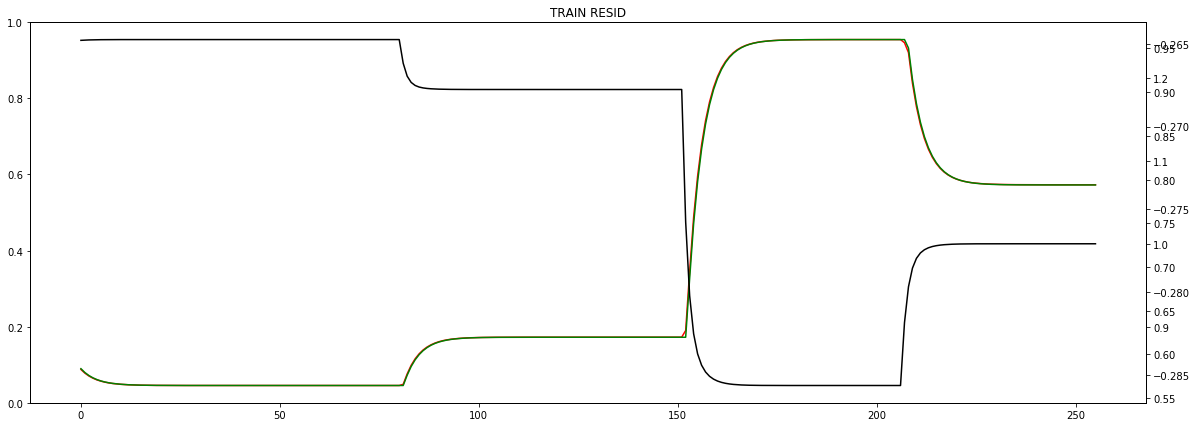


Parameter containing:
tensor([[0.3391, 1.0003]], requires_grad=True)


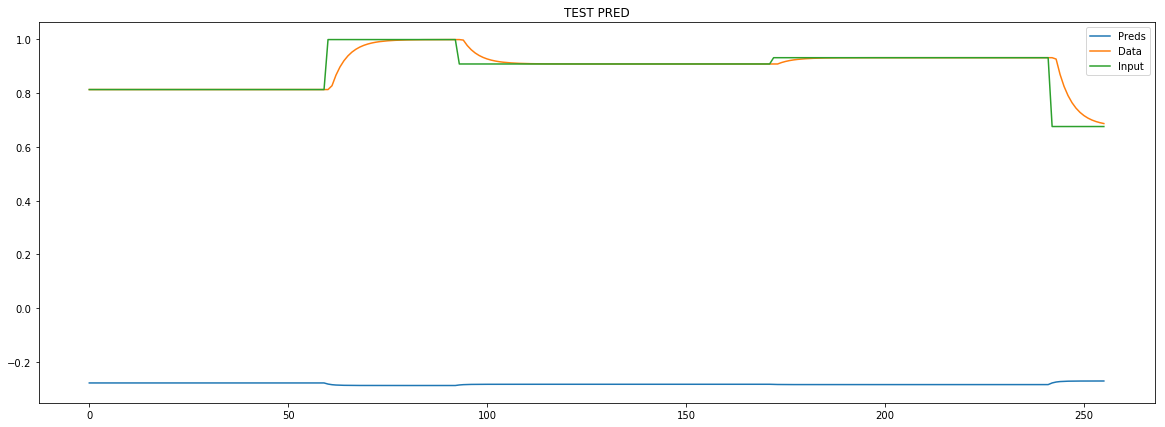

loss rate [0.22665574404510125]
Epoch [10] 
     train_loss[0.35328518042252177] 
     eval_train[0.32851162167886894] 
     eval_test[0.3303510458784157]



aux preds: 0.3560245931148529 1.0005186796188354
main loss 0.0
aux loss 0.3133883442197527
combined loss 0.3133883442197527 


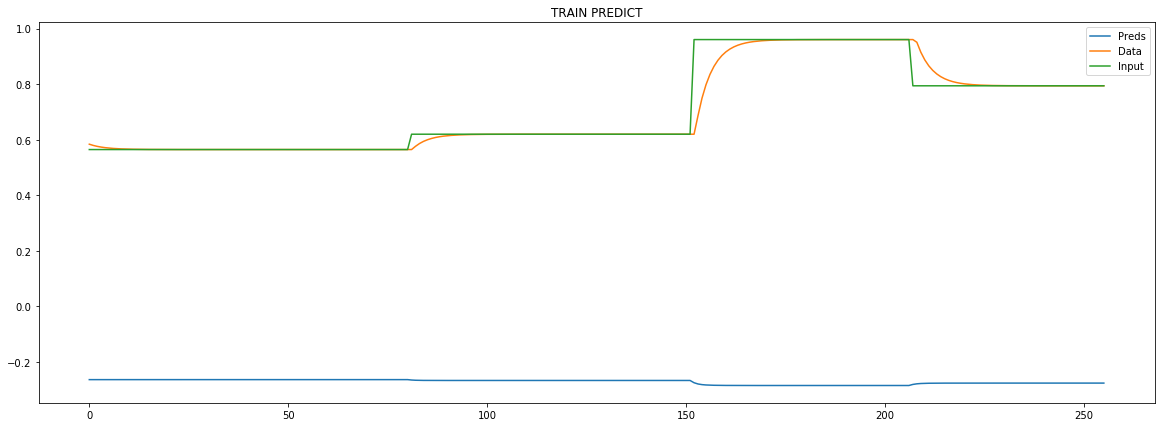

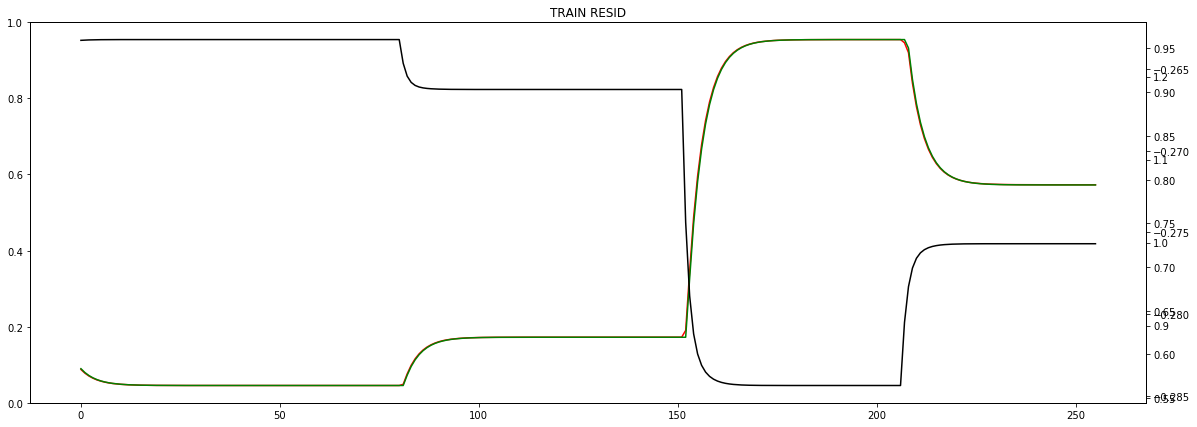


Parameter containing:
tensor([[0.3560, 1.0005]], requires_grad=True)


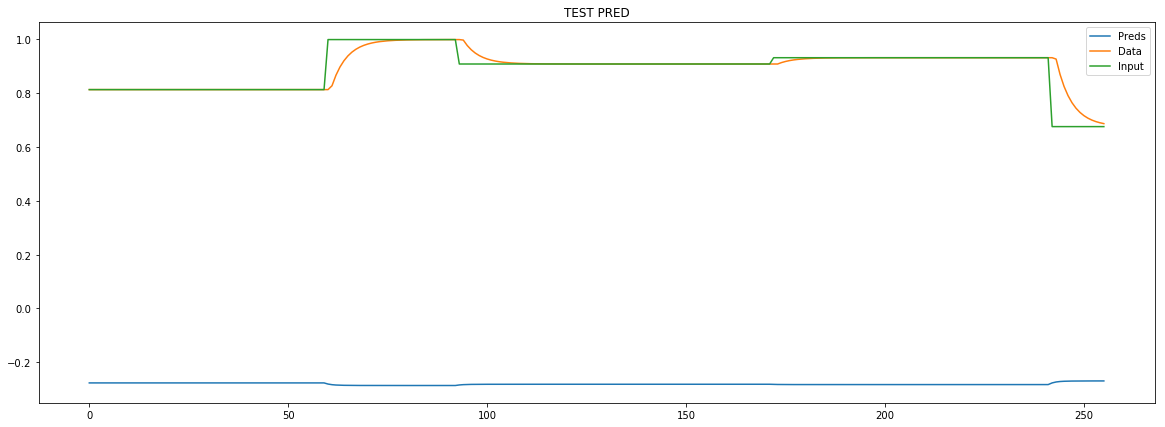

loss rate [0.22560704073461546]
Epoch [11] 
     train_loss[0.3133883442197527] 
     eval_train[0.2912192573149999] 
     eval_test[0.29291385027129996]



aux preds: 0.373249888420105 0.9997520446777344
main loss 0.0
aux loss 0.27743825531076816
combined loss 0.27743825531076816 


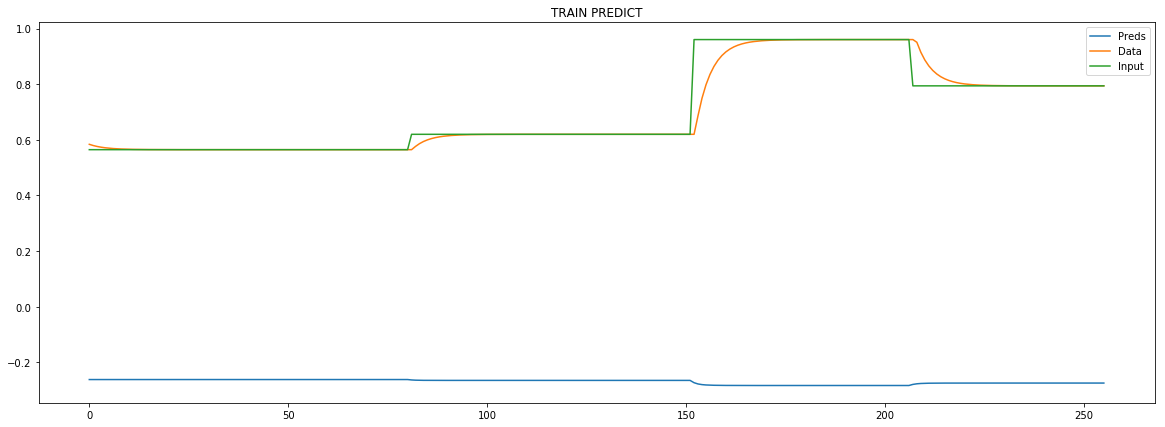

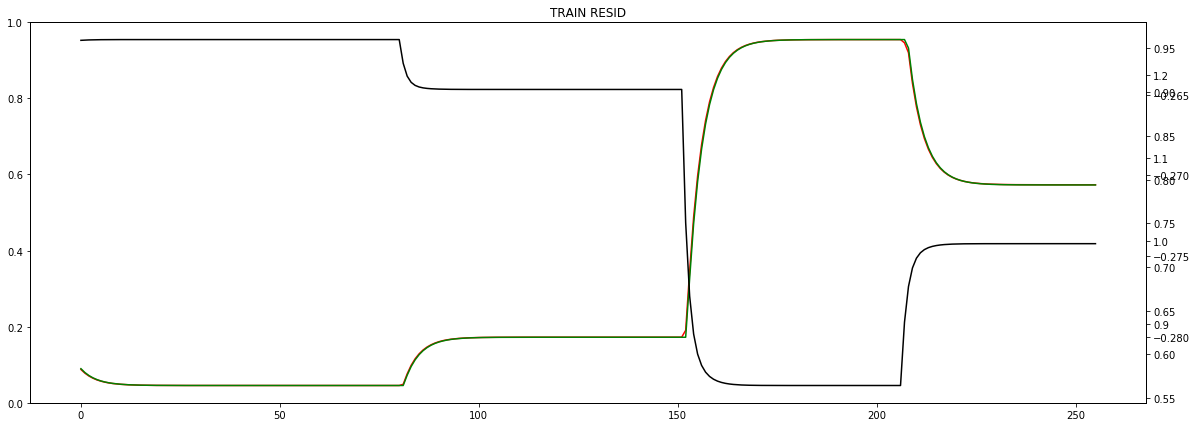


Parameter containing:
tensor([[0.3732, 0.9998]], requires_grad=True)


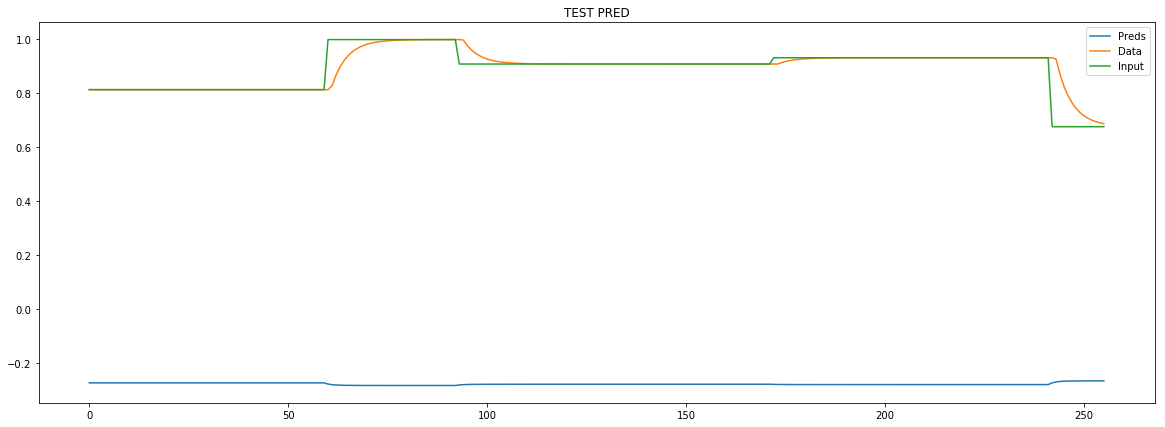

loss rate [0.24230105743684038]
Epoch [12] 
     train_loss[0.27743825531076816] 
     eval_train[0.25202653480782394] 
     eval_test[0.25347553118226235]



aux preds: 0.39079537987709045 0.9979104399681091
main loss 0.0
aux loss 0.2417144076189115
combined loss 0.2417144076189115 


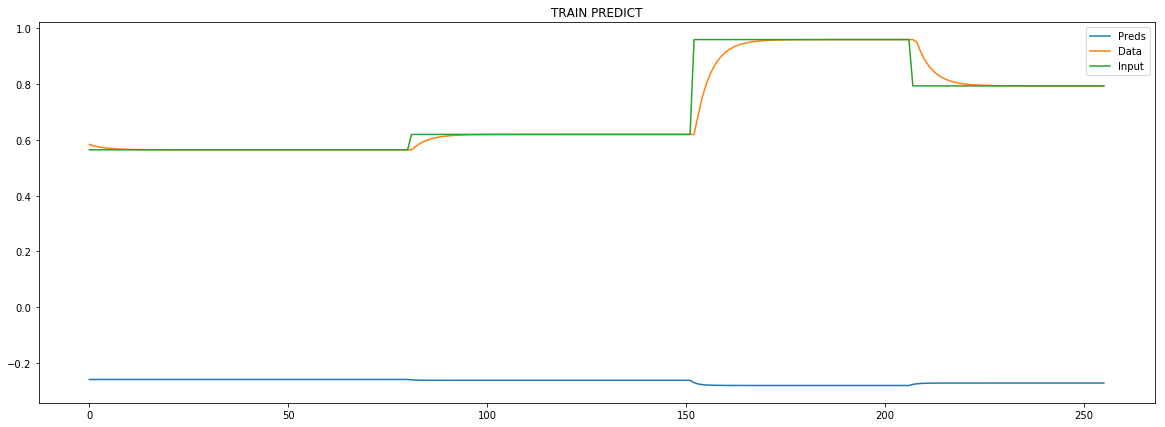

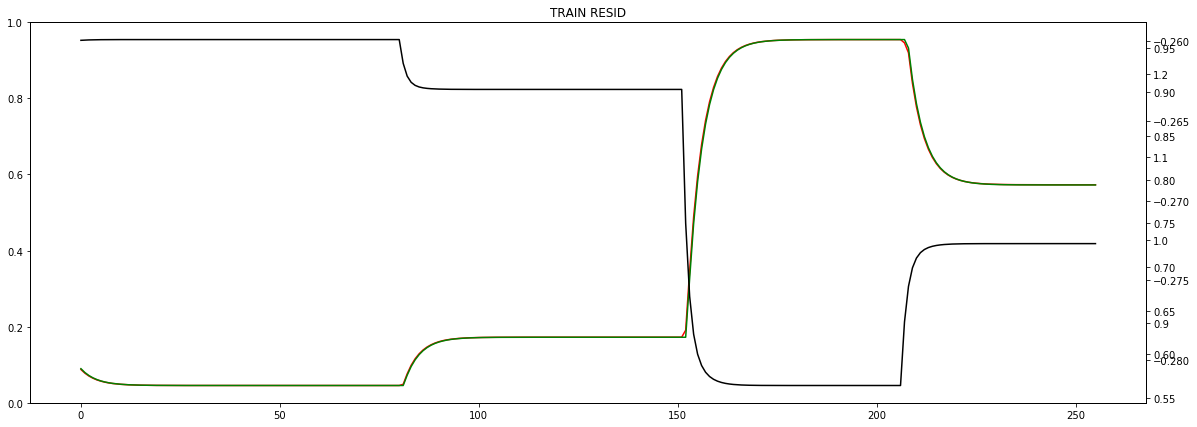


Parameter containing:
tensor([[0.3908, 0.9979]], requires_grad=True)


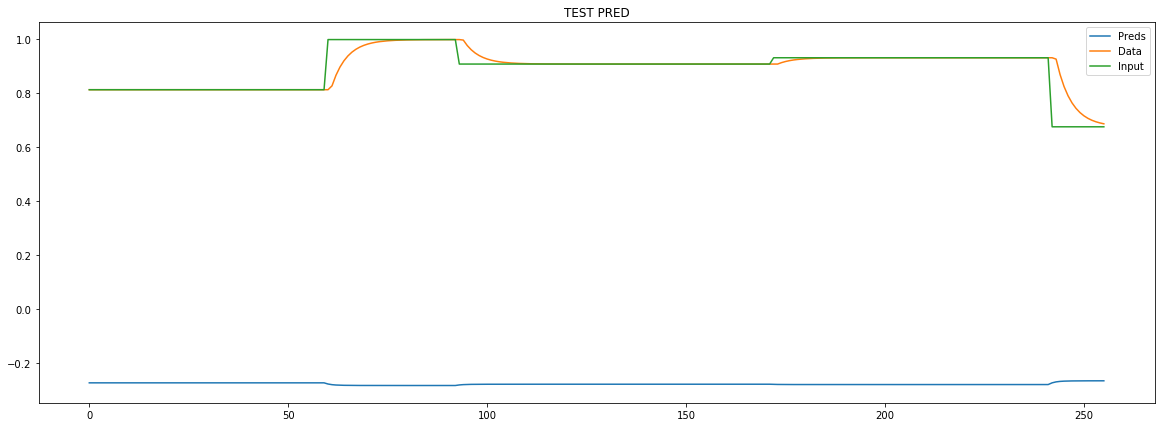

loss rate [0.18501922281428462]
Epoch [13] 
     train_loss[0.2417144076189115] 
     eval_train[0.23668837451509067] 
     eval_test[0.23817553161905053]



aux preds: 0.4086735248565674 1.0006386041641235
main loss 0.0
aux loss 0.20697778068660272
combined loss 0.20697778068660272 


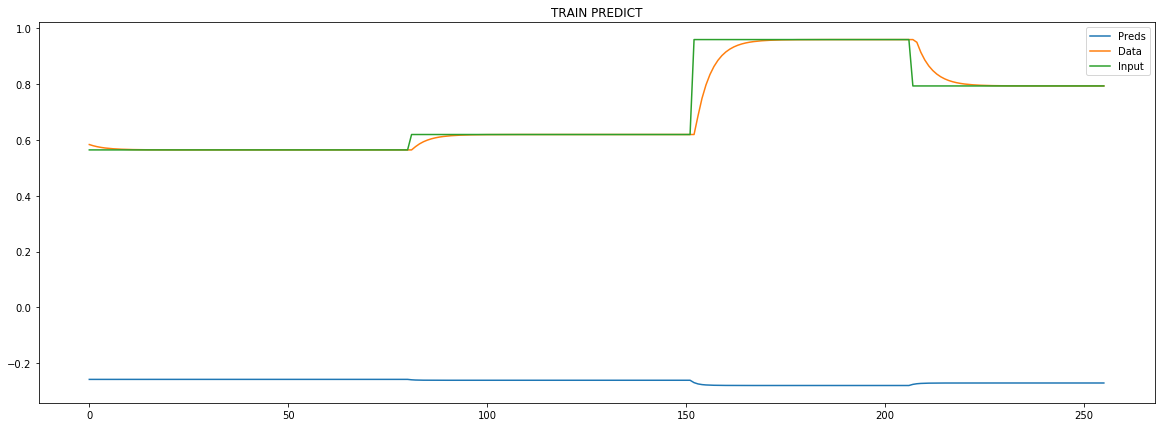

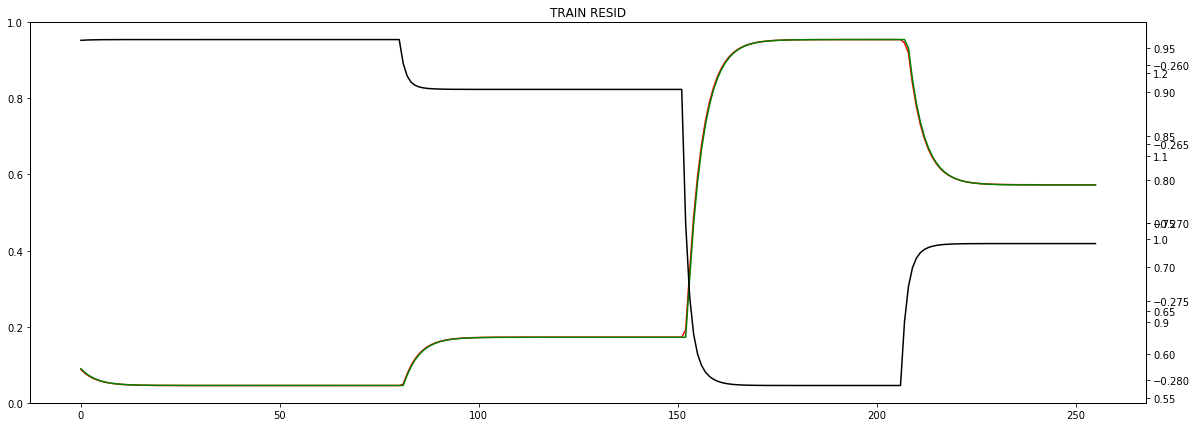


Parameter containing:
tensor([[0.4087, 1.0006]], requires_grad=True)


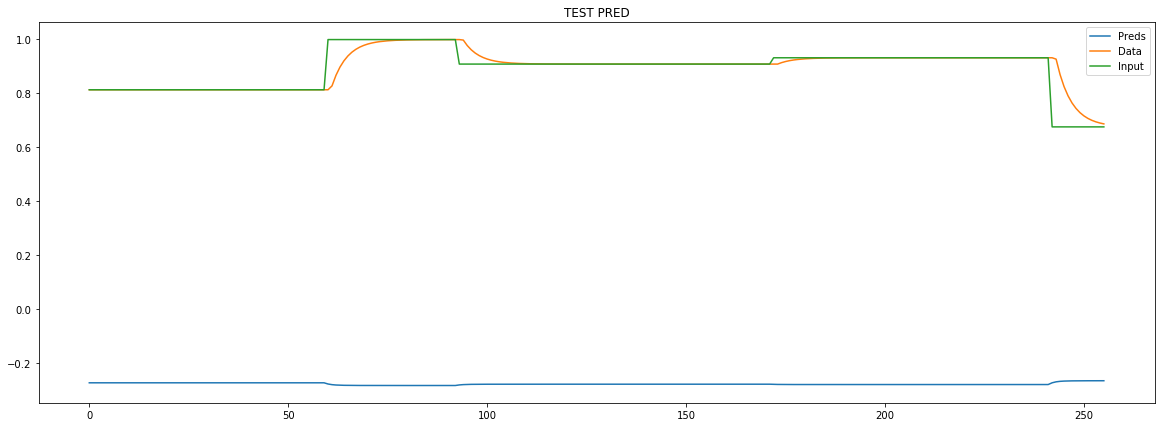

loss rate [0.2697514130014116]
Epoch [14] 
     train_loss[0.20697778068660272] 
     eval_train[0.18976198196233737] 
     eval_test[0.1909758063933153]



aux preds: 0.42691370844841003 1.0006730556488037
main loss 0.0
aux loss 0.17791050191791286
combined loss 0.17791050191791286 


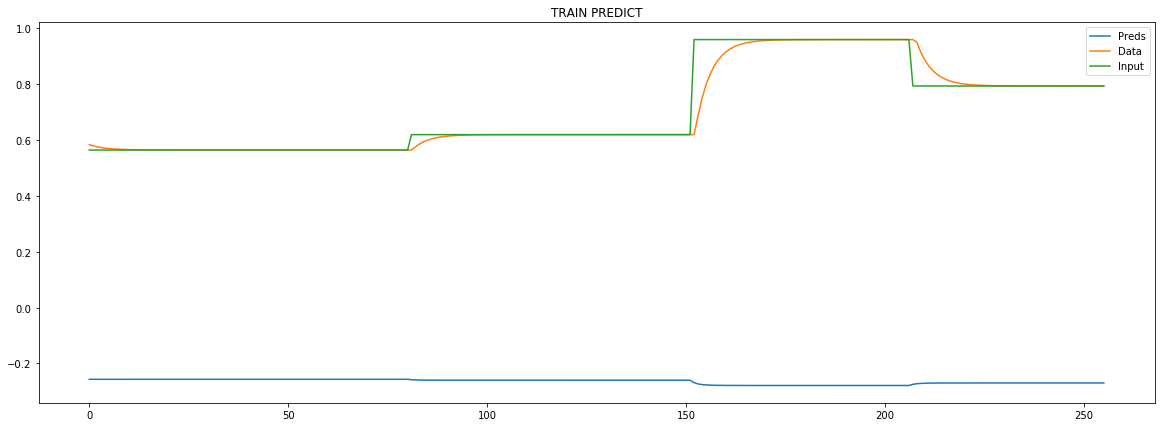

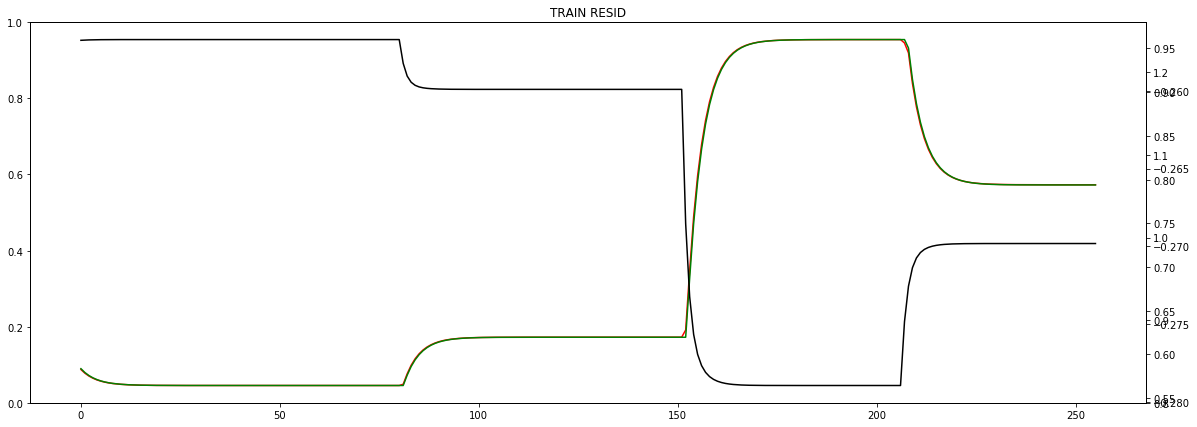


Parameter containing:
tensor([[0.4269, 1.0007]], requires_grad=True)


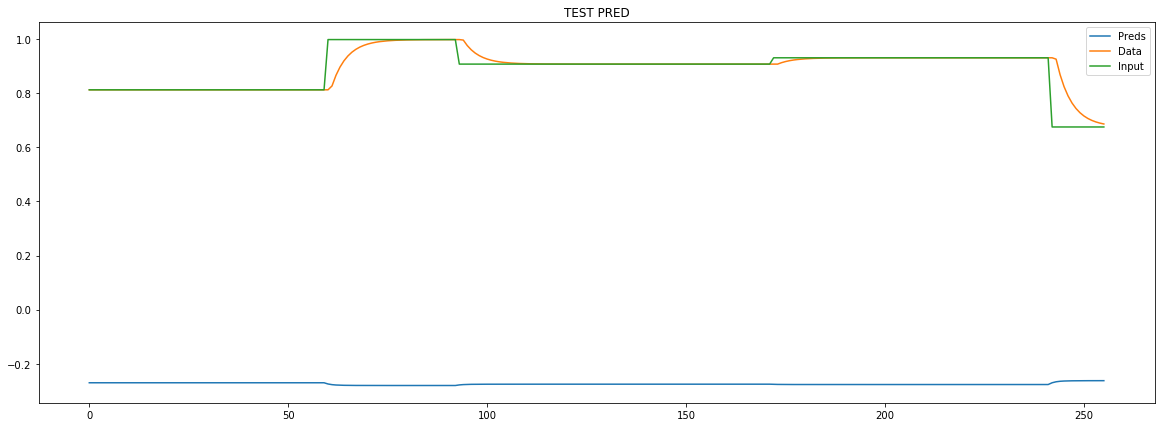

loss rate [0.2900547203801269]
Epoch [15] 
     train_loss[0.17791050191791286] 
     eval_train[0.16047090998008137] 
     eval_test[0.1615425745088063]



aux preds: 0.4455055594444275 0.9988960027694702
main loss 0.0
aux loss 0.14824194239363783
combined loss 0.14824194239363783 


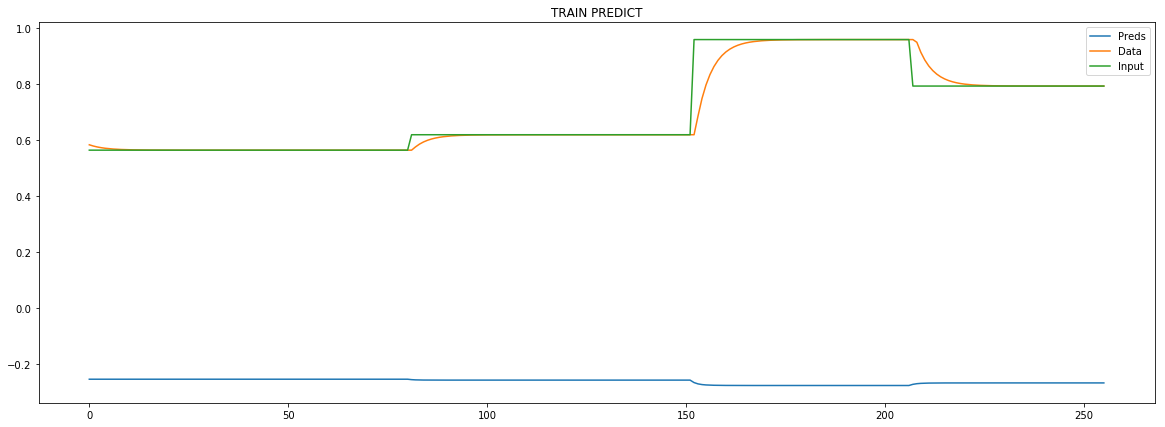

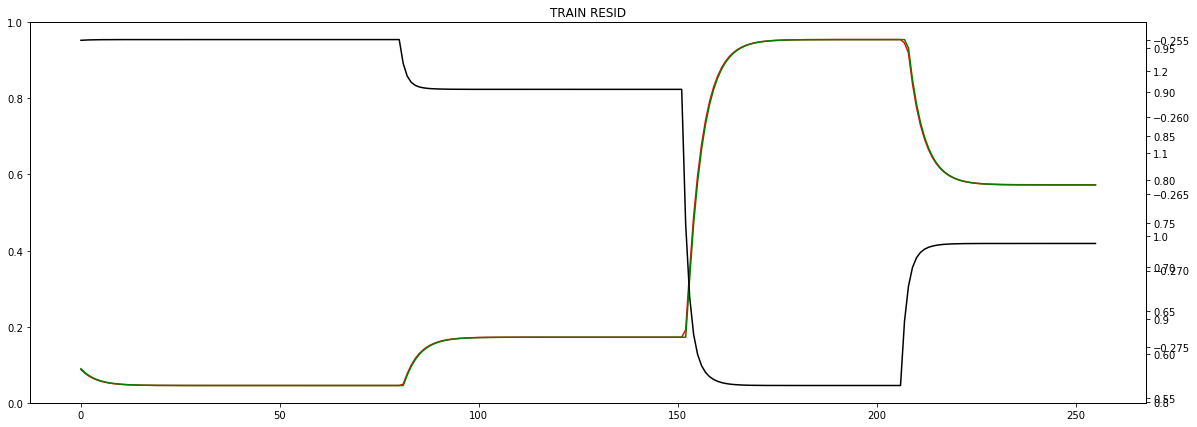


Parameter containing:
tensor([[0.4455, 0.9989]], requires_grad=True)


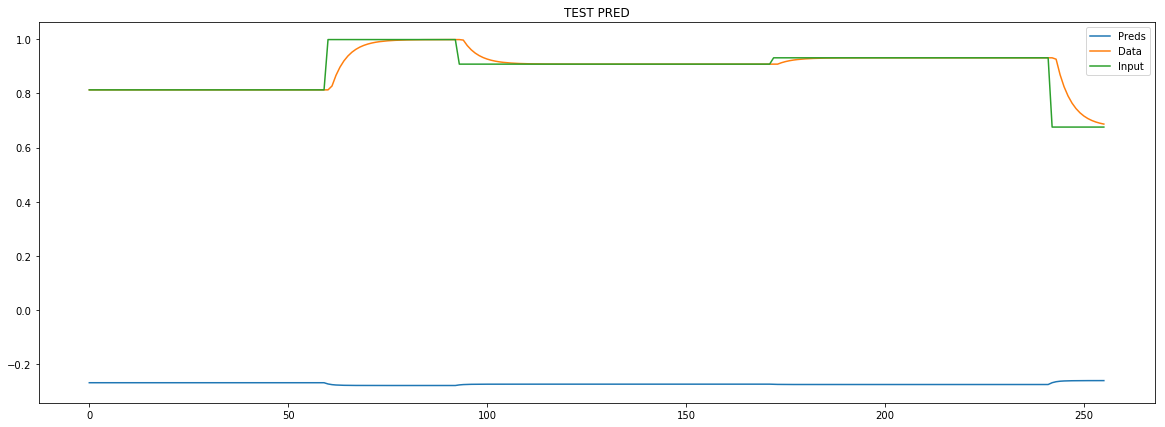

loss rate [0.29924052376635135]
Epoch [16] 
     train_loss[0.14824194239363783] 
     eval_train[0.13703505199934754] 
     eval_test[0.1379781189175804]



aux preds: 0.46435660123825073 1.0005600452423096
main loss 0.0
aux loss 0.12107795744779565
combined loss 0.12107795744779565 


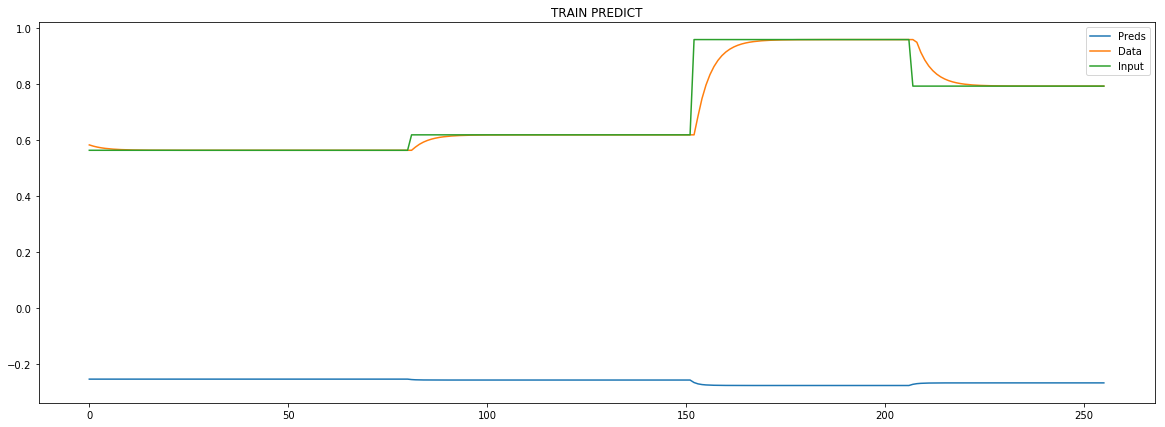

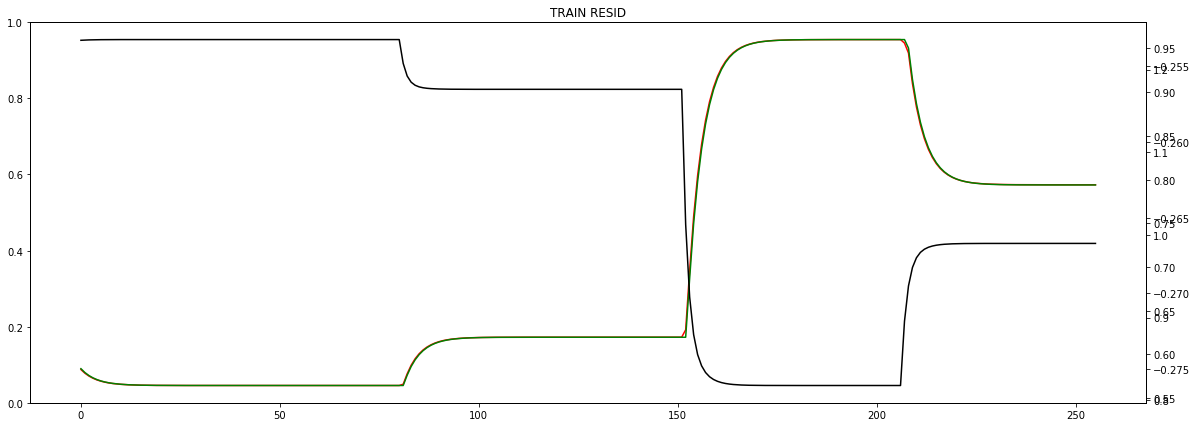


Parameter containing:
tensor([[0.4644, 1.0006]], requires_grad=True)


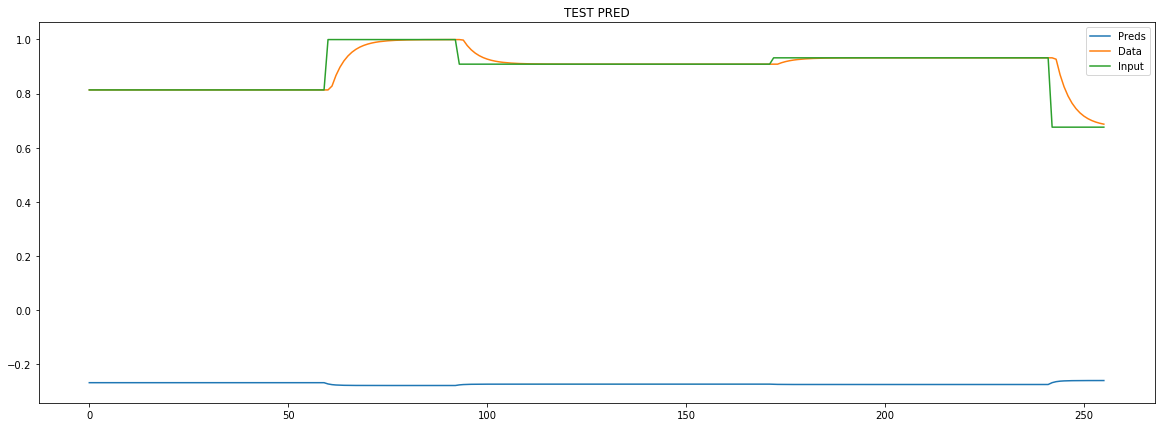

loss rate [0.34573515298643875]
Epoch [17] 
     train_loss[0.12107795744779565] 
     eval_train[0.10618868931418374] 
     eval_test[0.10697153913840819]



aux preds: 0.4798881709575653 1.0011080503463745
main loss 0.0
aux loss 0.10368821478138367
combined loss 0.10368821478138367 


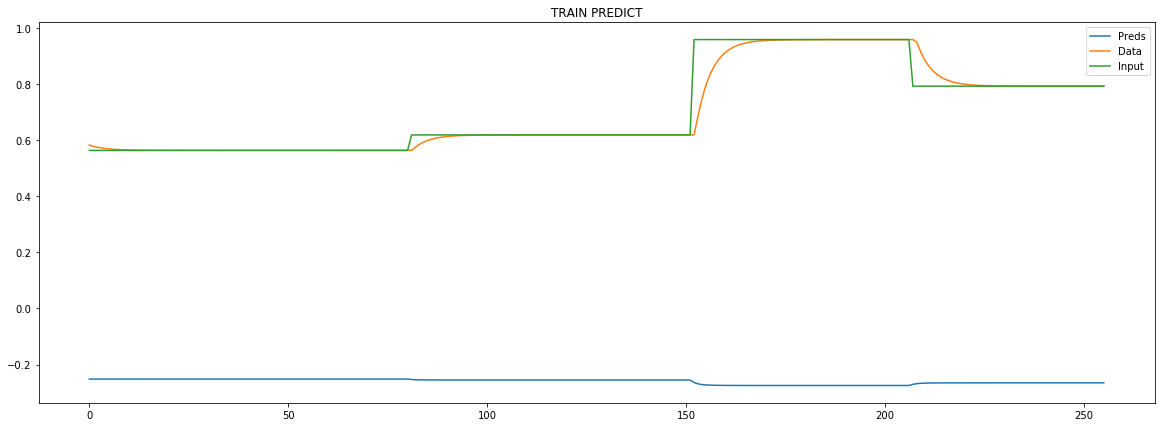

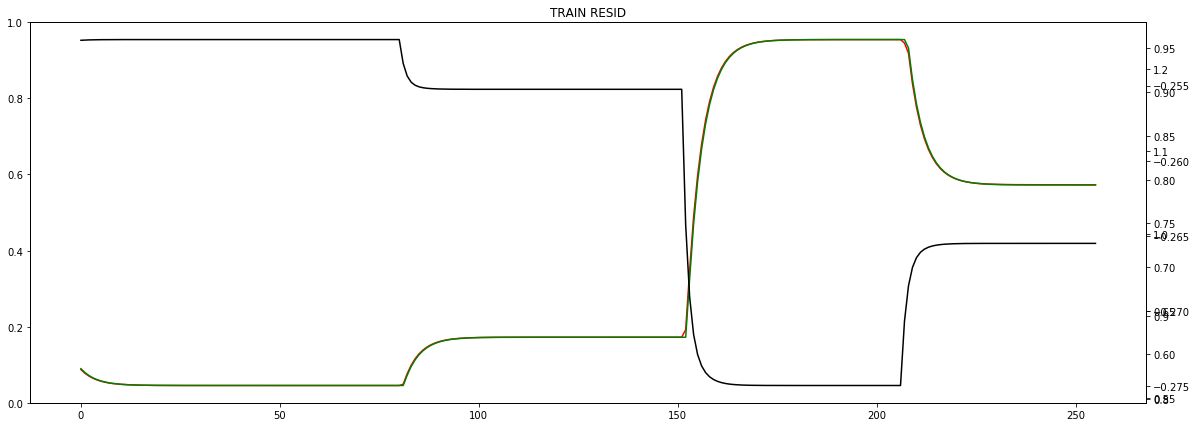


Parameter containing:
tensor([[0.4799, 1.0011]], requires_grad=True)


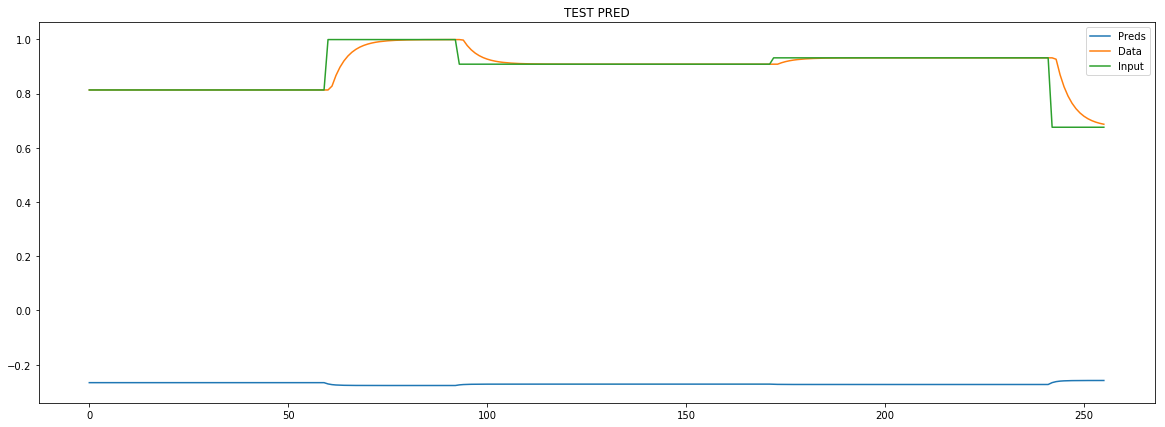

loss rate [0.2930018912322184]
Epoch [18] 
     train_loss[0.10368821478138367] 
     eval_train[0.09512993583366984] 
     eval_test[0.09579641321736775]



aux preds: 0.48297470808029175 1.0008076429367065
main loss 0.0
aux loss 0.09775931583273978
combined loss 0.09775931583273978 


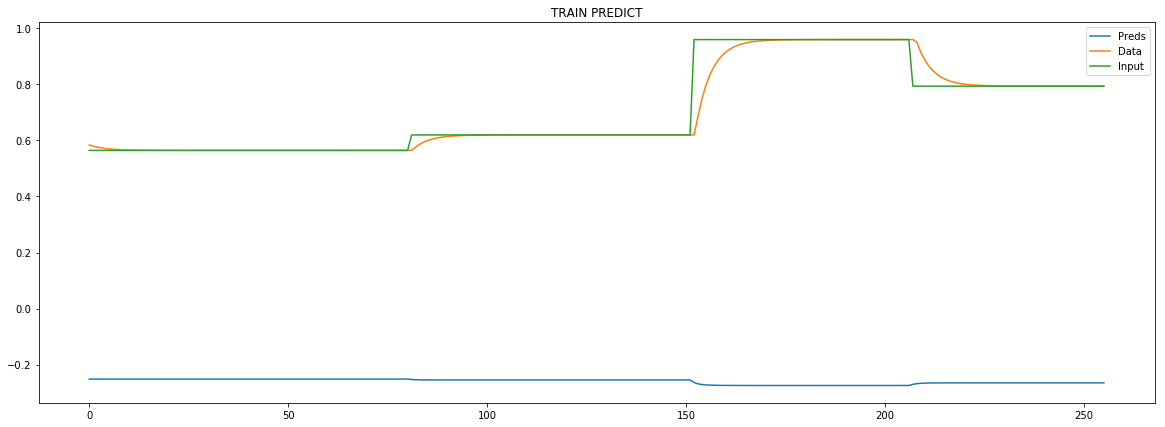

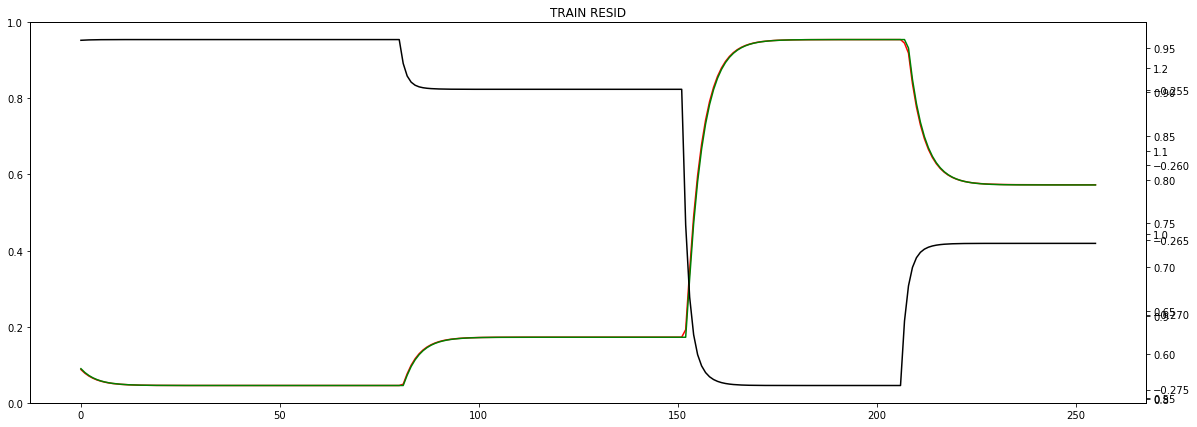


Parameter containing:
tensor([[0.4830, 1.0008]], requires_grad=True)


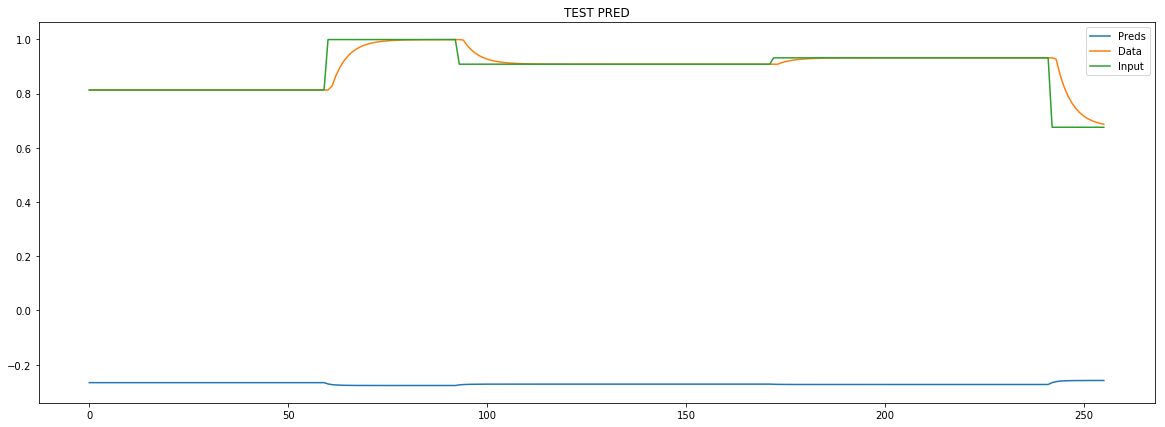

loss rate [0.19456205986587416]
Epoch [19] 
     train_loss[0.09775931583273978] 
     eval_train[0.09084643781451242] 
     eval_test[0.09148327125173607]



aux preds: 0.48228126764297485 0.9982792735099792
main loss 0.0
aux loss 0.09645527663330238
combined loss 0.09645527663330238 


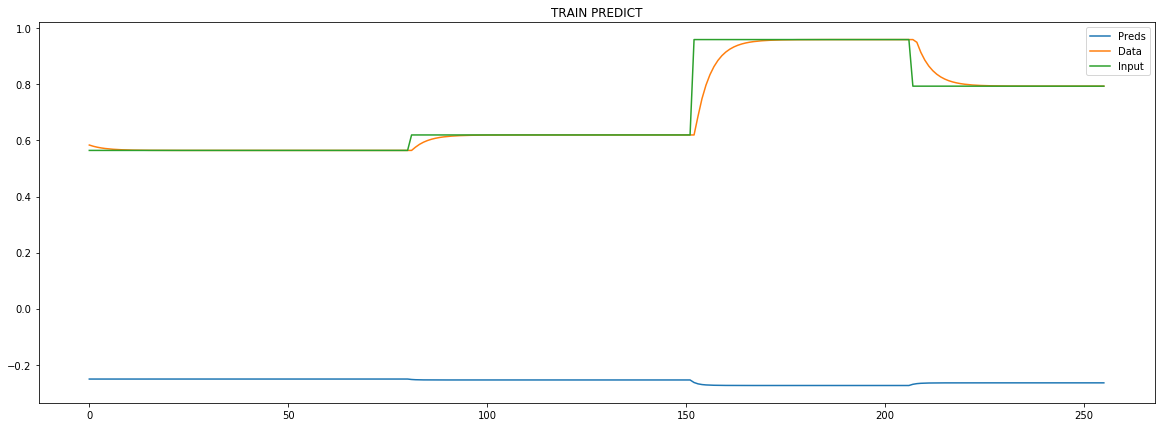

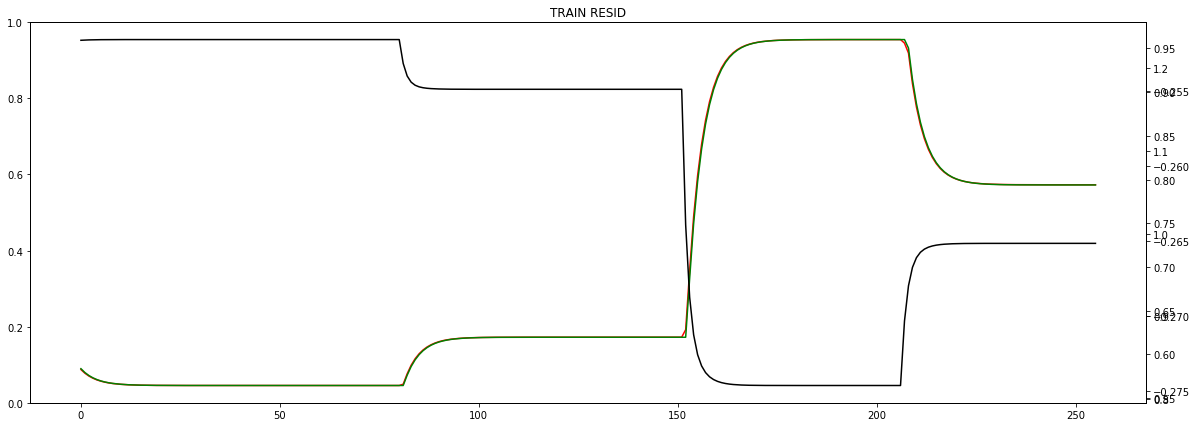


Parameter containing:
tensor([[0.4823, 0.9983]], requires_grad=True)


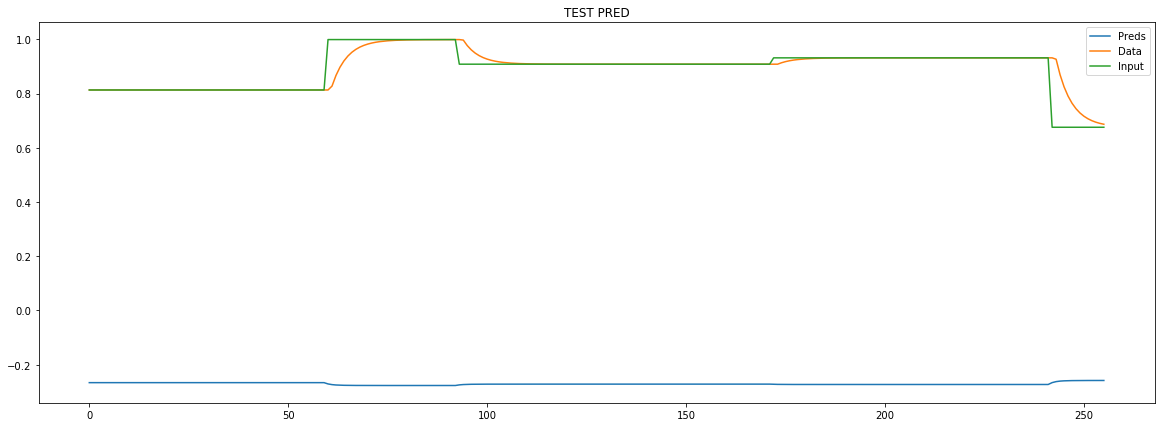

loss rate [-0.04729672573497057]
Epoch [20] 
     train_loss[0.09645527663330238] 
     eval_train[0.10207264520050514] 
     eval_test[0.10272278100921867]



aux preds: 0.4818585216999054 0.9996695518493652
main loss 0.0
aux loss 0.09410991785781724
combined loss 0.09410991785781724 


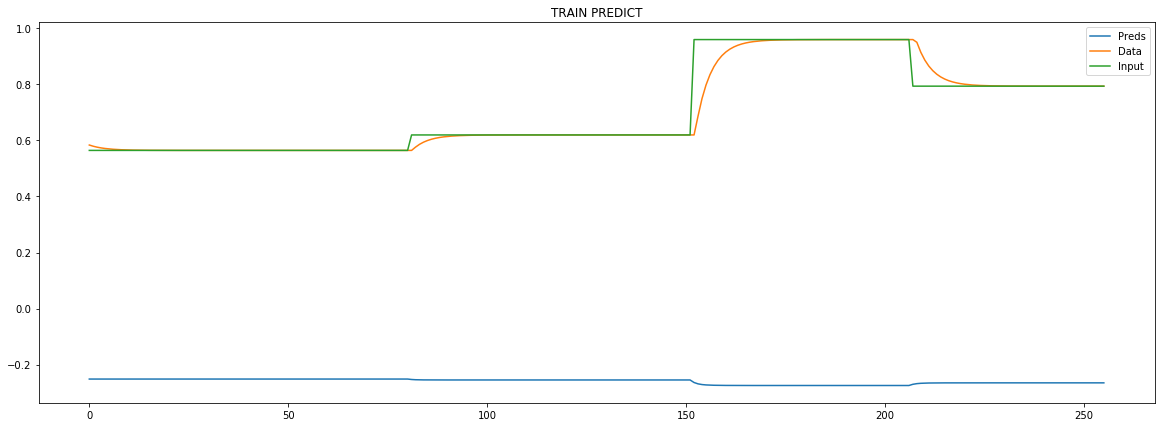

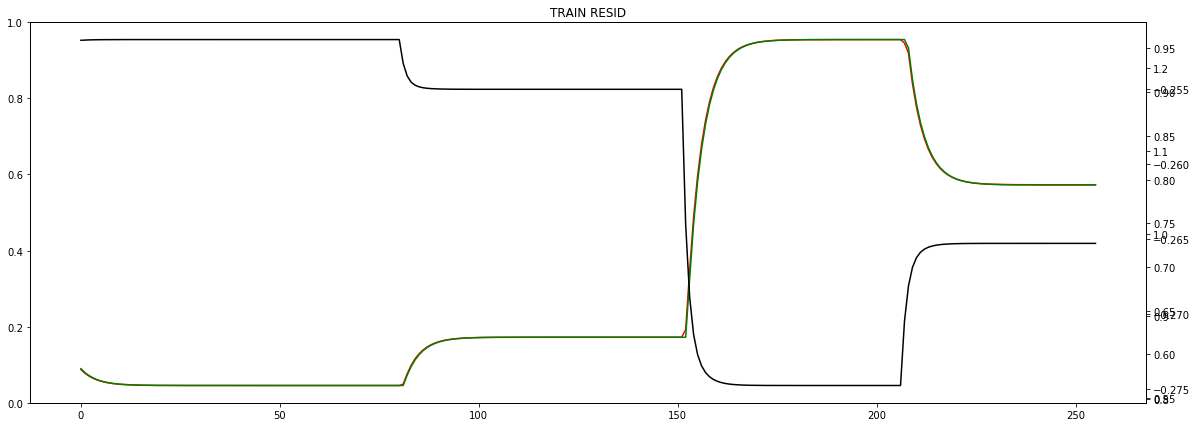


Parameter containing:
tensor([[0.4819, 0.9997]], requires_grad=True)


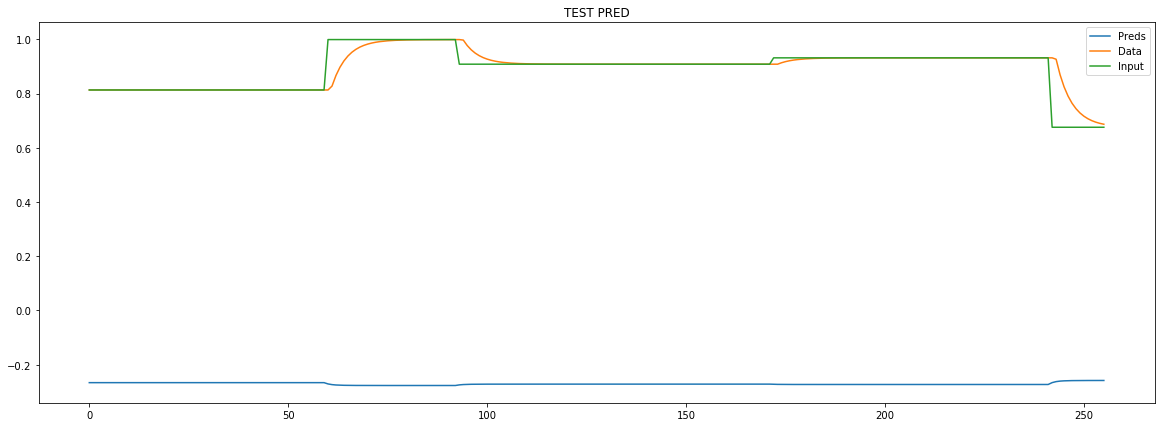

loss rate [0.11156628435996496]
Epoch [21] 
     train_loss[0.09410991785781724] 
     eval_train[0.08525235675097931] 
     eval_test[0.08588265598322568]



aux preds: 0.4820702075958252 0.9999353289604187
main loss 0.0
aux loss 0.09409973417364416
combined loss 0.09409973417364416 


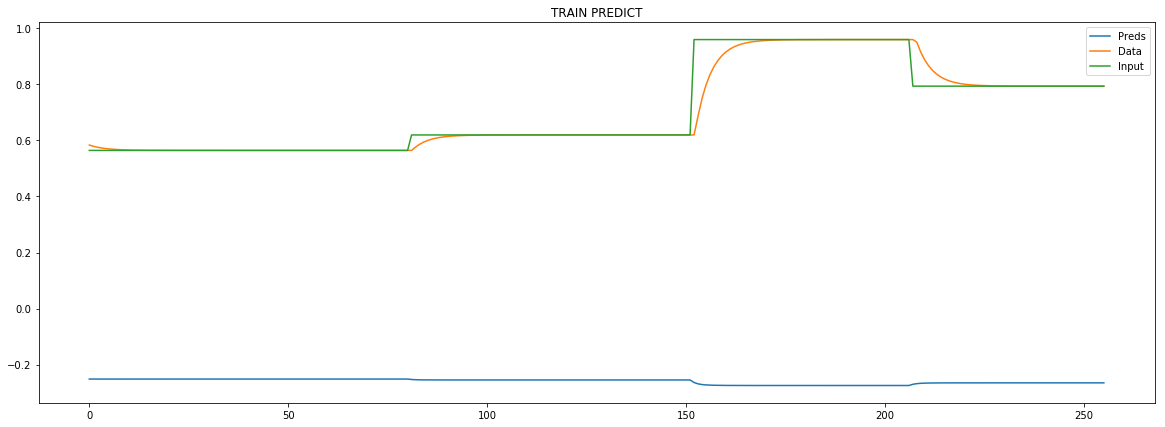

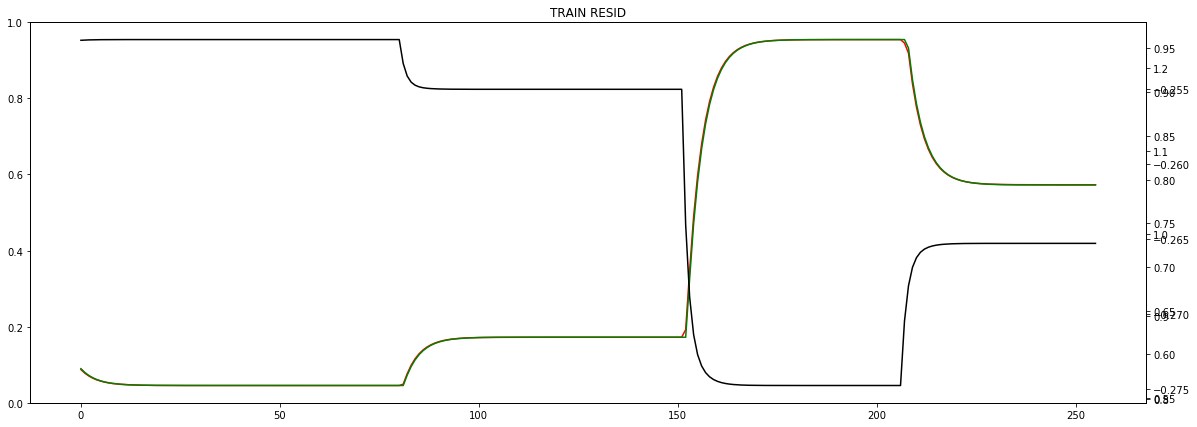


Parameter containing:
tensor([[0.4821, 0.9999]], requires_grad=True)


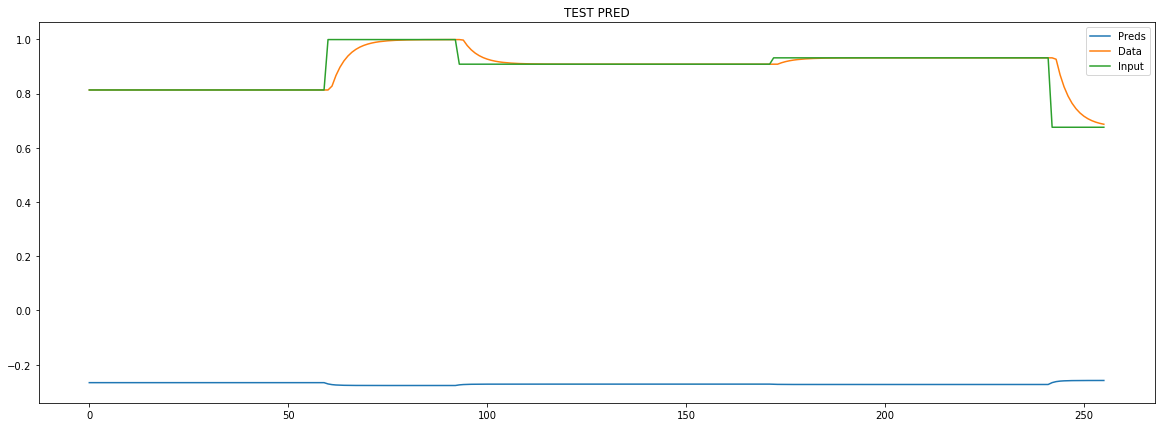

loss rate [0.1088496236655]
Epoch [22] 
     train_loss[0.09409973417364416] 
     eval_train[0.0825802105966778] 
     eval_test[0.08320038591961512]



aux preds: 0.4815164804458618 1.000611662864685
main loss 0.0
aux loss 0.09139529764652252
combined loss 0.09139529764652252 


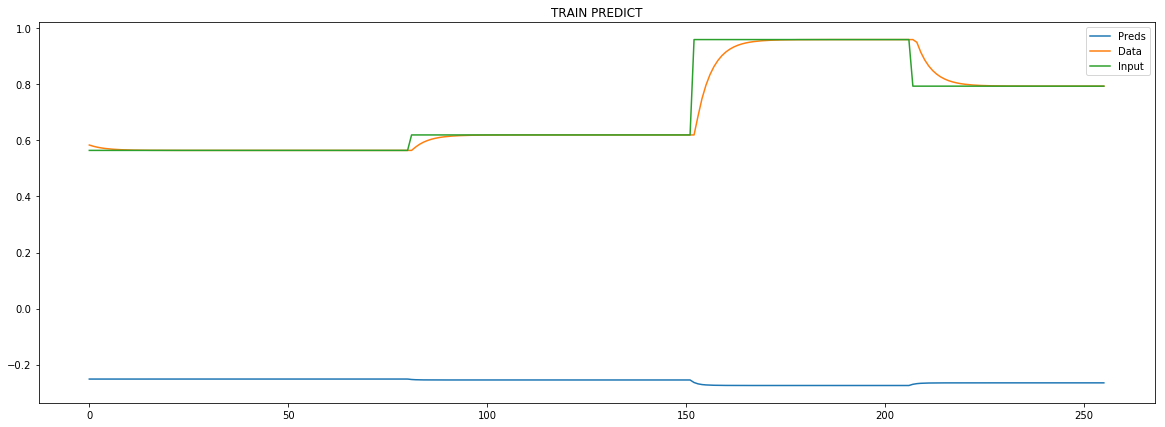

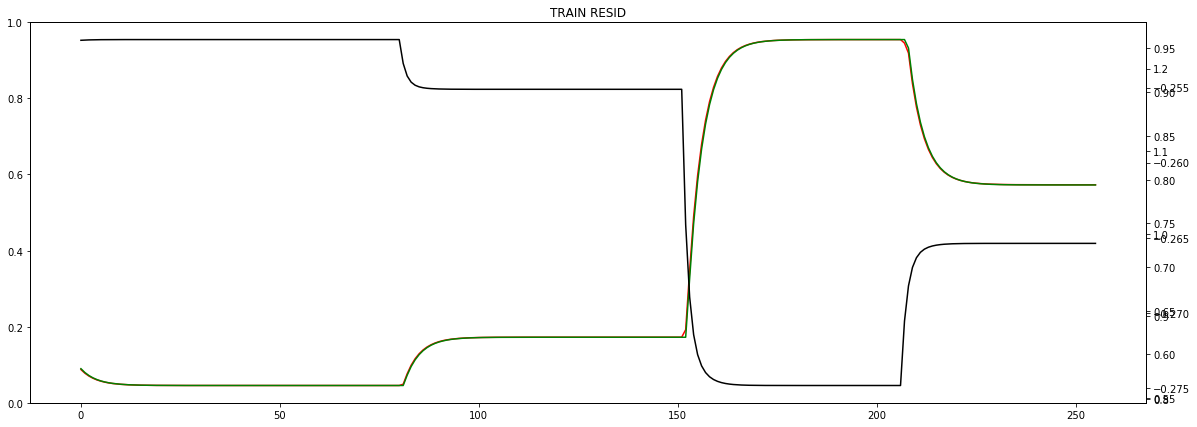


Parameter containing:
tensor([[0.4815, 1.0006]], requires_grad=True)


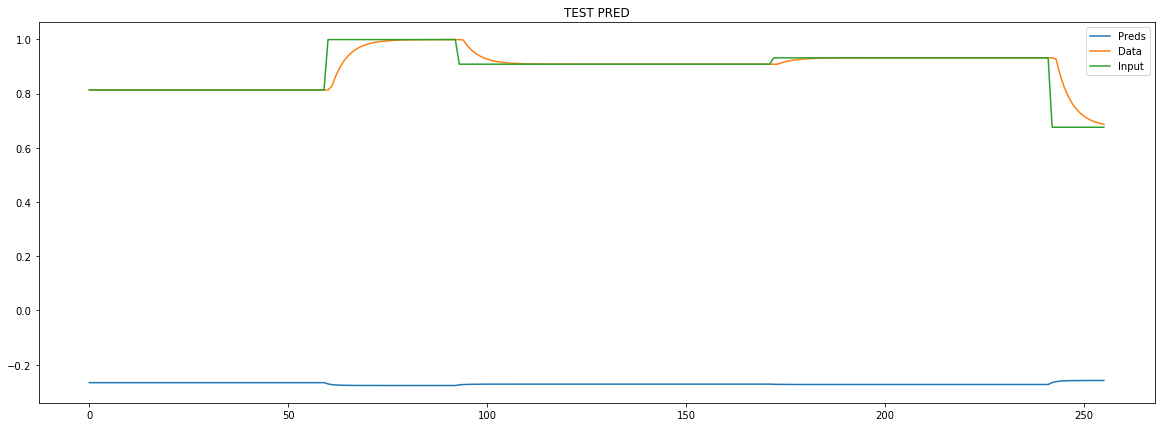

loss rate [0.01783693219672222]
Epoch [23] 
     train_loss[0.09139529764652252] 
     eval_train[0.08835350860442434] 
     eval_test[0.08898588029270092]



aux preds: 0.48228713870048523 1.0013761520385742
main loss 0.0
aux loss 0.09428093790830601
combined loss 0.09428093790830601 


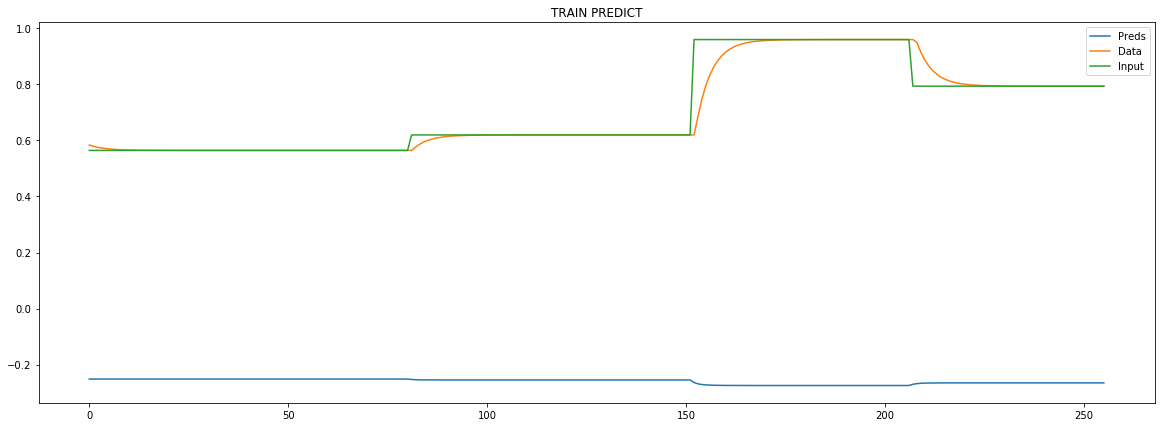

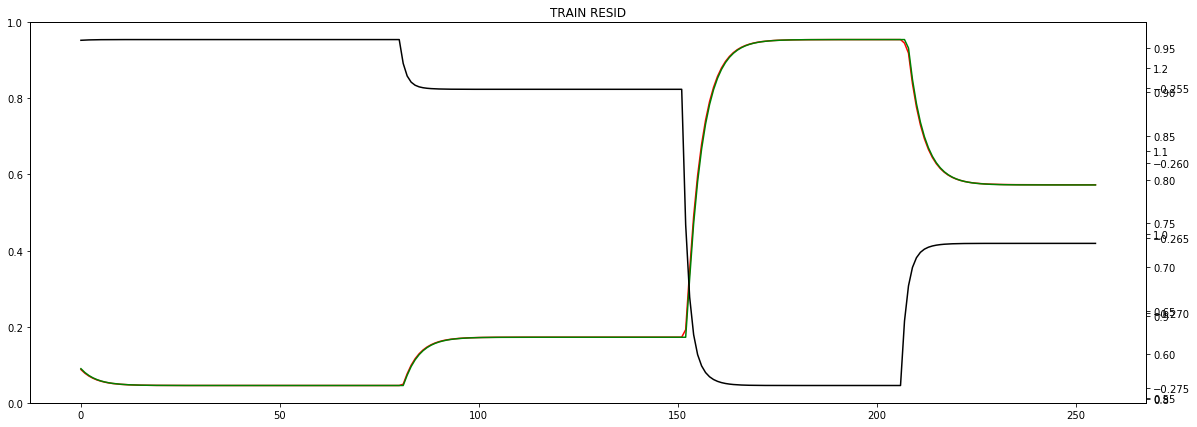


Parameter containing:
tensor([[0.4823, 1.0014]], requires_grad=True)


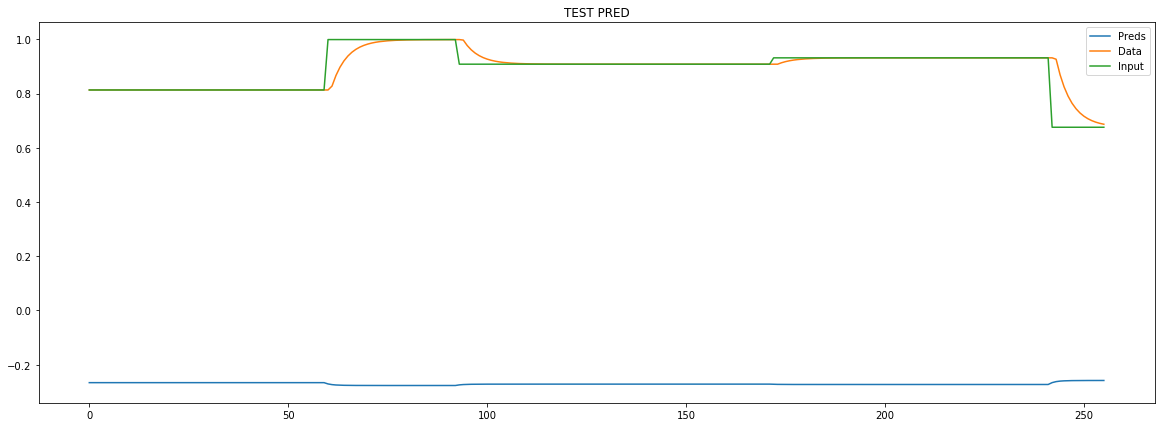

Epoch    24: reducing learning rate of group 0 to 1.0000e-03.
loss rate [-0.14434262344334226]
Epoch [24] 
     train_loss[0.09428093790830601] 
     eval_train[0.09781170042142981] 
     eval_test[0.09843975581814733]



aux preds: 0.4807945191860199 1.0000001192092896
main loss 0.0
aux loss 0.08329147705364795
combined loss 0.08329147705364795 


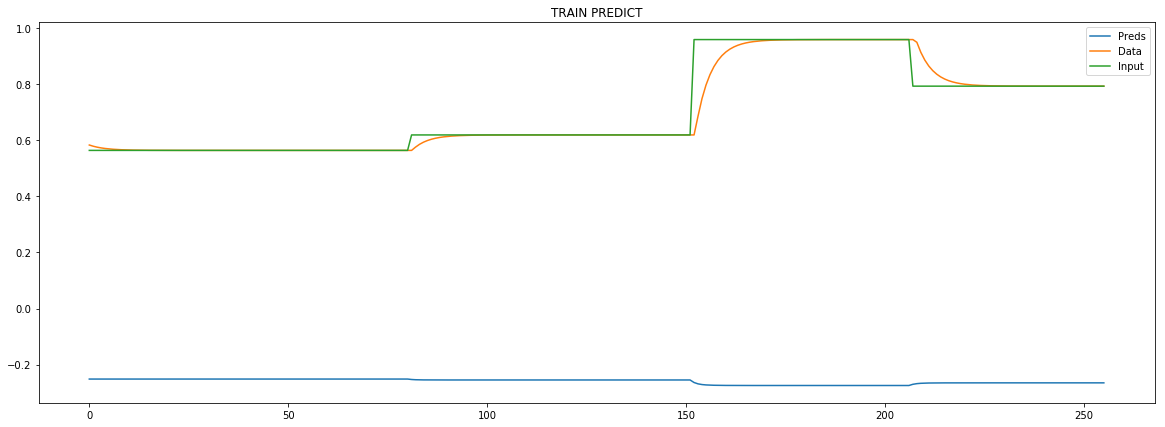

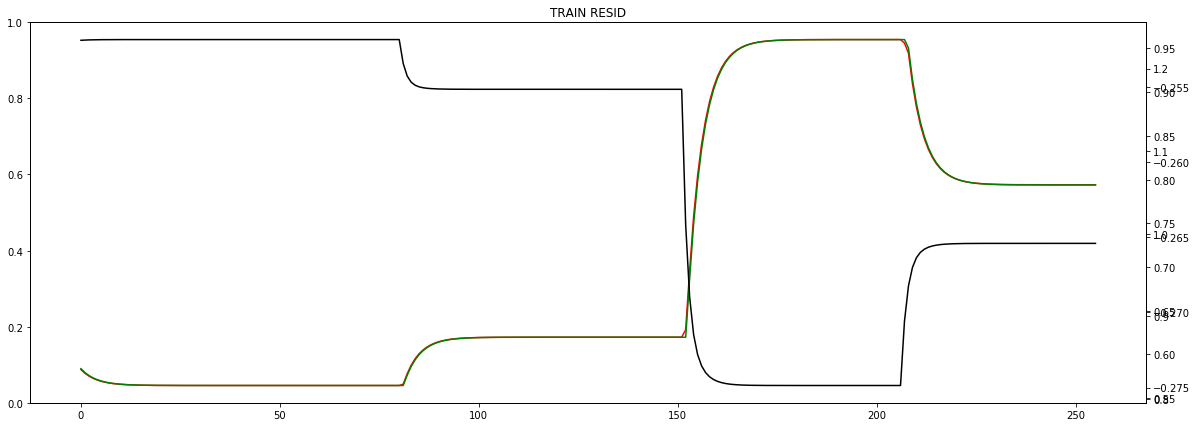


Parameter containing:
tensor([[0.4808, 1.0000]], requires_grad=True)


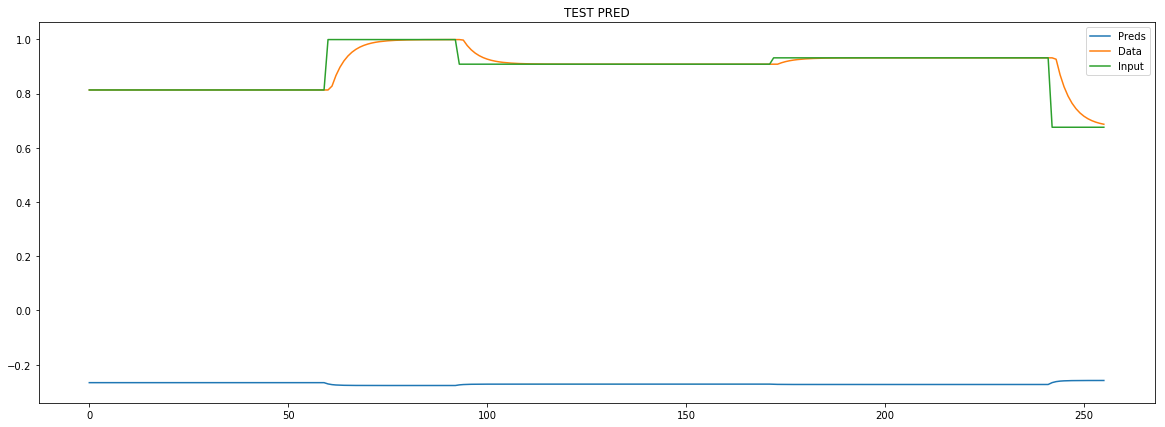

loss rate [0.09256270735466343]
Epoch [25] 
     train_loss[0.08329147705364795] 
     eval_train[0.08123427931928918] 
     eval_test[0.0818587149169003]



aux preds: 0.4805868864059448 0.9998152256011963
main loss 0.0
aux loss 0.08203440298814149
combined loss 0.08203440298814149 


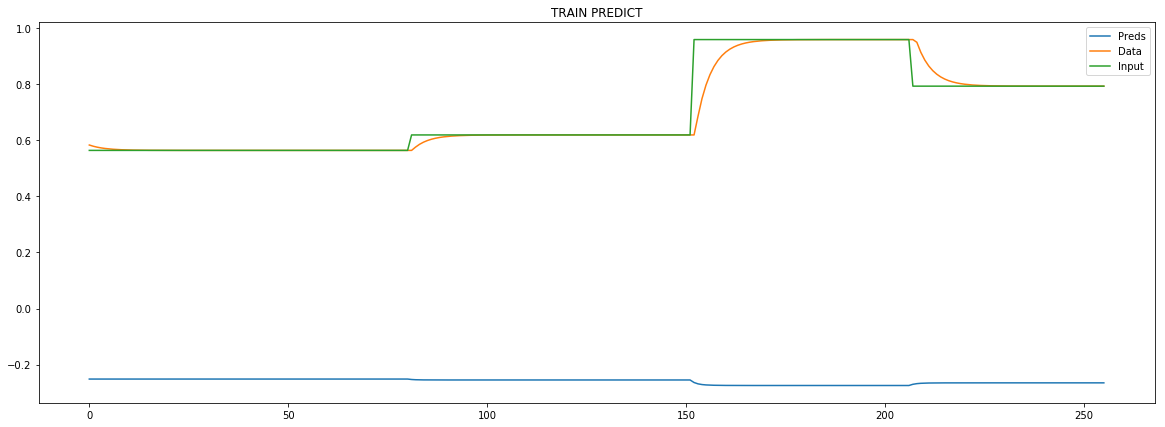

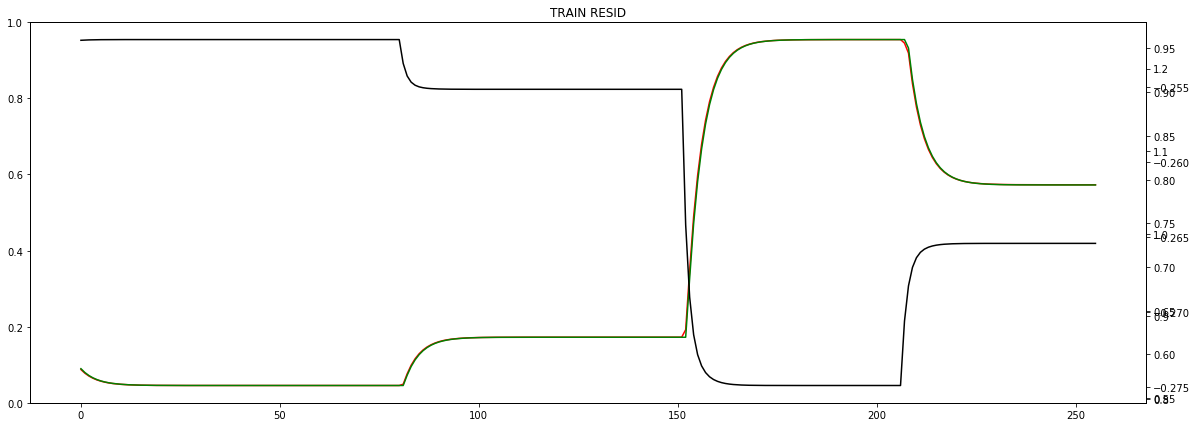


Parameter containing:
tensor([[0.4806, 0.9998]], requires_grad=True)


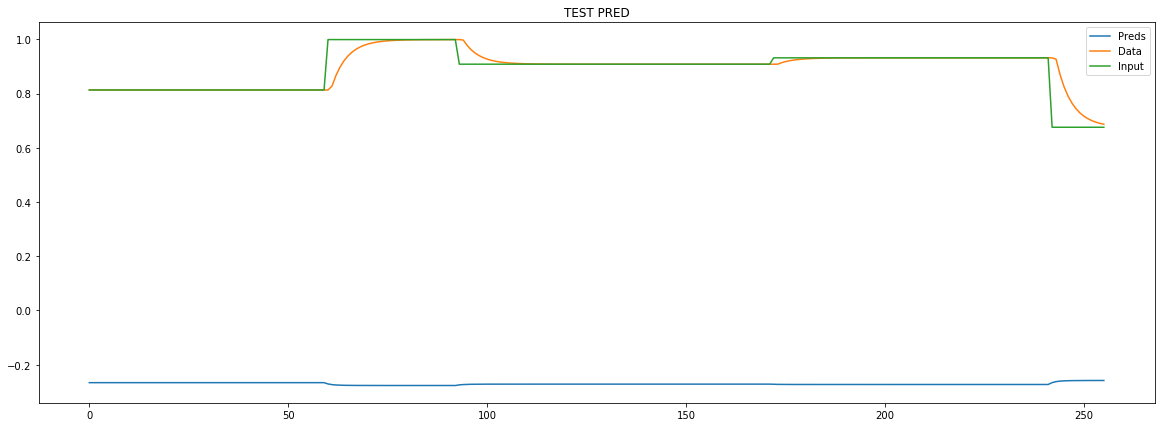

loss rate [0.06443898597397746]
Epoch [26] 
     train_loss[0.08203440298814149] 
     eval_train[0.08334872543900496] 
     eval_test[0.08397731350295329]



aux preds: 0.480541855096817 0.9998000860214233
main loss 0.0
aux loss 0.0821588283404708
combined loss 0.0821588283404708 


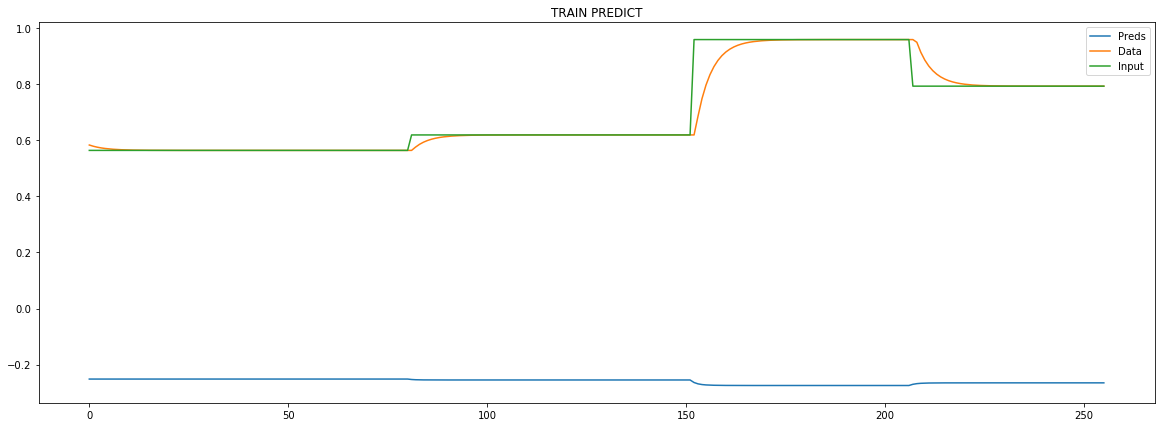

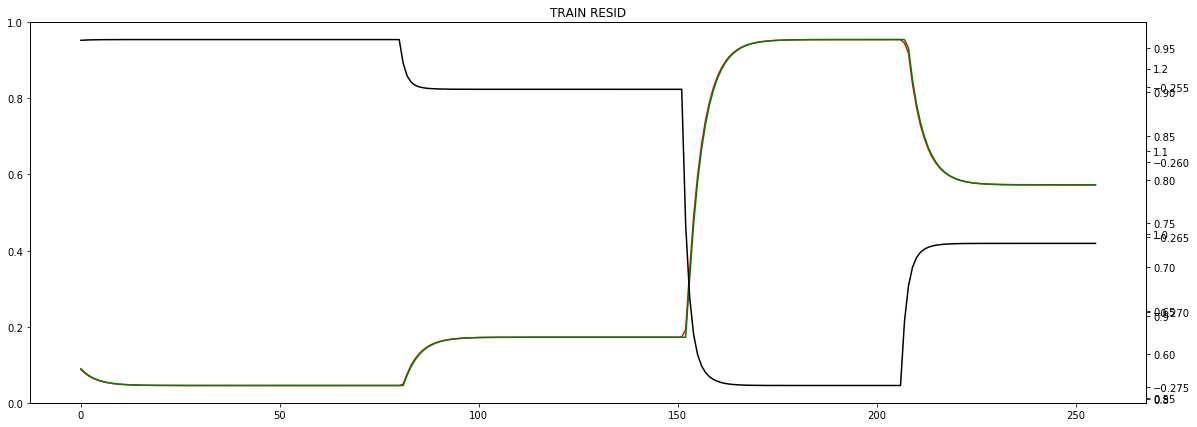


Parameter containing:
tensor([[0.4805, 0.9998]], requires_grad=True)


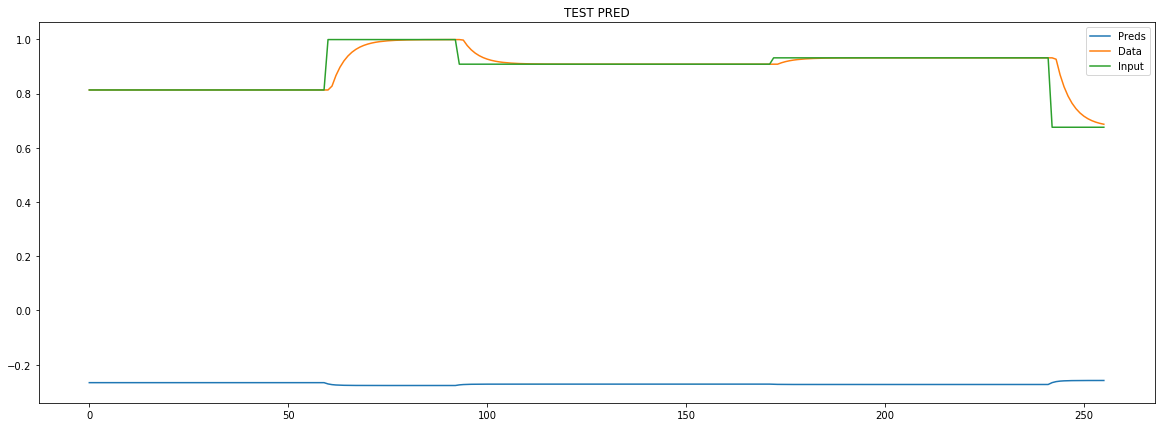

loss rate [0.04437934473220495]
Epoch [27] 
     train_loss[0.0821588283404708] 
     eval_train[0.08355415101562227] 
     eval_test[0.08418246603497628]



aux preds: 0.4806050956249237 1.0002354383468628
main loss 0.0
aux loss 0.08238529179333931
combined loss 0.08238529179333931 


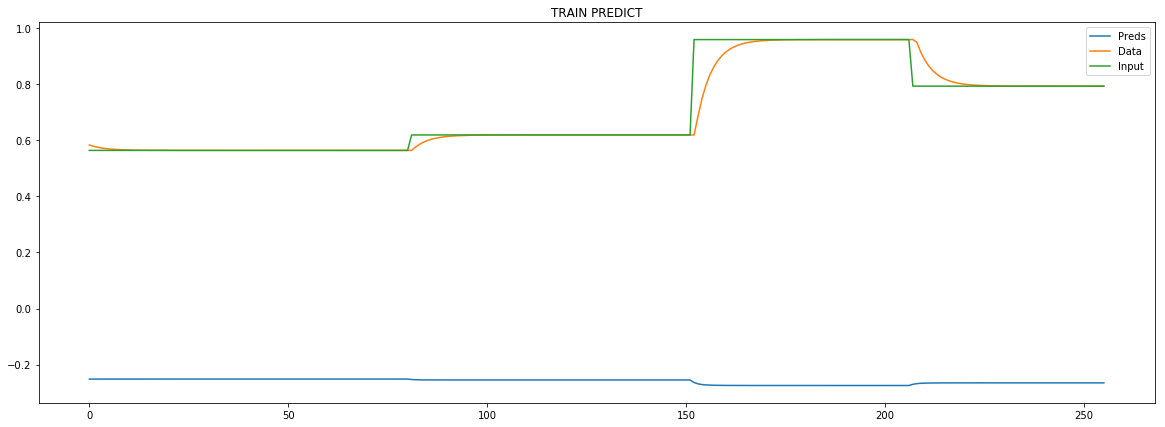

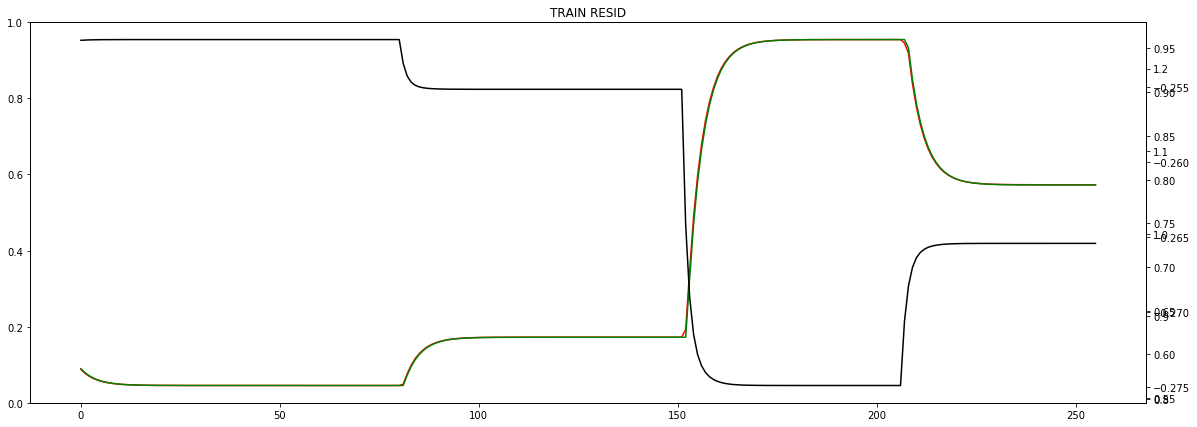


Parameter containing:
tensor([[0.4806, 1.0002]], requires_grad=True)


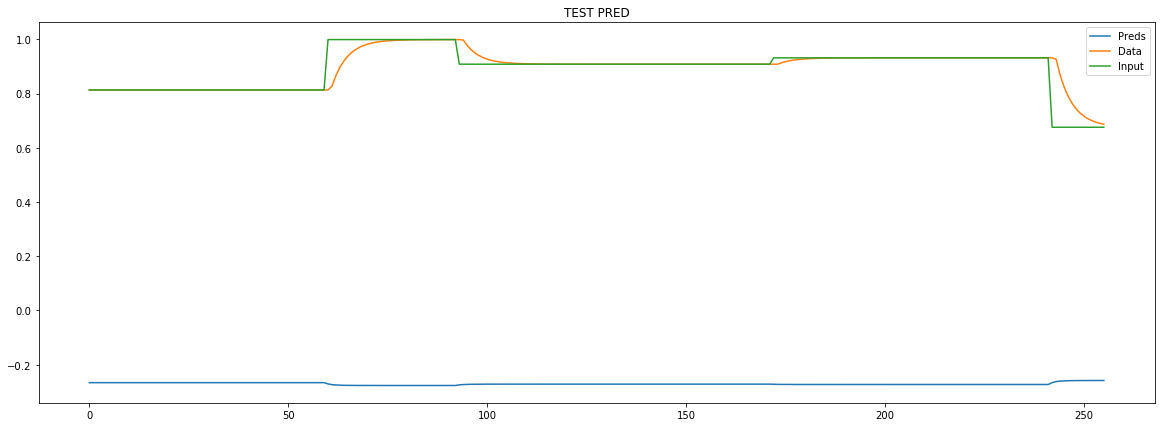

loss rate [-0.013026311636941346]
Epoch [28] 
     train_loss[0.08238529179333931] 
     eval_train[0.08379617332525197] 
     eval_test[0.08442510442619913]



aux preds: 0.4805413484573364 0.9999924302101135
main loss 0.0
aux loss 0.08204791250505618
combined loss 0.08204791250505618 


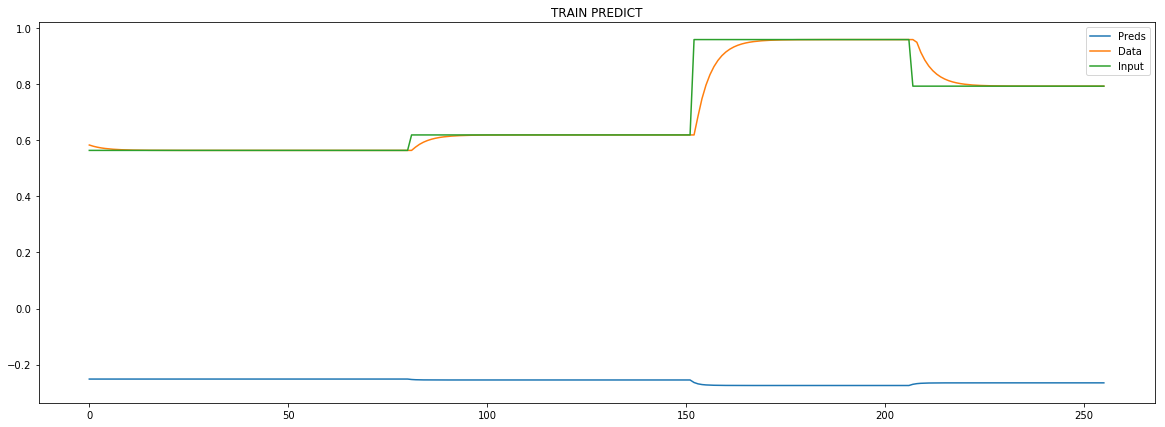

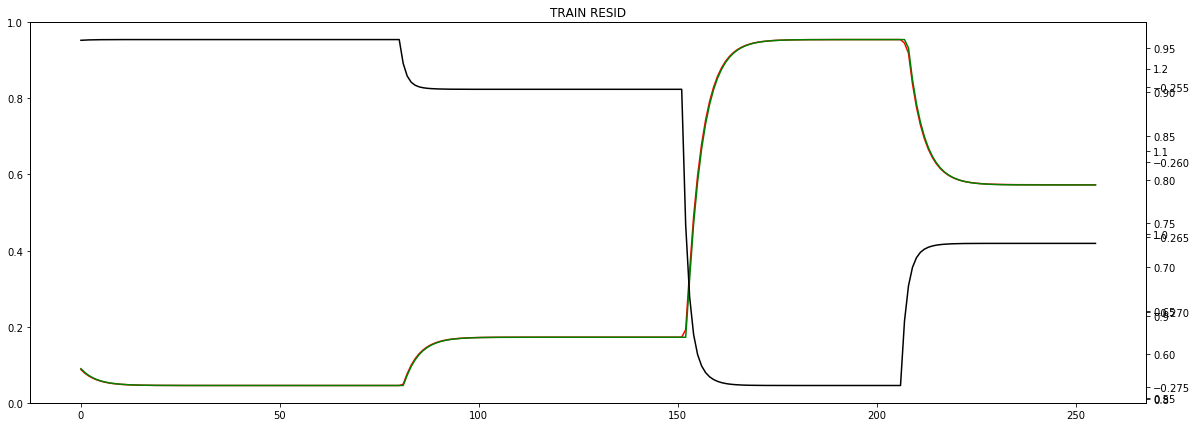


Parameter containing:
tensor([[0.4805, 1.0000]], requires_grad=True)


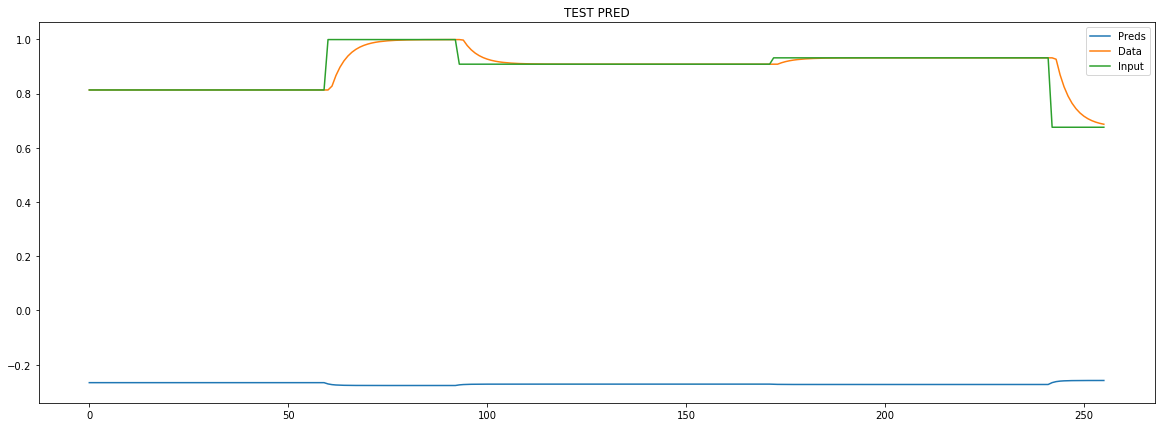

loss rate [0.028492449309072798]
Epoch [29] 
     train_loss[0.08204791250505618] 
     eval_train[0.08116964074738678] 
     eval_test[0.08179604065384757]



aux preds: 0.4806109666824341 1.0001968145370483
main loss 0.0
aux loss 0.08235917082943377
combined loss 0.08235917082943377 


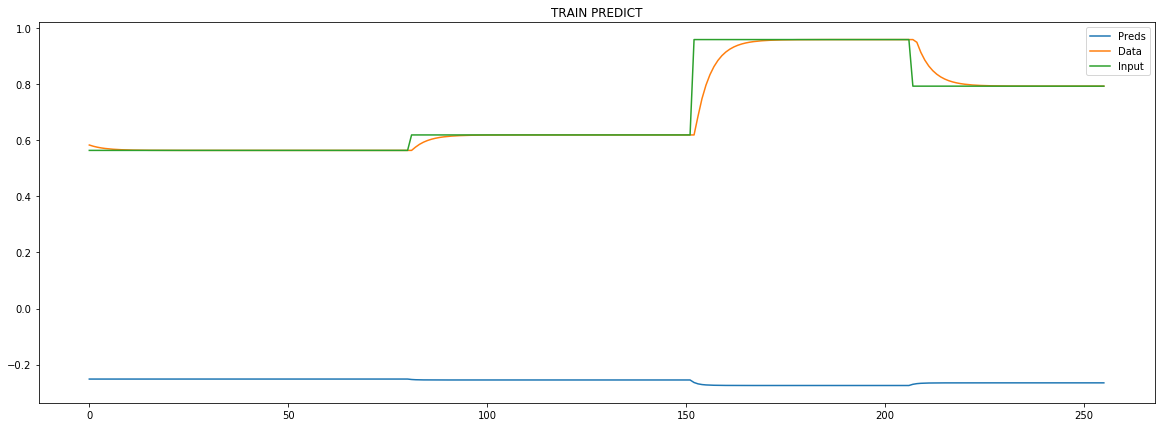

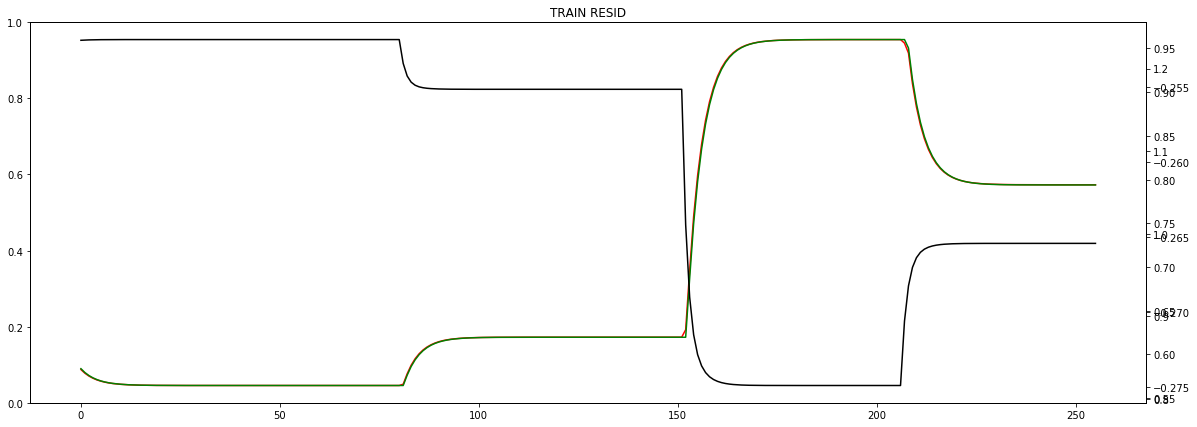

KeyboardInterrupt: 

In [18]:
logging.info("Training process STARTED")

model.hidden = model.init_hidden()



for t in range(num_epochs):
    
    batch_local_hist = hist["train"]["batches"]
    long_term_hist = hist["train"]["epochs"]
    
    for i, data in enumerate(tqdm(train_dl)):
        
        model.hidden = model.init_hidden()
        
        y_pred, jordan = batch_iteration(
            iter_index=i,
            model=model,
            optimizer=optimizer,
            batch_data=data,
            backprop=True,
            hist_part=batch_local_hist
        )
        
    hist['mean_params_sample']['1'][t] = jordan[:, 0]
    hist['mean_params_sample']['2'][t] = jordan[:, 1]
    
    print(f"aux preds: {hist['mean_params_sample']['1'][t]} {hist['mean_params_sample']['2'][t]}")
    
    mean_losses = update_long_term_hist(batches_hist=batch_local_hist,
                                                            long_term_hist=long_term_hist)
    mean_main, mean_aux = mean_losses
    # TODO add w8 decay
    print(f"main loss {mean_main}")
    print(f"aux loss {mean_aux}")
    print(f"combined loss {sum(mean_losses)} ")
    
    # VISUALISE TRAINING PROGRESS
    x_batch, y_batch, indexes = data
    plot_shared_scale([
        (y_pred[:, 0].detach().numpy(),"Preds" ),
         (y_batch[:, 0].detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")
        ],
        title="TRAIN PREDICT")
          
    residuals = y_batch[:, 0] - y_pred[:, 0]
    plot_multiscale([
        (residuals.detach().numpy(), "Red"),
        (y_batch[:, 0].detach().numpy(), "Green"),
        (y_pred[:, 0].detach().numpy(), "Black")
    ],
        title="TRAIN RESID"
    ) 
    # /VISUALISE TRAINING PROGRESS

    # EVAL
    with torch.no_grad():
          
          model = model.eval()
          
          for i, data in enumerate(tqdm(train_dl)):
              batch_local_hist = hist['eval_train']['batches']
              long_term_hist=hist["eval_train"]["epochs"]
              y_pred, jordan = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          
          for i, data in enumerate(tqdm(test_dl)):
              batch_local_hist = hist['eval_test']['batches']
              long_term_hist=hist["eval_test"]["epochs"]
          
              y_pred_test, jordan = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          model = model.train()
    # /EVAL
          
    # VISUALISE ITERATION PRED
    x_batch_test, y_batch_test, indexes = data
    print(jordan)
          
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(),"Preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )
    # /VISUALISE ITERATION PRED
    
    visualise_resid = False
    if visualise_resid:
        residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
        plot_multiscale(
                [
                 (residuals.detach().numpy(), "Red"), 
                 (y_batch_test[:, 0].detach().numpy(),"Green")
                ],
            title = 'TEST RESID'
        )
    
    
    # UPDATE LR
    val_loss = slice_loss_sum(hist['eval_test']['epochs'], t)
    scheduler.step(val_loss)
    hist['weights_sum'][t] = torch.as_tensor([p.sum() for p in model.parameters(recurse=True)]).sum().item()
    hist['weights_var'][t] = torch.as_tensor([p.var() for p in model.parameters(recurse=True)]).sum().item()
    
    hist['lr'][t] = scheduler.optimizer.param_groups[0]['lr']
    if hist['lr'][t] <= 10**p_sched['early_stop_order'] * 1.0001: # 1+eps 
          print("Loss critically low, EARLY STOPPING")
          break
    if t > 3:
          h = hist["eval_test"]["epochs"]
          loss_rate = 1 - slice_loss_sum(h, t) / np.mean([slice_loss_sum(h, k) for k in range(t-3,t)])          
          hist['loss_rate'][t] = loss_rate              
          print(f"loss rate [{loss_rate}]")
    # /UPDATE LR
                       
    # FINAL PROGRESS LOGGING
    msg = "Epoch [{t}] \n \
    train_loss[{train_loss}] \n \
    eval_train[{eval_train}] \n \
    eval_test[{eval_test}]".format(t=t,
                                train_loss=sum([val[t] for val in hist['train']['epochs'].values()]), 
                                eval_train=sum([val[t] for val in hist['eval_train']['epochs'].values()]),
                                eval_test=sum([val[t] for val in hist['eval_test']['epochs'].values()])
                               )
    print(msg)
    logging.info(msg)
                       
    # /FINAL PROGRESS LOGGING

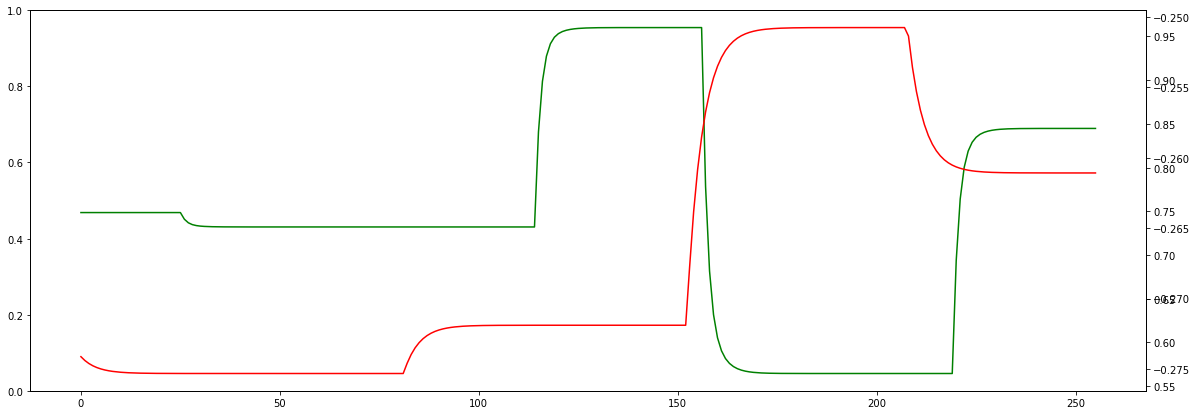

In [33]:
plot_multiscale(
[
(y_pred.detach().numpy(), 'green'),
(y_batch.detach().numpy(), 'red')   
]
)

In [98]:
check_y, jordan = model(x_batch)

In [103]:
jordan.

tensor([[-0.0268, 11.0694]])

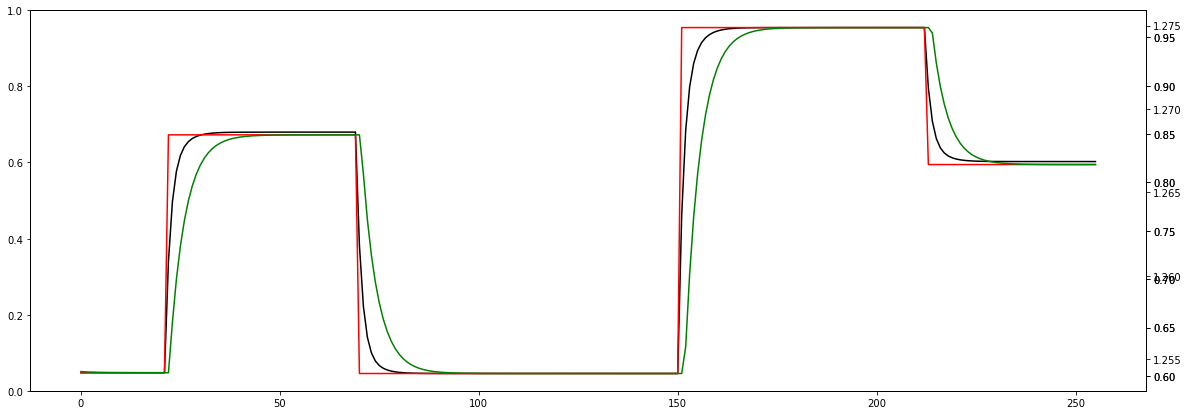

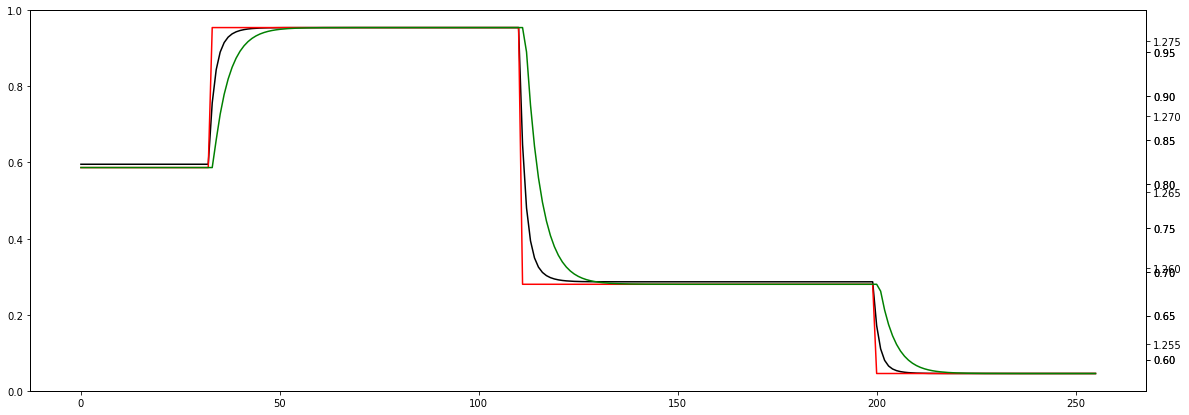

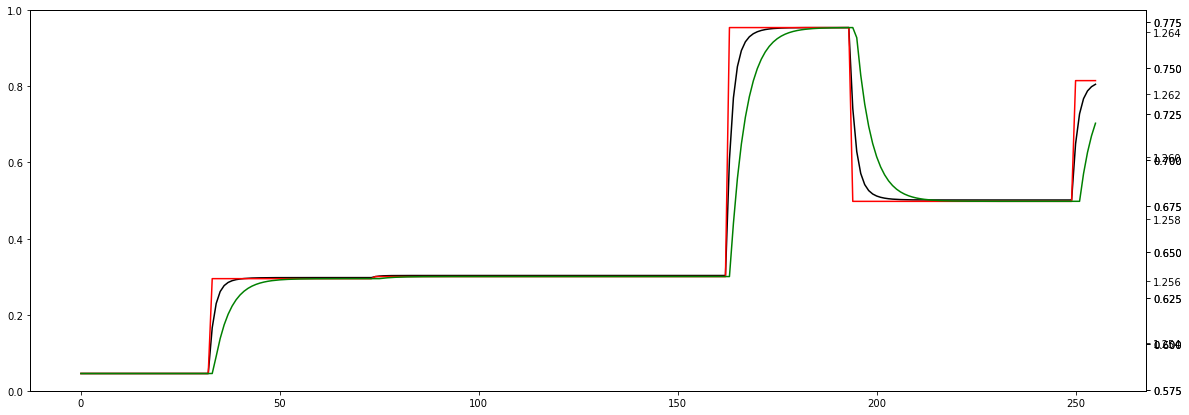

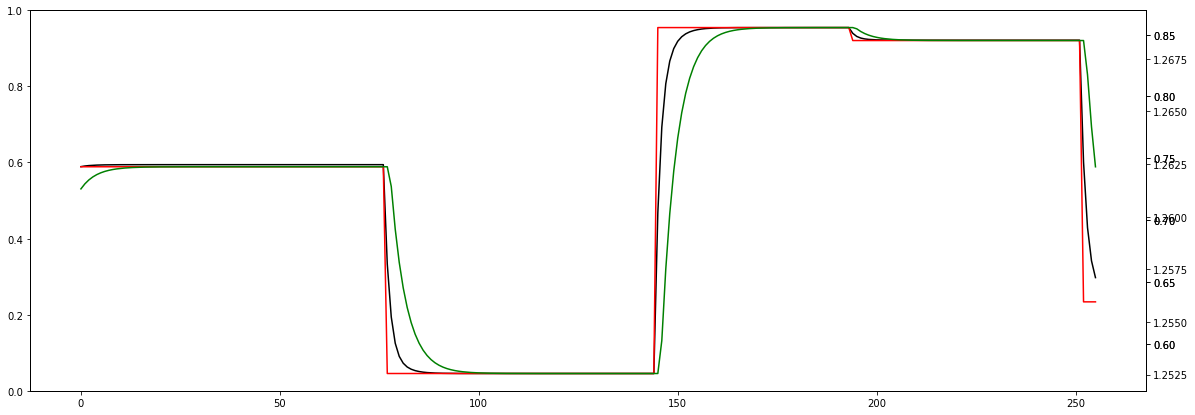

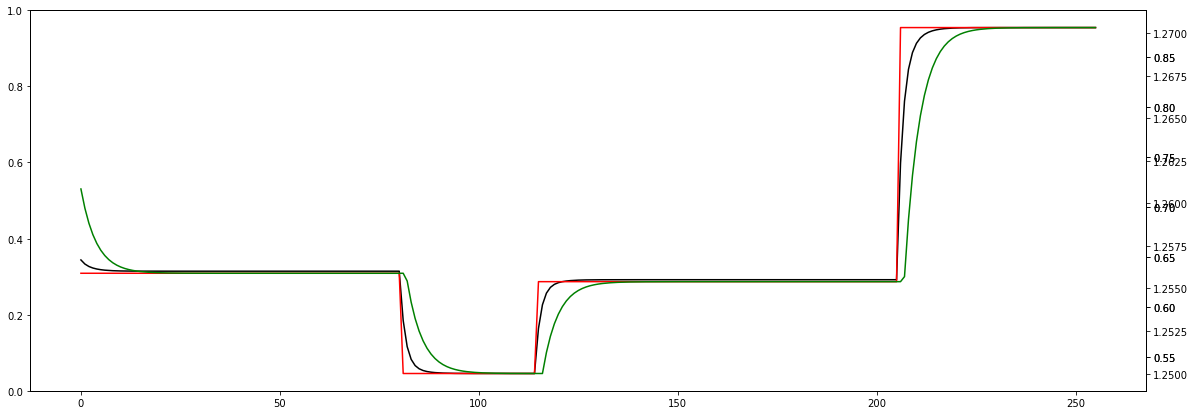

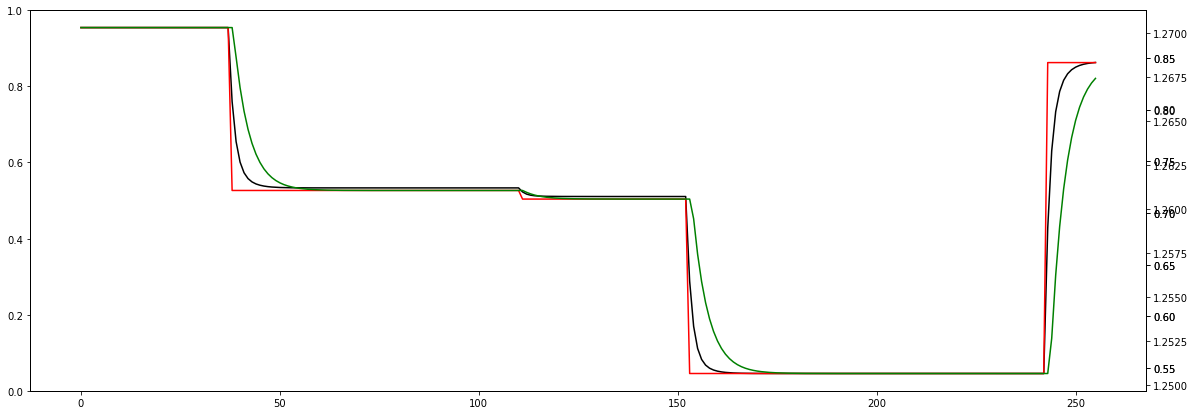

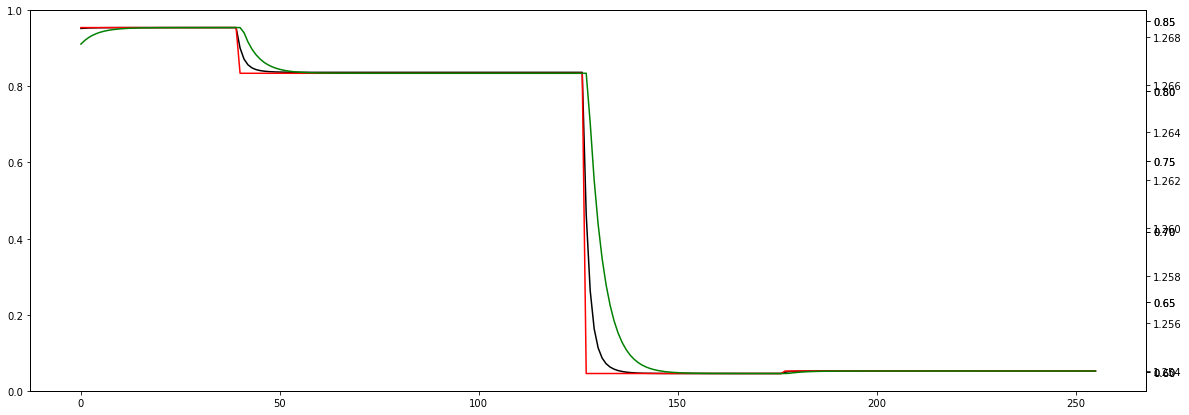

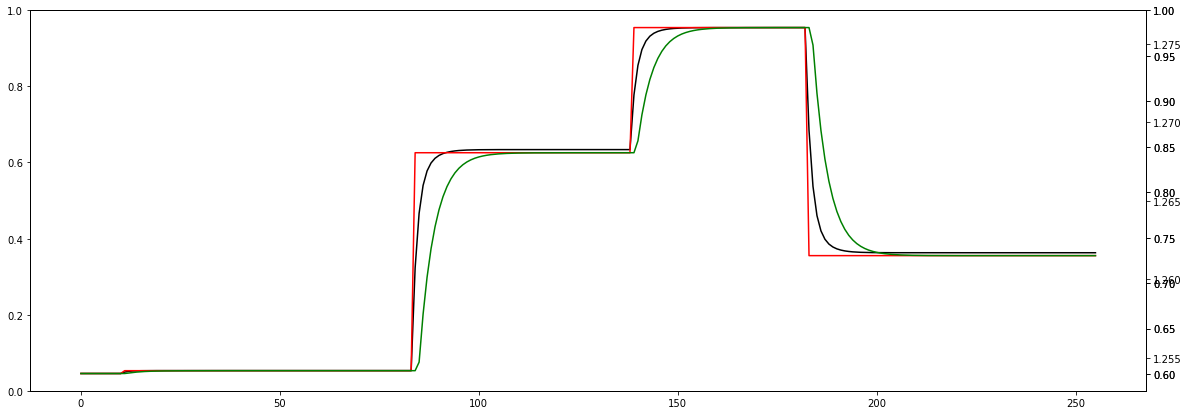

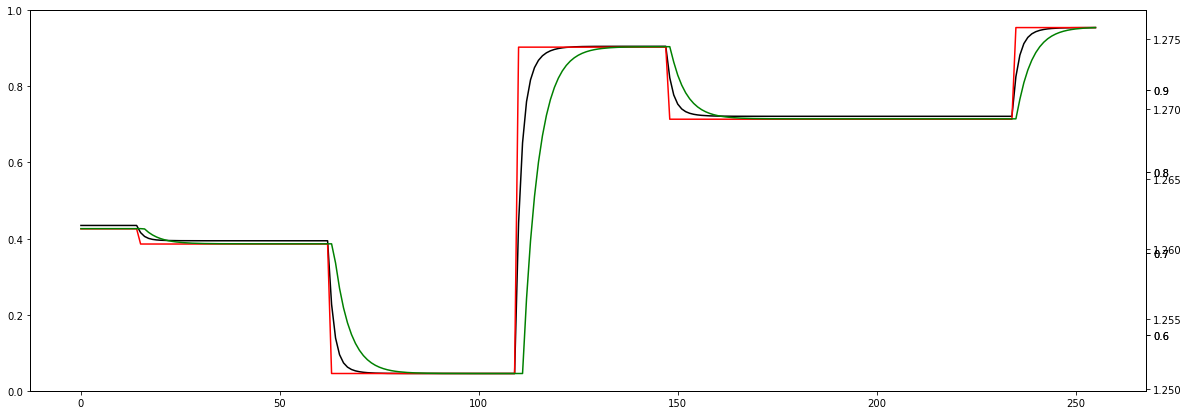

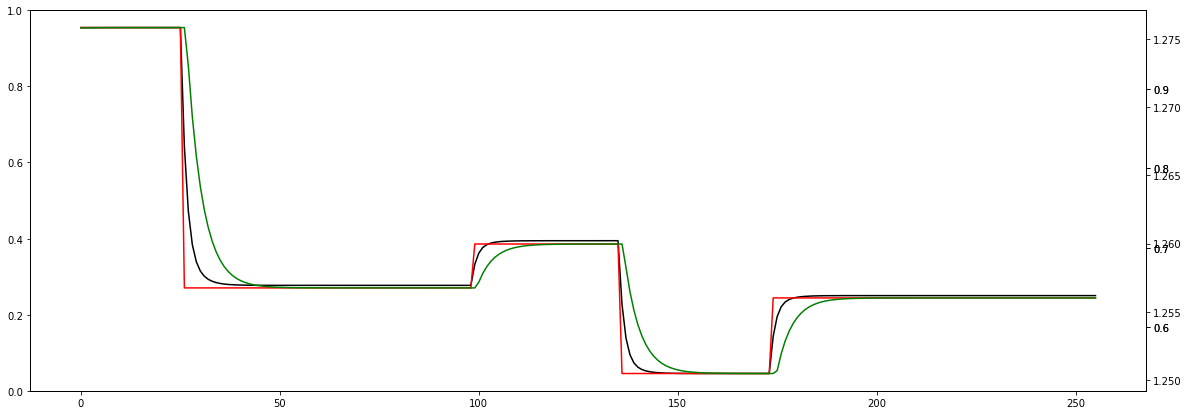

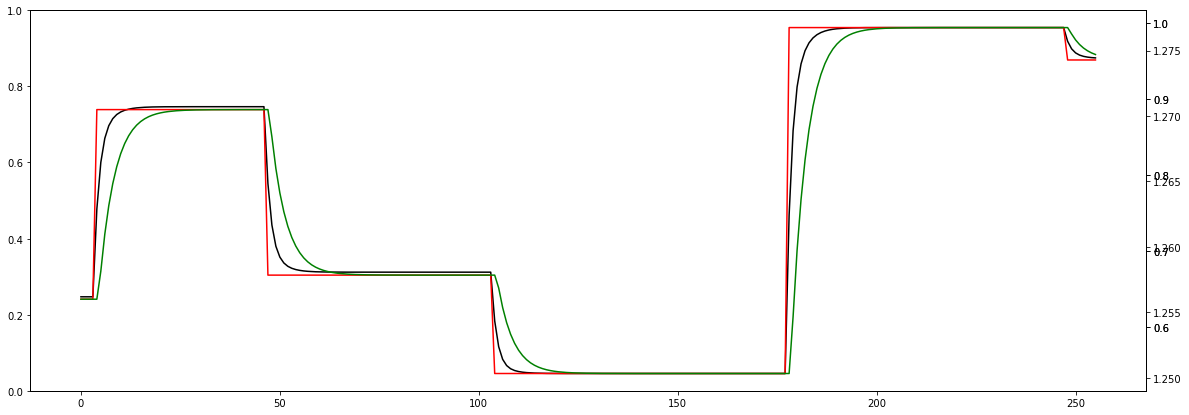

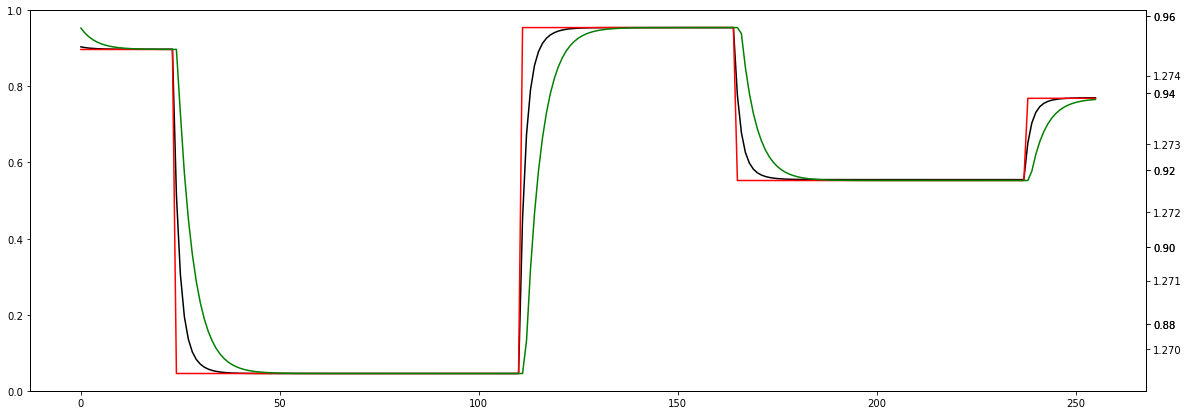

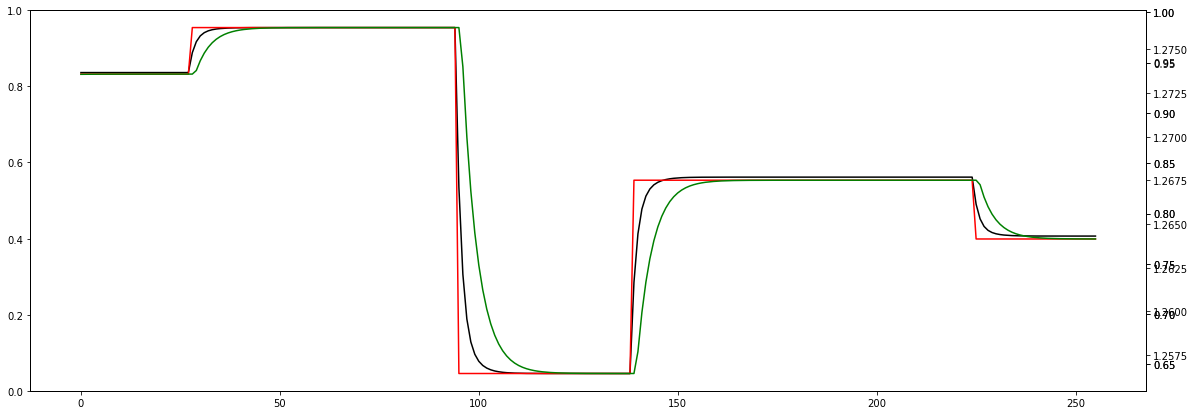

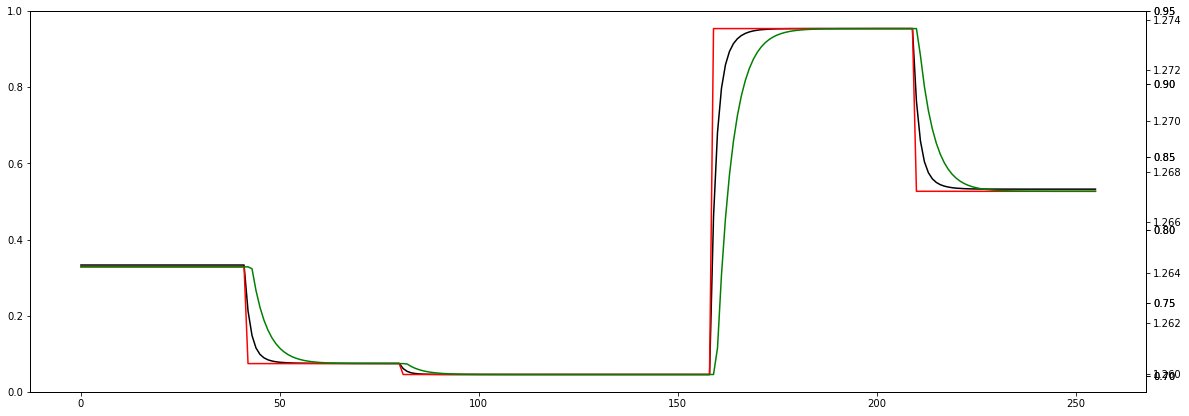

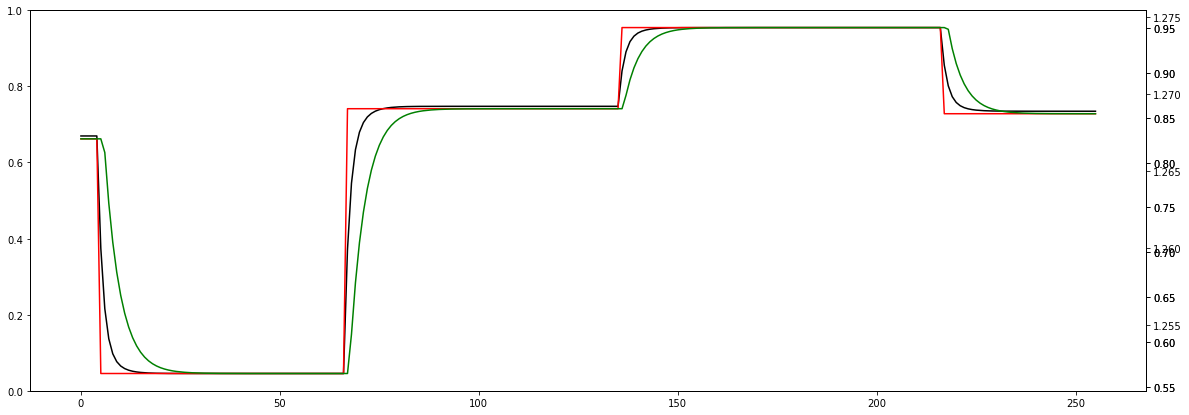

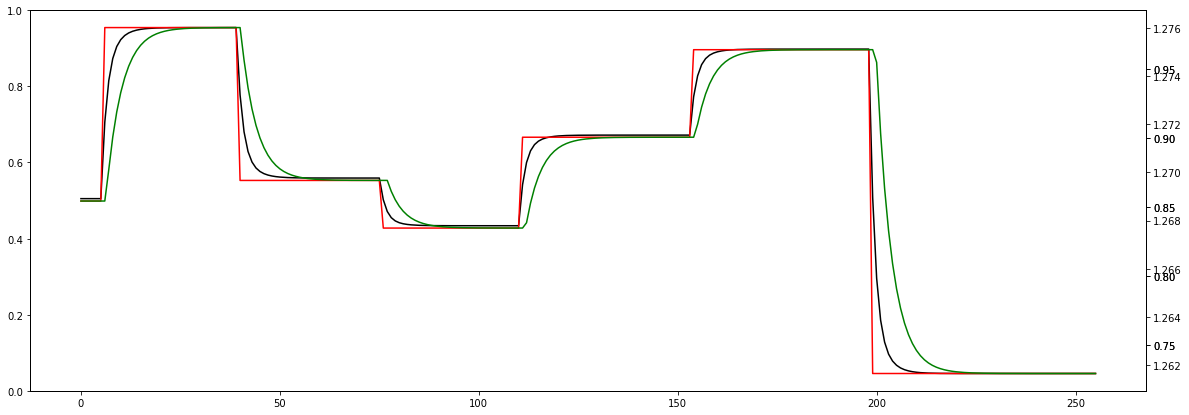

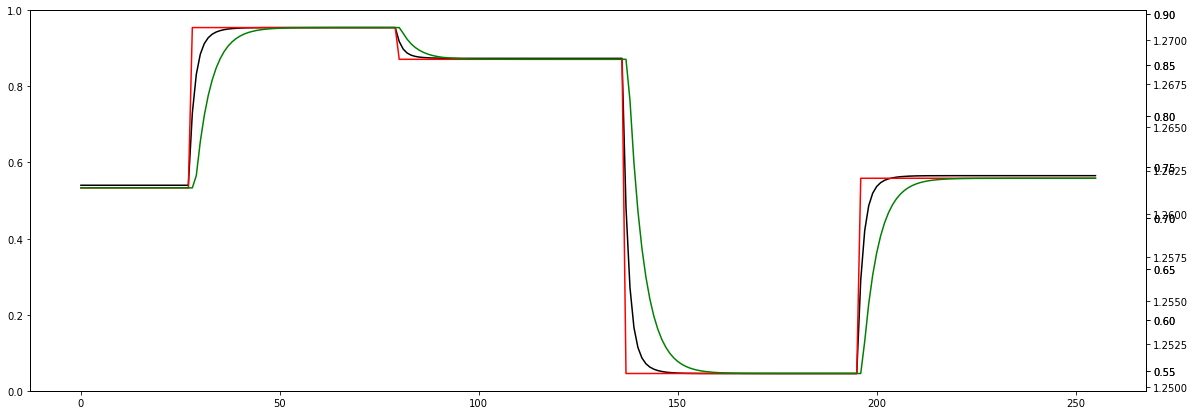

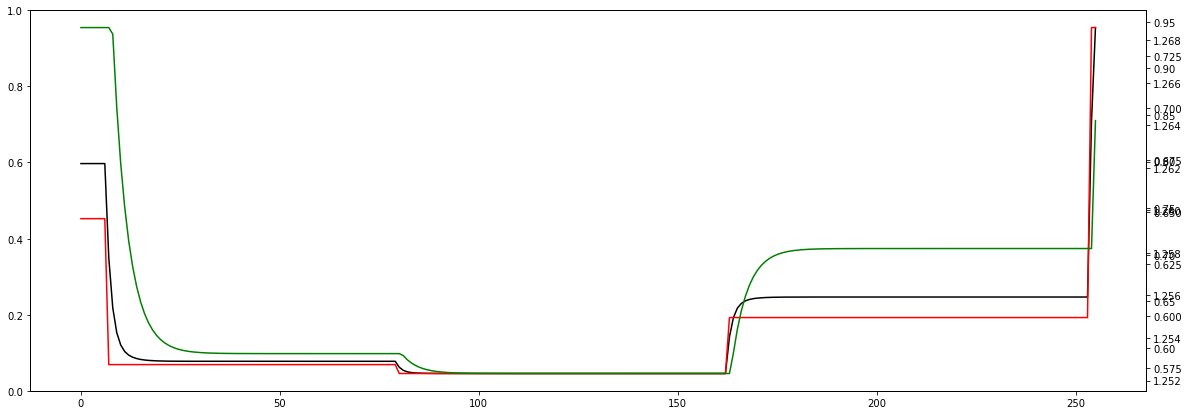

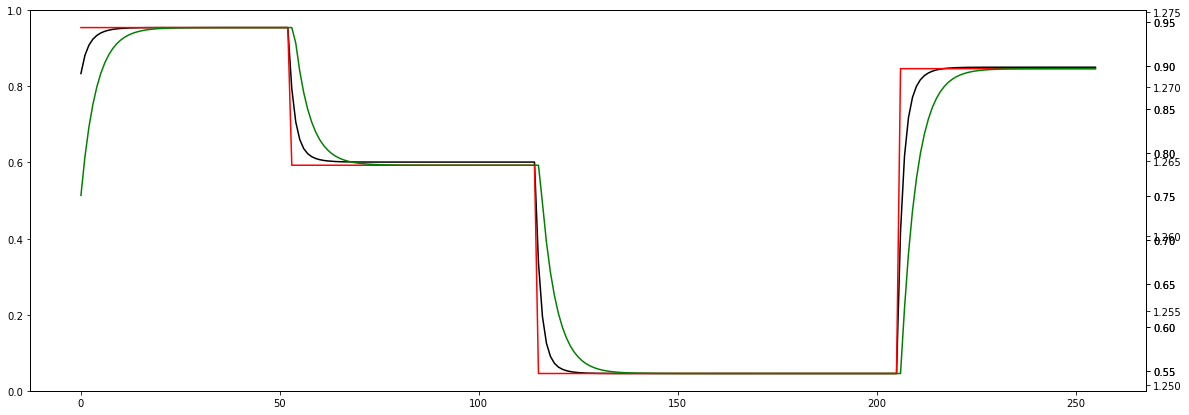

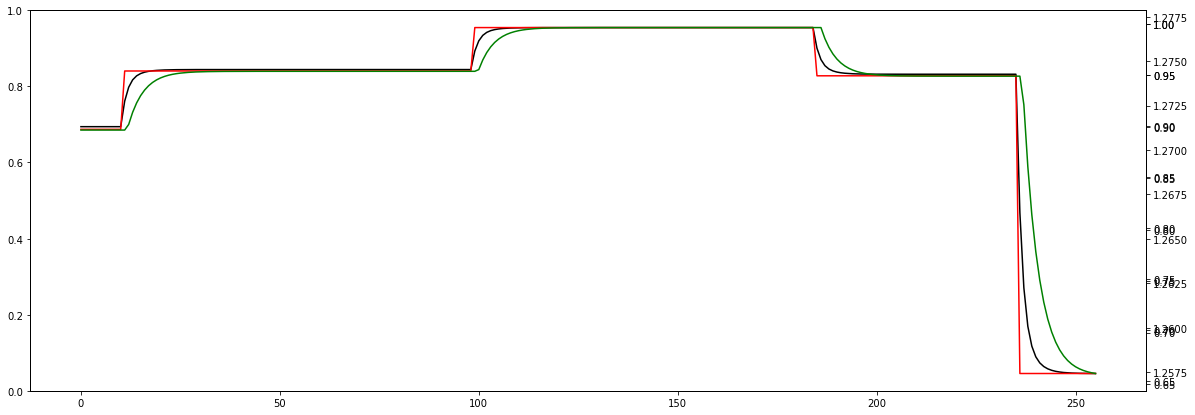

KeyboardInterrupt: 

In [90]:
for batch in test_dl:
    plot_multiscale(
    [
        (1-(model(batch[0].transpose(0,1))[0]).detach().numpy(), 'black'),
    (batch[0][:,-1].detach().numpy(),  "red"),
    (batch[1][:,0].detach().numpy(),  "green")
    ]
)

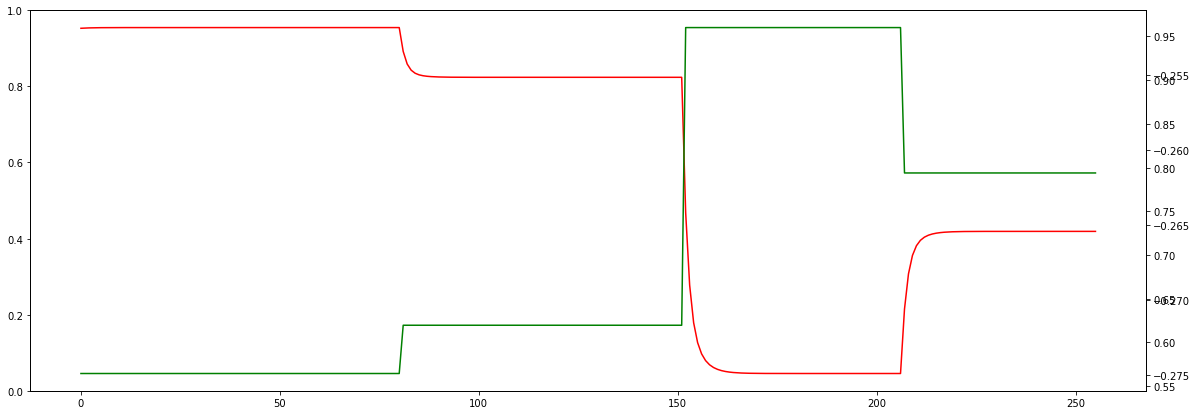

In [85]:
plot_multiscale(
    [
    (check_y.detach().numpy(),  "red"),
    (x_batch[-1].detach().numpy(),  "green")
    ]
)

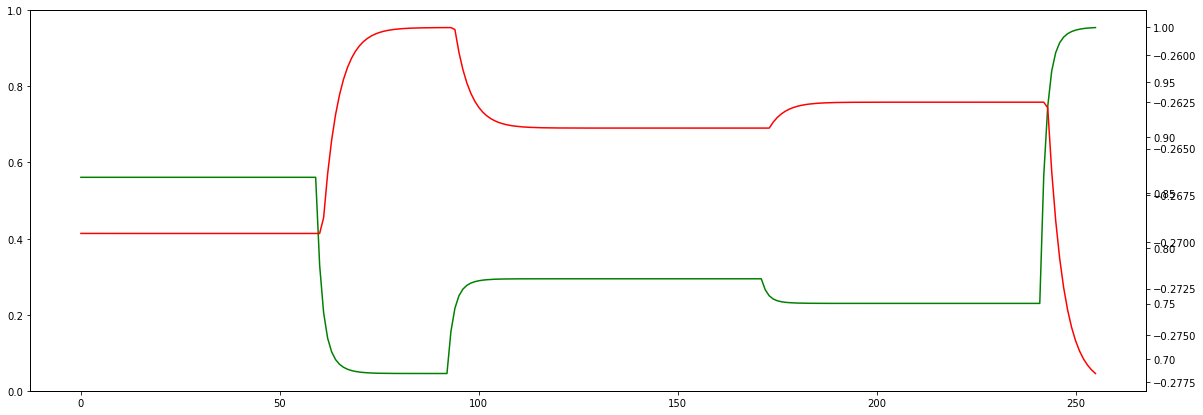

In [34]:
plot_multiscale(
[
(y_pred_test.detach().numpy(), 'green'),
(y_batch_test.detach().numpy(), 'red')   
]
)

In [25]:
s, e = 3, t

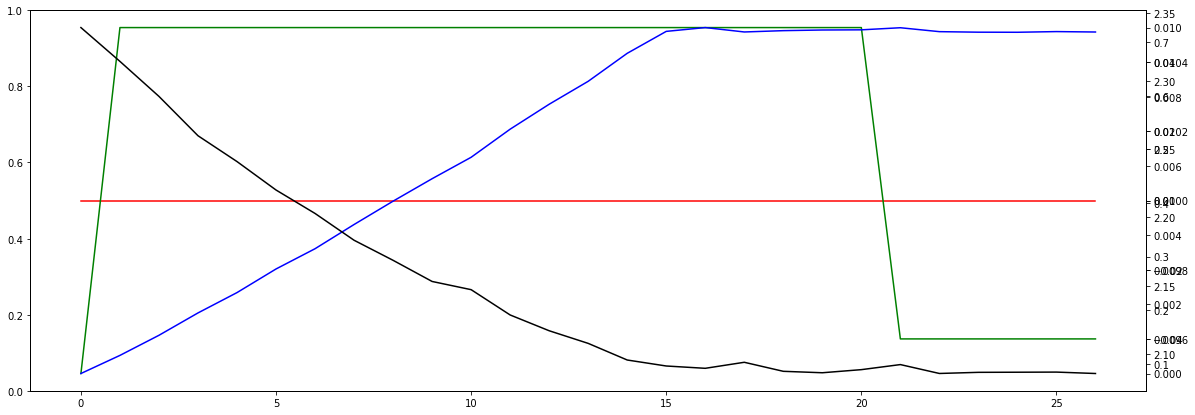

In [26]:
plot_multiscale([
    (hist['lr'][s:e],"Red" ),
    (hist['loss_rate'][s:e], "Green"),
    (hist['weights_sum'][s:e], "Blue"),
    (hist['weights_var'][s:e], "Yellow"),
    (hist['eval_test']['epochs']['aux'][s:e], "Black")
])

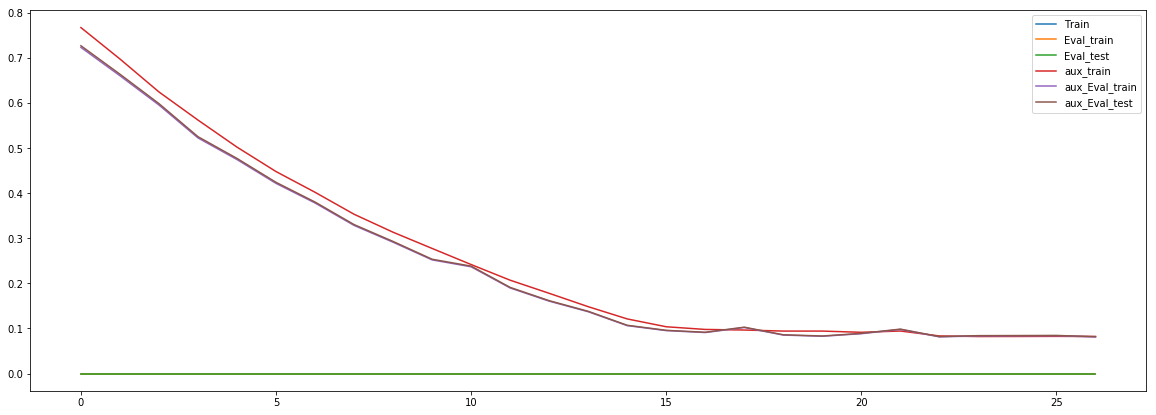

In [27]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

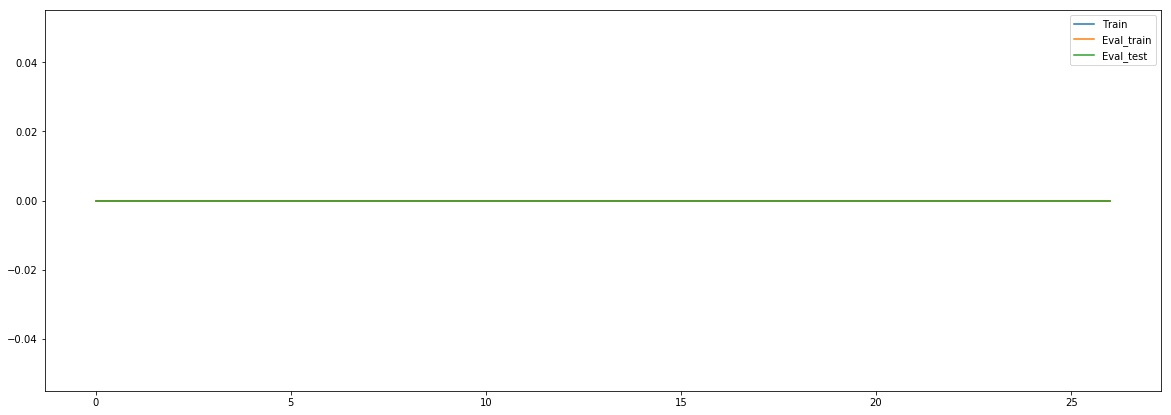

In [28]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
#     (hist['train']["epochs"]['aux'][s:e], "aux_train"),
#     (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
#     (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

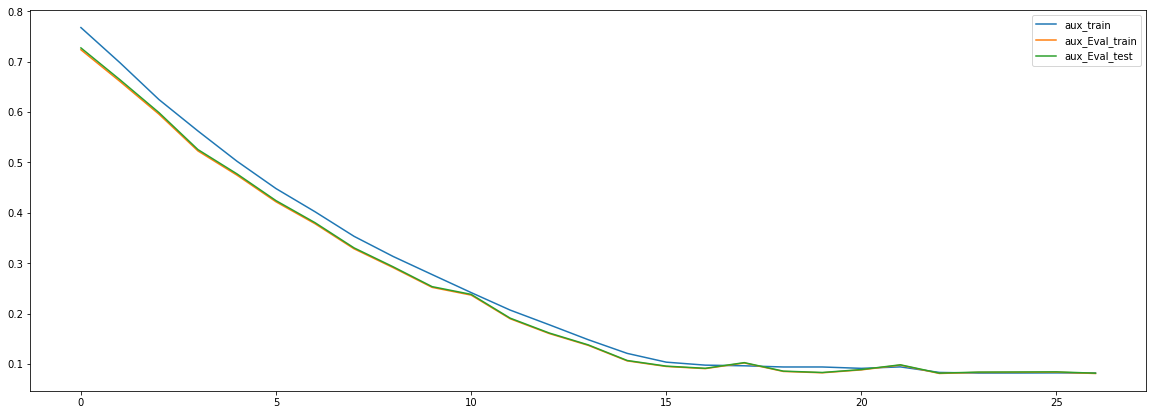

In [29]:
plot_shared_scale([
#     (hist['train']["epochs"]['main'][s:e],"Train" ),
#     (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
#     (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

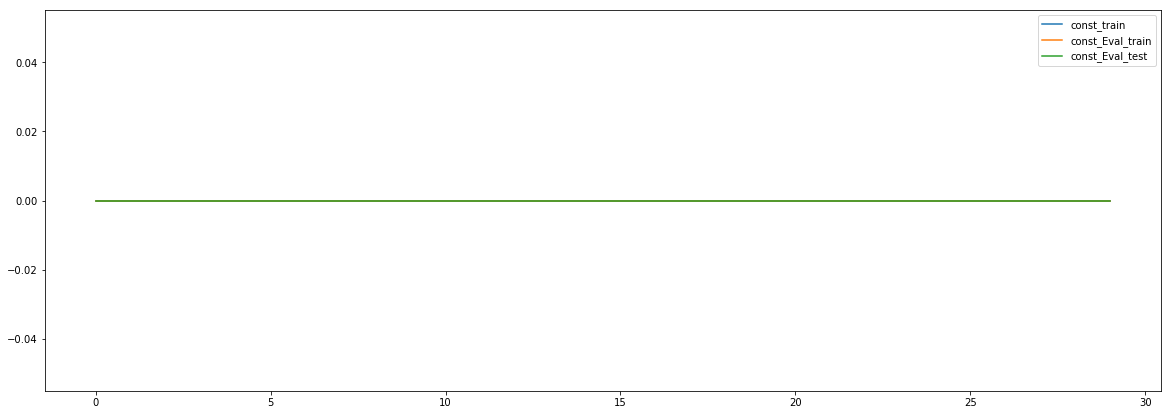

In [24]:
plot_shared_scale([
    (hist['train']["epochs"]['const'][s:e], "const_train"),
    (hist['eval_train']['epochs']['const'][s:e], "const_Eval_train"),
    (hist['eval_test']['epochs']['const'][s:e], "const_Eval_test")
])

In [89]:
for n, v in model.named_parameters():
    print(n, "\t", v.shape, "\t", v.sum())

jordan 	 torch.Size([1, 2]) 	 tensor(1.4808, grad_fn=<SumBackward0>)
lstm.weight_ih_l0 	 torch.Size([32, 3]) 	 tensor(1.2374, grad_fn=<SumBackward0>)
lstm.weight_hh_l0 	 torch.Size([32, 8]) 	 tensor(0.1560, grad_fn=<SumBackward0>)
lstm.bias_ih_l0 	 torch.Size([32]) 	 tensor(0.5072, grad_fn=<SumBackward0>)
lstm.bias_hh_l0 	 torch.Size([32]) 	 tensor(-0.9915, grad_fn=<SumBackward0>)
linear.weight 	 torch.Size([1, 8]) 	 tensor(0.1536, grad_fn=<SumBackward0>)
linear.bias 	 torch.Size([1]) 	 tensor(-0.2074, grad_fn=<SumBackward0>)


In [ ]:
plot_shared_scale([
                  (hist['mean_params_sample']['1'][s:e], "p1"),
                  ((hist['mean_params_sample']['2']*0 + 1)[s:e], "p2"),
                  (hist['mean_params_sample']['2'][s:e], "p2"),
                  ((hist['mean_params_sample']['2']*0 + 0.5)[s:e], "p2"),
])

In [ ]:
model.buffers

In [ ]:
logging.info("Training process END")